## LSTM Model Analysis Stocks - Finna
Follow along the code to do the preliminary data analysis!\
**Please refer to the [meeting notes here](https://docs.google.com/document/d/1tnDnYfO5m5GQz5Fm7_TbpzHN9bG3RmvqpgvL4TyOevI/edit?usp=sharing) to get familiar with all the column names and the values associated with them.**

### Step 1: Install the necessary libraries for our data collection.
[yfinance](https://python-yahoofinance.readthedocs.io/en/latest/): used to fetch historical stock data (price, volume, etc.) from Yahoo Finance for our assigned sectors.\
[ta](https://technical-analysis-library-in-python.readthedocs.io/en/latest/): used to calculate technical indicators from the price data we get with yfinance. These indicators help our model understand:
- Trends (e.g., SMA, EMA, MACD)
- Momentum (e.g., RSI)
- Volatility (e.g., ATR, Bollinger Bands)
- Volume pressure (e.g., OBV)

In [87]:
!pip install yfinance
!pip install ta
!pip install fredapi
!pip install dotenv
!pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


### Step 2: Import the necessary libraries

In [88]:
import yfinance as yf
import pandas as pd
import time
import ta
from fredapi import Fred
import pandas as pd
import os
from dotenv import load_dotenv
from fredapi import Fred

In [89]:
# Data Handling
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings for nicer visuals
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)

### Step 3: Collect Preliminary Stock Data Using `yfinance`

In this step, you will collect **5 years of historical daily stock data** for your assigned sector using the `yfinance` library.

**What this code does:**
- Loops through a list of stock tickers.
- Uses `yfinance` to download daily data for each stock over a 5-year period.
- Waits 3 seconds between requests to avoid hitting API limits.
- Cleans and formats the data: resets the index and adds a "Ticker" column.
- Stores all the data in one master DataFrame called `price_df`.

**What you need to do:**
- Replace the `tickers` list with the stocks **assigned to your sector**.
- You can find your list of stocks by referring to the excel file we created earlier [here](https://docs.google.com/spreadsheets/d/19n8ye_mwPM6QVbFJjG4eVUfiqUiGMQ-MujnMY_zMUs8/edit?usp=sharing).
- Run the code block to create your `price_df`, which you will later use for feature engineering.

If no data is found or an error occurs for a ticker, it will be skipped and reported in the output.\

*If you are running into errors with `yfinance` and hitting api limits, please wait a few hours and try running the code again. Please avoing running the cell multiple times to not run into this issue!*

Below is the code you should run (after customizing your ticker list):

In [90]:
# Refer back to the csv file to find the stocks you selected, and replace these tickers with your own.
tickers = [
    "SEZL", "IDCC", "AGYS", "BOX", "ZETA", "YOU",
    "PAYO", "PAY", "LRN", "UPWK", "CLSK", "CIFR",
    "WHD", "AESI", "POST", "AROC", "LPX",
    "LNTH", "LMAT", "CPRX", "CORT", "SEM",
    "ANF", "WRBY", "OLLI", "ELF", "BROS",
    "FSV", "TRNO", "CIGI", "MRP", "ABM"
]

#CODE BELOW DOES NOT NEED TO BE CHANGED
# List to hold all data
all_data = []

# Loop through each ticker
for ticker in tickers:
    try:
        df = yf.Ticker(ticker).history(period="5y", interval="1d")
        time.sleep(3) # wait in between requests to avoid request limits
        if df.empty:
            print(f"No data for {ticker}")
            continue

        df = df.reset_index()  # Convert index to Date column
        df["Ticker"] = ticker  # Add ticker column
        all_data.append(df[["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]])
        print(f"{ticker} added")
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

# Concatenate all into one DataFrame
price_df = pd.concat(all_data, ignore_index=True)

# Preview the result
print(price_df.head())

SEZL added
IDCC added
AGYS added
BOX added
ZETA added
YOU added
PAYO added
PAY added
LRN added
UPWK added
CLSK added
CIFR added
WHD added
AESI added
POST added
AROC added
LPX added
LNTH added
LMAT added
CPRX added
CORT added
SEM added
ANF added
WRBY added
OLLI added
ELF added
BROS added
FSV added
TRNO added
CIGI added
MRP added
ABM added
                       Date Ticker       Open       High        Low  \
0 2023-09-13 00:00:00-04:00   SEZL  13.513333  13.513333  13.513333   
1 2023-09-14 00:00:00-04:00   SEZL   3.645000   6.092500   2.566667   
2 2023-09-15 00:00:00-04:00   SEZL   2.641667   2.641667   2.223333   
3 2023-09-18 00:00:00-04:00   SEZL   2.113333   2.695000   1.888333   
4 2023-09-19 00:00:00-04:00   SEZL   3.401667   4.116667   2.720000   

       Close    Volume  
0  13.513333         0  
1   2.635000    951600  
2   2.236667    356400  
3   2.155000    713400  
4   2.900000  10405200  


### Step 4: Generate Price-Based and Technical Indicators

Now that you have your stock data, it’s time to create additional features that help the model understand market trends, volatility, and momentum.

**What this code does:**
- Calculates **daily returns** and **VWAP** (volume-weighted average price).
- Adds several **technical indicators** like:
  - Simple and Exponential Moving Averages (SMA, EMA)
  - Relative Strength Index (RSI)
  - MACD and Signal Line
  - Bollinger Bands (Upper and Lower)
  - Average True Range (ATR)
  - On-Balance Volume (OBV)
- Groups the data by ticker to apply indicator calculations correctly.
- Combines everything into a single DataFrame with all features.

**What you need to do:**
- You **do not need to modify anything** in this code block **except one thing**:
  - In the **last line**, rename the CSV file to reflect your assigned sector name:
    ```python
    tech_df.to_csv("your_sector_name_data_with_indicators.csv", index=False)
    ```

Once this is done, you’ll have a feature-rich dataset ready for modeling!

In [91]:
tech_df = price_df.copy()

# --- Price-based indicators ---
tech_df['Daily Return'] = tech_df.groupby("Ticker")['Close'].pct_change(fill_method=None)
tech_df['Typical Price'] = (tech_df['High'] + tech_df['Low'] + tech_df['Close']) / 3
tech_df['VWAP'] = (tech_df['Typical Price'] * tech_df['Volume']).groupby(tech_df['Ticker']).cumsum() / tech_df['Volume'].groupby(tech_df['Ticker']).cumsum()

# --- Technical indicators ---
grouped = tech_df.groupby("Ticker", group_keys=False)
tech_df['SMA_20'] = grouped['Close'].apply(lambda x: x.rolling(window=20).mean())
tech_df['EMA_20'] = grouped['Close'].apply(lambda x: x.ewm(span=20, adjust=False).mean())
tech_df['RSI_14'] = grouped['Close'].apply(lambda x: ta.momentum.RSIIndicator(close=x, window=14).rsi())
tech_df['MACD'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd())
tech_df['MACD_Signal'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd_signal())
tech_df['BB_Upper'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_hband())
tech_df['BB_Lower'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_lband())
# Create empty columns
tech_df['ATR'] = None
tech_df['OBV'] = None

# Loop through each group (ticker) and calculate indicators
result_frames = []

for ticker, group in tech_df.groupby("Ticker"):
    group = group.copy()
    group.sort_values('Date', inplace=True)

    # ATR
    atr = ta.volatility.AverageTrueRange(
        high=group['High'],
        low=group['Low'],
        close=group['Close']
    ).average_true_range()
    group['ATR'] = atr

    # OBV
    obv = ta.volume.OnBalanceVolumeIndicator(
        close=group['Close'],
        volume=group['Volume']
    ).on_balance_volume()
    group['OBV'] = obv

    result_frames.append(group)

# Combine the updated groups back together
tech_df = pd.concat(result_frames, ignore_index=True)

# Save to CSV, rename it to correspond to your sector. Please replace "sector" with your corresponding sector.
tech_df.to_csv("sector_data_with_indicators.csv", index=False)

### Data Collection – Economic Data via FRED API
We're using the *FRED (Federal Reserve Economic Data) API* to pull U.S. macroeconomic indicators like GDP, unemployment rate, CPI, and more.

**Step 1: Create a .env File in the Root Directory**

- In the main folder of your project (same level as your notebook or script), create a file called: `.env`
- Inside the `.env` file, paste the following (replace `your_api_key_here` with your own key that you generate from step 2): `FRED_API_KEY=your_api_key_here`

**Step 2: Get Your API Key from FRED**
- Go to: https://fred.stlouisfed.org/
- Click Sign In (or Create an account if you don’t have one).
- Go to My Account > API Keys
- Click "Generate API Key"
- Copy the key and paste it into your .env file as shown above.

In [92]:
mcs_df = pd.read_csv("sector_data_with_indicators.csv")
mcs_df.head() #shows first 5 rows of data frame

Date Ticker       Open       High        Low  \
0  2020-04-28 00:00:00-04:00    ABM  30.716623  31.334591  30.307674   
1  2020-04-29 00:00:00-04:00    ABM  31.870770  33.170320  31.625400   
2  2020-04-30 00:00:00-04:00    ABM  31.807150  32.479645  31.134654   
3  2020-05-01 00:00:00-04:00    ABM  30.634831  31.025604  29.716969   
4  2020-05-04 00:00:00-04:00    ABM  29.735147  29.998690  29.044476   

       Close   Volume  Daily Return  Typical Price       VWAP  SMA_20  \
0  30.980169   421600           NaN      30.874145  30.874145     NaN   
1  32.670494   482200      0.054562      32.488738  31.735571     NaN   
2  31.343676  1435500     -0.040612      31.652658  31.684692     NaN   
3  30.207708   418600     -0.036242      30.316760  31.477064     NaN   
4  29.407988   551200     -0.026474      29.483718  31.145031     NaN   

      EMA_20  RSI_14  MACD  MACD_Signal  BB_Upper  BB_Lower  ATR      OBV  
0  30.980169     NaN   NaN          NaN       NaN       NaN  0.0   421600  
1  31.141153     NaN   NaN          NaN       NaN       NaN  0.0   903800  
2  31.160441     NaN   NaN          NaN       NaN       NaN  0.0  -531700  
3  31.069704     NaN   NaN          NaN       NaN       NaN  0.0  -950300  
4  30.911445     NaN   NaN          NaN       NaN       NaN  0.0 -1501500

In [93]:
from fredapi import Fred
from dotenv import load_dotenv
import pandas as pd
import os

load_dotenv()
fred = Fred(api_key=os.getenv("FRED_API_KEY"))

mcs_df['Date'] = pd.to_datetime(mcs_df['Date'], errors='coerce', utc=True)

# Dynamically extract date range from your stock data
start_date = mcs_df['Date'].min().strftime('%Y-%m-%d')
end_date = mcs_df['Date'].max().strftime('%Y-%m-%d')

# Fetch macroeconomic data for the matching date range
economic_data = pd.DataFrame({
    'Unemployment': fred.get_series('UNRATE', start_date, end_date),
    'Inflation_CPI': fred.get_series('CPIAUCSL', start_date, end_date),
    'Fed_Funds_Rate': fred.get_series('FEDFUNDS', start_date, end_date),
    'GDP': fred.get_series('GDP', start_date, end_date),
    '10Y_Treasury': fred.get_series('GS10', start_date, end_date),
    'Consumer_Sentiment': fred.get_series('UMCSENT', start_date, end_date),
    'Retail_Sales': fred.get_series('RSAFS', start_date, end_date),
})

# Reset index and fix Date column
economic_data = economic_data.reset_index()
economic_data.rename(columns={"index": "Date"}, inplace=True)
economic_data['Date'] = pd.to_datetime(economic_data['Date'])

# Preview the aligned economic data
economic_data.head()

# Print date ranges to verify alignment
print(f"Stock data range: {start_date} to {end_date}")
print(f"Economic data range: {economic_data['Date'].min().strftime('%Y-%m-%d')} to {economic_data['Date'].max().strftime('%Y-%m-%d')}")

Stock data range: 2020-04-28 to 2025-04-28
Economic data range: 2020-04-01 to 2025-03-01


In [290]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
import ta
import time

def get_market_data(tickers=None, lookback_years=5, include_technical_indicators=True):
    """
    Fetch, align, and enrich stock and economic data for specified tickers,
    with debug prints after each major step.
    """
    # Load API key
    load_dotenv()
    fred_api_key = os.getenv("FRED_API_KEY")
    if not fred_api_key:
        raise ValueError("FRED API key not found in environment variables")
    fred = Fred(api_key=fred_api_key)
    
    # Default tickers
    if tickers is None:
        tickers = [
            "CBRE", "PLD", "AMT", "WELL", "EQIX", 
            "SPG", "PSA", "DLR", "O", "CCI", 
            "VICI", "EXR", "CSGP", "AVB", "VTR", 
            "EQR", "IRM", "SBAC", "WY", "INVH", "YOU"
        ]
    
    # Date window
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=lookback_years*365)).strftime('%Y-%m-%d')
    
    # 1) Fetch stock data + technicals
    all_data = []
    for ticker in tickers:
        try:
            print(f"\n--- Fetching {ticker} ---")
            df = yf.Ticker(ticker).history(period=f"{lookback_years}y", interval="1d")
            time.sleep(1)
            if df.empty:
                print(f"No data for {ticker}, skipping.")
                continue
            
            df = df.reset_index()
            # Strip any timezone to match FRED later:
            df["Date"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)
            df["Ticker"] = ticker
            
            # Base columns
            stock_data = df[["Date","Ticker","Open","High","Low","Close","Volume"]].copy()
            
            if include_technical_indicators:
                stock_data["Daily_Return"]    = stock_data["Close"].pct_change()
                stock_data["Typical_Price"]   = (stock_data[["High","Low","Close"]].sum(axis=1))/3
                stock_data["VWAP"] = (stock_data["Typical_Price"]*stock_data["Volume"]).cumsum() / stock_data["Volume"].cumsum()
                
                # TA indicators
                stock_data["SMA_20"]   = ta.trend.sma_indicator(stock_data["Close"], window=20)
                stock_data["EMA_20"]   = ta.trend.ema_indicator(stock_data["Close"], window=20)
                stock_data["RSI_14"]   = ta.momentum.RSIIndicator(stock_data["Close"], window=14).rsi()
                macd = ta.trend.MACD(stock_data["Close"])
                stock_data["MACD"]        = macd.macd()
                stock_data["MACD_Signal"] = macd.macd_signal()
                stock_data["MACD_Diff"]   = stock_data["MACD"] - stock_data["MACD_Signal"]
                
                bb = ta.volatility.BollingerBands(stock_data["Close"], window=20)
                stock_data["BB_Upper"] = bb.bollinger_hband()
                stock_data["BB_Lower"] = bb.bollinger_lband()
                
                stock_data["ATR"] = ta.volatility.AverageTrueRange(
                    high=stock_data["High"],
                    low=stock_data["Low"],
                    close=stock_data["Close"]
                ).average_true_range()
                
                stock_data["OBV"] = ta.volume.OnBalanceVolumeIndicator(
                    close=stock_data["Close"],
                    volume=stock_data["Volume"]
                ).on_balance_volume()
                
                stock_data["Rolling_Close_Mean_5"] = stock_data["Close"].rolling(5).mean()
                stock_data["Rolling_Return_3"]     = stock_data["Close"].pct_change().rolling(3).mean()
            
            all_data.append(stock_data)
            print(f"{ticker} 🎉 processed, {len(stock_data)} rows.")
            
        except Exception as e:
            print(f"Error with {ticker}: {e}")
    
    if not all_data:
        raise ValueError("No stock data retrieved.")
    
    stock_data = pd.concat(all_data, ignore_index=True)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    print(f"\nStock data combined: {stock_data.shape[0]} rows, {stock_data.shape[1]} cols")
    
    # Earliest/latest trading dates
    earliest = stock_data["Date"].min().date()
    latest   = stock_data["Date"].max().date()
    print(f"Date-range (stocks): {earliest} → {latest}")
    
    # Define monthly window for econ
    econ_start = earliest.replace(day=1).strftime("%Y-%m-%d")
    econ_end   = latest.strftime("%Y-%m-%d")
    print(f"→ Fetching economic series {econ_start} to {econ_end}")
    
    # 2) Fetch economic data
    econ = pd.DataFrame({
        "Unemployment":      fred.get_series("UNRATE", econ_start, econ_end),
        "Inflation_CPI":     fred.get_series("CPIAUCSL", econ_start, econ_end),
        "Fed_Funds_Rate":    fred.get_series("FEDFUNDS", econ_start, econ_end),
        "GDP":               fred.get_series("GDP", econ_start, econ_end),
        "10Y_Treasury":      fred.get_series("GS10", econ_start, econ_end),
        "Consumer_Sentiment":fred.get_series("UMCSENT", econ_start, econ_end),
        "Retail_Sales":      fred.get_series("RSAFS", econ_start, econ_end),
    })
    # Inspect raw econ pull
    print("\nRaw economic_data (monthly):")
    print(econ.head(), "\n...", econ.tail())
    econ = econ.reset_index().rename(columns={"index":"Date"})
    econ["Date"] = pd.to_datetime(econ["Date"])
    print("Range econ Date:", econ["Date"].min().date(), "→", econ["Date"].max().date())
    print("Any NaT in econ['Date']?", econ["Date"].isna().any())
    
    # 3) Forward-fill to daily
    full_idx = pd.date_range(start=earliest, end=latest, freq="D")
    econ_daily = econ.set_index("Date").reindex(full_idx).ffill()
    econ_daily.index.name = "Date"
    econ_daily = econ_daily.reset_index()
    print("\nEconomic data (daily) sample:")
    print(econ_daily.head(7))
    print("Index dtype:", econ_daily["Date"].dtype)
    
    # create additional features
    econ_daily["GDP_Growth"]      = econ_daily["GDP"].pct_change() * 100
    econ_daily["GDP_Growth_Lag1"] = econ_daily["GDP_Growth"].shift(1)
    econ_daily["Inflation_Lag1"]  = econ_daily["Inflation_CPI"].shift(1)
    econ_daily["Month"]           = econ_daily["Date"].dt.month
    econ_daily["Quarter"]         = econ_daily["Date"].dt.quarter
    econ_daily["Is_Earnings_Season"] = econ_daily["Month"].isin([1,4,7,10]).astype(int)
    
    # 4) Merge
    print("\nMerging stock_data with econ_daily on 'Date'…")
    merged = pd.merge(
        stock_data, econ_daily,
        on="Date", how="left", validate="many_to_one"
    )
    print(" After merge → sample:")
    print(merged[["Date","Ticker","Unemployment","Inflation_CPI"]].head(8))
    print(" Non-null macro rows:", merged["Unemployment"].notna().sum(),
          "/", merged.shape[0])
    
    # 5) Fill any straggler NaNs, create interactions
    macro_cols = ["Unemployment","Inflation_CPI","Fed_Funds_Rate","GDP",
                  "10Y_Treasury","Consumer_Sentiment","Retail_Sales",
                  "GDP_Growth","GDP_Growth_Lag1","Inflation_Lag1"]
    for col in macro_cols:
        if col in merged:
            merged[col] = merged[col].ffill().bfill()
    
    # interactions & time-based
    merged["MACD_x_Inflation"] = merged["MACD_Diff"] * merged["Inflation_CPI"]
    merged["Price_Range"]      = merged["High"] - merged["Low"]
    merged["Volatility_x_InterestRate"] = (
        merged["Price_Range"] * merged["Fed_Funds_Rate"]
    )
    merged["GDP_Previous"]       = merged.groupby("Ticker")["GDP"].shift(1)
    merged["Is_GDP_Report_Month"] = (
        (merged["GDP"] != merged["GDP_Previous"]) & (~merged["GDP"].isna())
    ).astype(int)
    mask = (~merged["GDP"].isna()) & (~merged["GDP_Previous"].isna())
    merged.loc[mask,"GDP_Direction"] = np.sign(
        merged.loc[mask,"GDP"] - merged.loc[mask,"GDP_Previous"]
    )
    merged["Month_In_Quarter"] = merged["Date"].dt.month % 3
    merged.loc[merged["Month_In_Quarter"]==0,"Month_In_Quarter"] = 3
    
    # Final stats
    print(f"\nFinal merged: {merged.shape[0]} rows, {merged.shape[1]} cols")
    print("Date range:", merged["Date"].min().date(), "→", merged["Date"].max().date())
    print("Tickers:", merged["Ticker"].nunique())
    
    return merged

if __name__ == "__main__":
    # Default tickers list is already built into the function
    market_data = get_market_data(lookback_years=5)
    
    # Save to CSV
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    market_data.to_csv(f'market_data_with_indicators_{timestamp}.csv', index=False)
    
    print(f"Data saved to market_data_with_indicators_{timestamp}.csv")
    
    # Preview the data
    print("\nData Preview:")
    print(market_data.head())
    
    # Check for any remaining NaN values
    nan_count = market_data.isna().sum().sum()
    print(f"Total NaN values in dataset: {nan_count}")


--- Fetching CBRE ---
CBRE 🎉 processed, 1256 rows.

--- Fetching PLD ---
PLD 🎉 processed, 1256 rows.

--- Fetching AMT ---
AMT 🎉 processed, 1256 rows.

--- Fetching WELL ---
WELL 🎉 processed, 1256 rows.

--- Fetching EQIX ---
EQIX 🎉 processed, 1256 rows.

--- Fetching SPG ---
SPG 🎉 processed, 1256 rows.

--- Fetching PSA ---
PSA 🎉 processed, 1256 rows.

--- Fetching DLR ---
DLR 🎉 processed, 1256 rows.

--- Fetching O ---
O 🎉 processed, 1256 rows.

--- Fetching CCI ---
CCI 🎉 processed, 1256 rows.

--- Fetching VICI ---
VICI 🎉 processed, 1256 rows.

--- Fetching EXR ---
EXR 🎉 processed, 1256 rows.

--- Fetching CSGP ---
CSGP 🎉 processed, 1256 rows.

--- Fetching AVB ---
AVB 🎉 processed, 1256 rows.

--- Fetching VTR ---
VTR 🎉 processed, 1256 rows.

--- Fetching EQR ---
EQR 🎉 processed, 1256 rows.

--- Fetching IRM ---
IRM 🎉 processed, 1256 rows.

--- Fetching SBAC ---
SBAC 🎉 processed, 1256 rows.

--- Fetching WY ---
WY 🎉 processed, 1256 rows.

--- Fetching INVH ---
INVH 🎉 processed, 125

In [291]:
market_data.head(25)       # peek at the first 5 rows

Date Ticker       Open       High        Low      Close   Volume  \
0  2020-04-29   CBRE  43.619999  45.099998  42.650002  44.919998  2025500   
1  2020-04-30   CBRE  44.000000  44.000000  42.680000  42.930000  2125400   
2  2020-05-01   CBRE  41.660000  41.849998  39.259998  39.700001  2208000   
3  2020-05-04   CBRE  38.689999  39.520000  38.549999  39.389999  1718600   
4  2020-05-05   CBRE  40.290001  41.400002  39.529999  39.590000  2423600   
5  2020-05-06   CBRE  40.060001  40.580002  38.130001  38.150002  2399900   
6  2020-05-07   CBRE  39.630001  41.830002  38.200001  40.889999  2187400   
7  2020-05-08   CBRE  41.650002  42.540001  41.400002  41.599998  1370000   
8  2020-05-11   CBRE  41.180000  41.180000  40.470001  40.820000  1857600   
9  2020-05-12   CBRE  40.820000  40.959999  37.150002  37.200001  1996400   
10 2020-05-13   CBRE  36.700001  36.860001  34.200001  34.840000  4229500   
11 2020-05-14   CBRE  34.060001  35.910000  33.029999  35.849998  2629100   
12 2020-05-15   CBRE  35.590000  36.439999  35.119999  35.990002  1820500   
13 2020-05-18   CBRE  37.770000  39.560001  37.540001  39.090000  2455700   
14 2020-05-19   CBRE  38.980000  39.099998  37.950001  37.970001  2162200   
15 2020-05-20   CBRE  38.820000  39.959999  38.610001  39.599998  2634500   
16 2020-05-21   CBRE  39.419998  40.840000  39.419998  40.750000  2707700   
17 2020-05-22   CBRE  40.799999  40.919998  40.080002  40.299999  2598100   
18 2020-05-26   CBRE  42.360001  44.730000  42.360001  43.939999  3112000   
19 2020-05-27   CBRE  45.000000  45.599998  43.270000  45.150002  2178000   
20 2020-05-28   CBRE  45.720001  45.980000  43.970001  44.119999  2731500   
21 2020-05-29   CBRE  43.209999  44.290001  42.810001  43.980000  6324200   
22 2020-06-01   CBRE  43.810001  44.590000  43.590000  44.139999  1331300   
23 2020-06-02   CBRE  44.509998  46.220001  44.189999  45.990002  2309500   
24 2020-06-03   CBRE  47.470001  50.200001  47.040001  49.500000  3234400   

    Daily_Return  Typical_Price       VWAP  ...  Month  Quarter  \
0            NaN      44.223333  44.223333  ...      4        2   
1      -0.044301      43.203334  43.701059  ...      4        2   
2      -0.075239      40.269999  42.509693  ...      5        2   
3      -0.007809      39.153333  41.795581  ...      5        2   
4       0.005077      40.173333  41.421174  ...      5        2   
5      -0.036373      38.953335  40.962096  ...      5        2   
6       0.071822      40.306667  40.867077  ...      5        2   
7       0.017364      41.846667  40.948618  ...      5        2   
8      -0.018750      40.823334  40.935912  ...      5        2   
9      -0.088682      38.436667  40.690274  ...      5        2   
10     -0.063441      35.300001  39.761326  ...      5        2   
11      0.028990      34.929999  39.293840  ...      5        2   
12      0.003905      35.850000  39.077587  ...      5        2   
13      0.086135      38.730001  39.050444  ...      5        2   
14     -0.028652      38.340000  39.004739  ...      5        2   
15      0.042929      39.389999  39.032743  ...      5        2   
16      0.029040      40.336666  39.123384  ...      5        2   
17     -0.011043      40.433333  39.205295  ...      5        2   
18      0.090323      43.676666  39.516858  ...      5        2   
19      0.027538      44.673333  39.756629  ...      5        2   
20     -0.022813      44.690000  40.028470  ...      5        2   
21     -0.003173      43.693334  40.443126  ...      5        2   
22      0.003638      44.106667  40.528353  ...      6        2   
23      0.041912      45.466667  40.719918  ...      6        2   
24      0.076321      48.913334  41.142102  ...      6        2   

    Is_Earnings_Season  MACD_x_Inflation  Price_Range  \
0                    1               NaN     2.449997   
1                    1               NaN     1.320000   
2                    0               NaN     2.590000   
3                    0             

#### Explanation of Economic Data Columns

These are the 7 macroeconomic indicators we’re pulling from the FRED API. Each of these plays an important role in understanding the broader U.S. economic landscape and can be useful features in predicting stock trends.

| **Column Name**         | **FRED Code**     | **Description**                                                                 | **Why It Matters for Stocks**                                                                 |
|-------------------------|-------------------|----------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| `Unemployment`          | `UNRATE`          | The U.S. unemployment rate — % of labor force unemployed and seeking work.       | High unemployment signals weak economic activity, potentially lowering stock prices.         |
| `Inflation_CPI`         | `CPIAUCSL`        | Consumer Price Index — measures average change in prices for consumer goods.     | Rising inflation reduces purchasing power and may lead to higher interest rates.             |
| `Fed_Funds_Rate`        | `FEDFUNDS`        | Interest rate at which banks lend to each other overnight — set by the Fed.      | Core monetary policy tool. Higher rates can reduce corporate earnings and stock demand.     |
| `GDP`                   | `GDP`             | Gross Domestic Product — total output of goods and services in the U.S. economy. | A growing GDP usually supports rising corporate earnings and investor confidence.            |
| `10Y_Treasury`          | `GS10`            | 10-Year Treasury Yield — benchmark return for long-term government bonds.        | Higher yields can attract investors away from stocks and increase borrowing costs.          |
| `Consumer_Sentiment`    | `UMCSENT`         | Measures consumer confidence in the economy.                                     | Higher sentiment boosts consumer spending, which drives business revenue and stock growth.  |
| `Retail_Sales`          | `RSAFS`           | Total seasonally adjusted retail sales in the U.S.                               | Reflects consumer spending habits — a key driver of U.S. GDP and corporate revenue.         |

---

#### Usage Notes:
- These indicators can be included as input features in time-series models.
- Consider using **lagged versions** or **rolling averages** to avoid data leakage.
- You can create **interaction terms** (e.g., `Inflation × Unemployment`) to capture more nuanced economic effects.


## Exploratory Data Analysis (EDA)

### EDA Guidelines

Follow these steps to explore and understand your dataset before modeling. This will help uncover patterns, identify issues, and engineer features that improve performance.

**Resources (Videos):**
- [Learn EDA - Playlist](https://www.youtube.com/watch?v=78ut-S-QOEQ&list=PLe9UEU4oeAuV7RtCbL76hca5ELO_IELk4&ab_channel=MarkKeith)
- [Complete Exploratory Data Analysis And Feature Engineering In 3 Hours| Krish Naik](https://youtu.be/fHFOANOHwh8?si=1SRsxlRJpOlUGMhI)
- [How to Do Data Exploration (step-by-step tutorial on real-life dataset)](https://youtu.be/OY4eQrekQvs?si=i1QzaMrCFQmxg1uJ)

#### 1) Get Rid of Any Null Values If You Have Any

- First, check for missing (`NaN`) values across all columns.
- If there are only a few missing entries, drop them.
- **Resource**: [A Guide to Handling Missing values in Python](https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python)

```python
# Check for null values
df.isnull().sum()

# Drop rows with any nulls (simple but aggressive)
df = df.dropna()

#### 2) Inspect Your Overall Cleaned Dataset Using Summary Statistics
- Use `.info()` and `.describe()` to understand the shape, datatypes, and distributions of the dataset.
- This gives a high-level snapshot of numeric features and potential outliers or irregularities.
- **Resource:**: [An Introduction To Summary Statistics In Python (With Code Examples)](https://zerotomastery.io/blog/summary-statistics-in-python/)

In [292]:
print(type(market_data))
# → <class 'pandas.core.frame.DataFrame'>

market_data.info()       # shows you row-count, dtypes, non-null counts

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26081 entries, 0 to 26080
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       26081 non-null  datetime64[ns]
 1   Ticker                     26081 non-null  object        
 2   Open                       26081 non-null  float64       
 3   High                       26081 non-null  float64       
 4   Low                        26081 non-null  float64       
 5   Close                      26081 non-null  float64       
 6   Volume                     26081 non-null  int64         
 7   Daily_Return               26060 non-null  float64       
 8   Typical_Price              26081 non-null  float64       
 9   VWAP                       26081 non-null  float64       
 10  SMA_20                     25682 non-null  float64       
 11  EMA_20                     25

In [293]:
market_data.describe()   # quick numeric summary

Date          Open          High  \
count                          26081  26081.000000  26081.000000   
mean   2022-11-02 19:16:19.057551616    135.672074    137.182948   
min              2020-04-29 00:00:00     11.169834     11.918606   
25%              2021-08-11 00:00:00     47.422744     48.017055   
50%              2022-11-03 00:00:00     88.788802     89.690002   
75%              2024-01-31 00:00:00    159.576366    161.261012   
max              2025-04-28 00:00:00    980.899549    988.888040   
std                              NaN    153.140300    154.754182   

                Low         Close        Volume  Daily_Return  Typical_Price  \
count  26081.000000  26081.000000  2.608100e+04  26060.000000   26081.000000   
mean     134.055681    135.644875  2.343303e+06      0.000568     135.627835   
min       10.783869     11.478603  0.000000e+00     -0.257997      11.503050   
25%       46.801265     47.436726  1.042800e+06     -0.009479      47.444027   
50%       87.669998     88.720001  1.815700e+06      0.000656      88.693610   
75%      157.682250    159.723602  2.959300e+06      0.010561     159.490685   
max      974.960503    979.904724  1.988822e+08      0.278694     979.387456   
std      151.384069    153.118242  2.562770e+06      0.019358     153.080825   

               VWAP        SMA_20  ...         Month       Quarter  \
count  26081.000000  25682.000000  ...  26081.000000  26081.000000   
mean     124.390938    135.796657  ...      6.557379      2.517542   
min       12.648556     13.167589  ...      1.000000      1.000000   
25%       42.273980     47.496536  ...      4.000000      2.000000   
50%       76.797832     88.852157  ...      7.000000      3.000000   
75%      137.007760    160.013982  ...     10.000000      4.000000   
max      726.265118    957.236108  ...     12.000000      4.000000   
std      143.437078    153.052751  ...      3.431374      1.115806   

       Is_Earnings_Season  MACD_x_Inflation   Price_Range  \
count        26081.000000      25388.000000  26081.000000   
mean             0.332464         -3.241325      3.127267   
min              0.000000      -3898.762817      0.000000   
25%              0.000000        -89.574689      1.003639   
50%              0.000000          1.794552      1.942701   
75%              1.000000         87.976020      3.547261   
max              1.000000       4304.367721     97.160034   
std              0.471105        335.271642      4.003366   

       Volatility_x_InterestRate  GDP_Previous  Is_GDP_Report_Month  \
count               26081.000000  26060.000000         26081.000000   
mean                    8.136389  26485.079780             0.015107   
min                     0.000000  21684.551000             0.000000   
25%                     0.237122  24777.038000             0.000000   
50%                     3.001084  26734.277000             0.000000   
75%                    10.093217  28624.069000             0.000000   
max                   420.702948  29723.864000             1.000000   
std                    15.254505   2597.963051             0.121980   

       GDP_Direction  Month_In_Quarter  
count   26060.000000      26081.000000  
mean        0.012855          2.004754  
min        -1.000000          1.000000  
25%         0.000000          1.000000  
50%         0.000000          2.000000  
75%         0.000000          3.000000  
max         1.000000          3.000000  
std         0.118947          0.818343  

[8 rows x 41 columns]

#### 3) Create Plots to Explore Distributions
Plot histograms and KDE plots to check how features like RSI, MACD, and Volume, etc. are distributed. This helps you spot skewness, spikes, and potential transformations.
**Resources**: 
- [Seaborn Kdeplot - A Comprehensive Guide](https://www.digitalocean.com/community/tutorials/seaborn-kdeplot)
- [Python Histogram Plotting: NumPy, Matplotlib, pandas & Seaborn](https://realpython.com/python-histograms/)

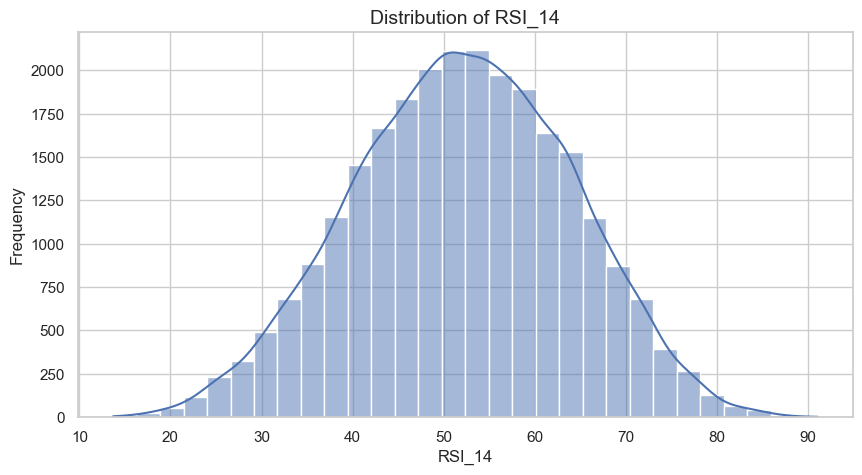

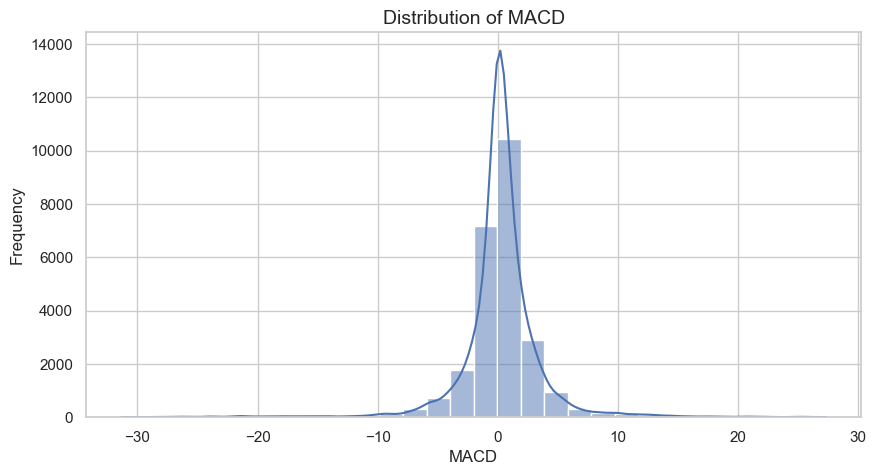

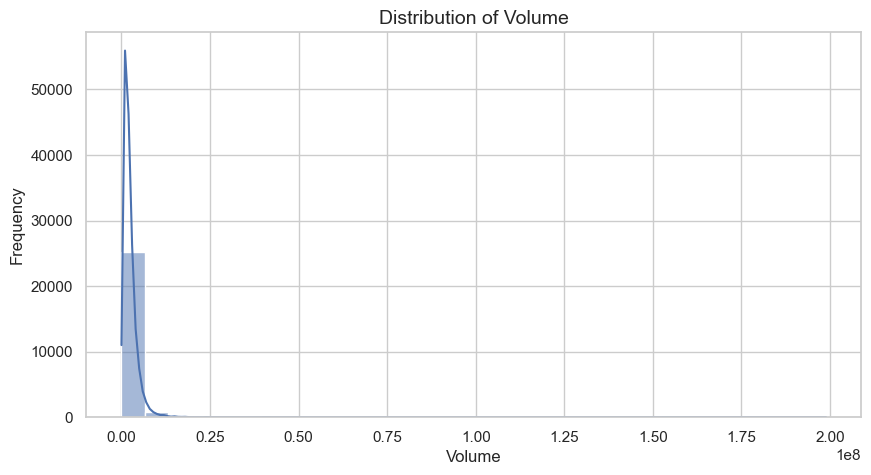

In [294]:
features = ['RSI_14', 'MACD', 'Volume']

for feature in features:
    plt.figure(figsize=(10, 5))
    
    sns.histplot(market_data[feature], kde=True, bins=30)
    
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#### 4) Generate a Correlation Heatmap to Spot Redundant Features
Highly correlated features can be redundant and may hurt certain models. Use a heatmap to visually inspect correlation between numerical features.
- **Resource**: [5 Minute EDA: Correlation Heatmap](https://medium.com/5-minute-eda/5-minute-eda-correlation-heatmap-b57bbb7bae14)

In [295]:
cont = market_data[keep]

# Compute each pair’s corr using *all* available overlapping data,
# requiring for example at least 200 observations to report a number
corr = cont.corr(min_periods=200)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12,10))
sns.heatmap(
    corr, mask=mask,
    cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5,
    cbar_kws={'label':'Pearson r'}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Among Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

NameError: name 'keep' is not defined

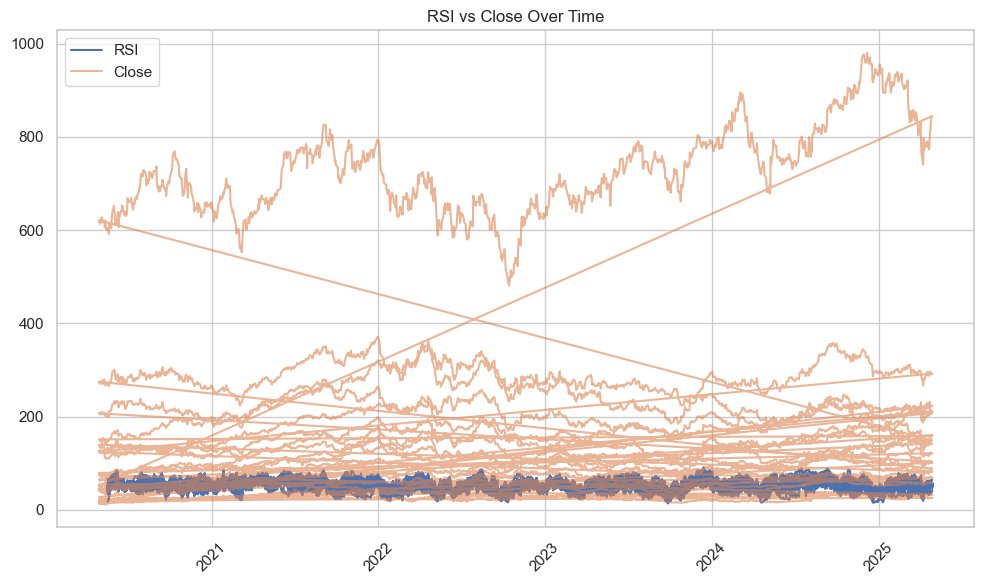

In [296]:
#How does RSI, MACD, or ATR behave before big price movements?
plt.plot(market_data['Date'], market_data['RSI_14'], label='RSI')
plt.plot(market_data['Date'], market_data['Close'], label='Close', alpha=0.6)
plt.legend()
plt.title("RSI vs Close Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 5) Check the Relationship Between Features and the Target
Explore how technical indicators relate to the target (next day’s close). Use scatter plots or group-by summaries to spot patterns.
- **Resource**: [Scatter plot with a grouping variable with Pandas](https://python-graph-gallery.com/537-scatter-plots-grouped-by-color-with-pandas/)

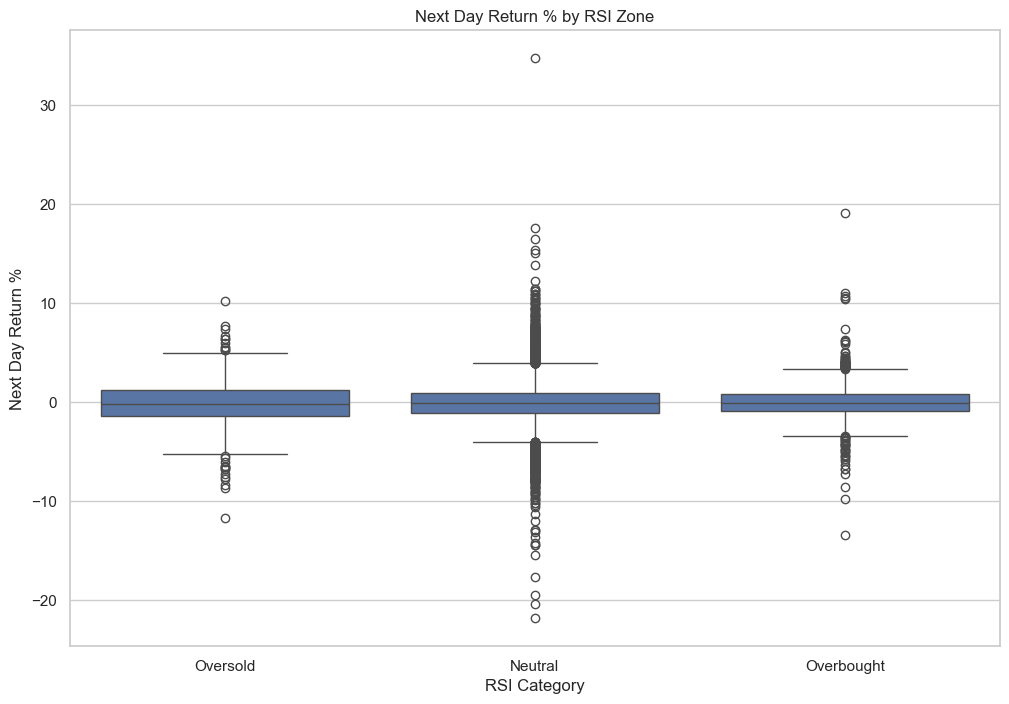

/var/folders/rl/vl9mfwqx4cv6y3dw2xb5gpbr0000gn/T/ipykernel_80558/3994603232.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = valid_data.groupby('RSI_Binned')['Target_Return'].agg(['mean', 'median', 'std', 'count'])



Average Next Day Returns by RSI Zone:
                mean    median       std  count
RSI_Binned                                     
Oversold   -0.118163 -0.153466  2.216281    890
Neutral    -0.025052 -0.068880  1.892421  23195
Overbought  0.029546 -0.025259  1.736862   1702


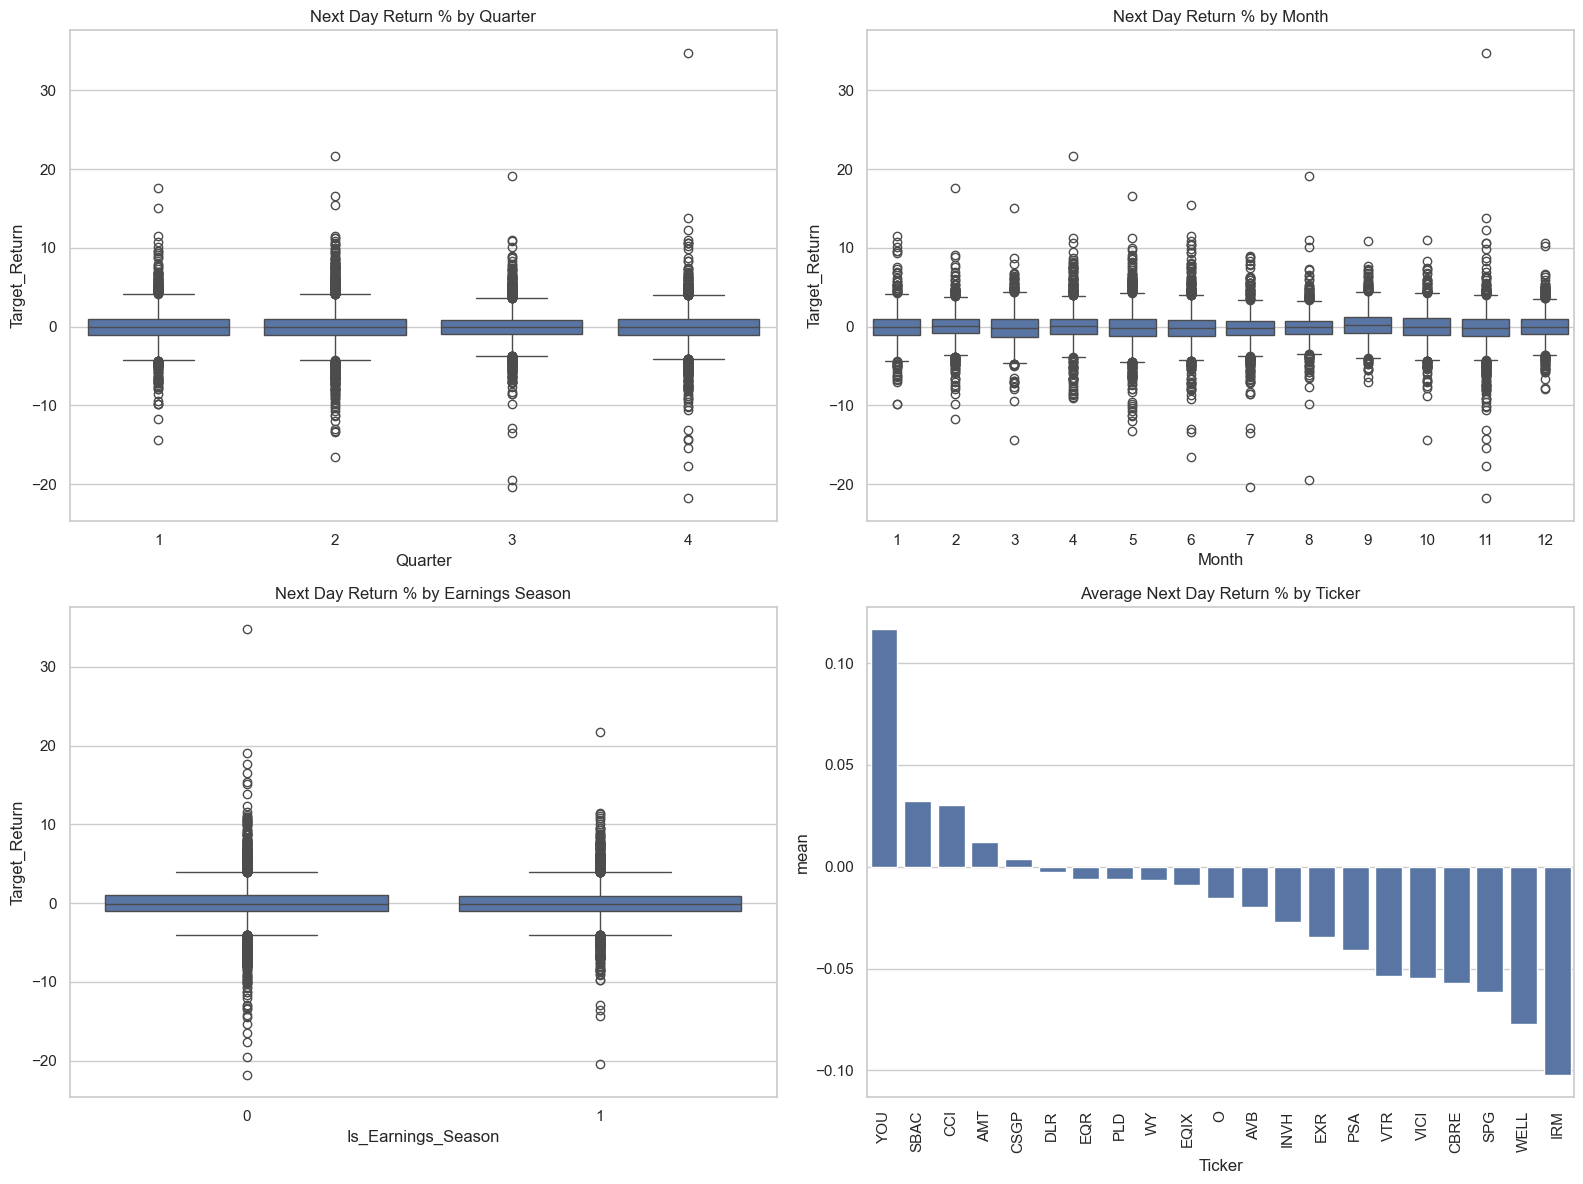

In [297]:

if 'RSI_14' not in market_data.columns:
    print("Warning: RSI_14 column not found in the dataset. Available columns are:")
    print(market_data.columns.tolist())
else:
    # Group by ticker to create the target variable correctly for each stock
    tickers = market_data['Ticker'].unique()
    result_frames = []

    for ticker in tickers:
        # Filter data for this ticker
        ticker_data = market_data[market_data['Ticker'] == ticker].copy()
        
        # Sort by date to ensure correct shifting
        ticker_data = ticker_data.sort_values('Date')
        
        # Create the target variable (next day's Close)
        ticker_data['Target'] = ticker_data['Close'].shift(-1)
        
        # Create the target return variable
        ticker_data['Target_Return'] = ticker_data['Close'].pct_change(periods=-1) * 100
        
        # Add to our results
        result_frames.append(ticker_data)

    # Combine all the data back together
    market_data_with_target = pd.concat(result_frames)
    
    # Now create RSI bins if possible
    if 'RSI_14' in market_data_with_target.columns:
        # Drop NaN values in RSI_14 before creating bins
        rsi_data = market_data_with_target.dropna(subset=['RSI_14'])
        
        # Check if we have any valid RSI data left
        if len(rsi_data) > 0:
            # Create RSI category bins
            market_data_with_target['RSI_Binned'] = pd.cut(
                market_data_with_target['RSI_14'],
                bins=[0, 30, 70, 100],
                labels=['Oversold', 'Neutral', 'Overbought']
            )
            
            # Create the plot with error handling
            plt.figure(figsize=(12, 8))
            valid_data = market_data_with_target.dropna(subset=['RSI_Binned', 'Target_Return'])
            
            if len(valid_data) > 0:
                sns.boxplot(x='RSI_Binned', y='Target_Return', data=valid_data)
                plt.title("Next Day Return % by RSI Zone")
                plt.xlabel("RSI Category")
                plt.ylabel("Next Day Return %")
                plt.show()
                
                # Calculate average returns by RSI zone across all tickers
                avg_returns = valid_data.groupby('RSI_Binned')['Target_Return'].agg(['mean', 'median', 'std', 'count'])
                print("\nAverage Next Day Returns by RSI Zone:")
                print(avg_returns)
            else:
                print("No valid data points with both RSI bins and Target Return")
        else:
            print("No valid RSI_14 data found (all values are NaN)")
    else:
        print("RSI_14 column not found in the processed data")
    
    # Let's try plotting returns by another feature that definitely exists
    plt.figure(figsize=(16, 12))
    
    # Plot returns by quarter
    plt.subplot(2, 2, 1)
    valid_data = market_data_with_target.dropna(subset=['Quarter', 'Target_Return'])
    if len(valid_data) > 0:
        sns.boxplot(x='Quarter', y='Target_Return', data=valid_data)
        plt.title("Next Day Return % by Quarter")
    else:
        plt.title("No valid data for Quarter analysis")
    
    # Plot returns by month
    plt.subplot(2, 2, 2)
    valid_data = market_data_with_target.dropna(subset=['Month', 'Target_Return'])
    if len(valid_data) > 0:
        sns.boxplot(x='Month', y='Target_Return', data=valid_data)
        plt.title("Next Day Return % by Month")
    else:
        plt.title("No valid data for Month analysis")
    
    # Plot returns by Is_Earnings_Season (if it exists)
    plt.subplot(2, 2, 3)
    if 'Is_Earnings_Season' in market_data_with_target.columns:
        valid_data = market_data_with_target.dropna(subset=['Is_Earnings_Season', 'Target_Return'])
        if len(valid_data) > 0:
            sns.boxplot(x='Is_Earnings_Season', y='Target_Return', data=valid_data)
            plt.title("Next Day Return % by Earnings Season")
        else:
            plt.title("No valid data for Earnings Season analysis")
    else:
        plt.title("Is_Earnings_Season column not found")
    
    # Show ticker performances for comparison
    plt.subplot(2, 2, 4)
    ticker_returns = market_data_with_target.groupby('Ticker')['Target_Return'].agg(['mean', 'std']).sort_values('mean', ascending=False)
    if len(ticker_returns) > 0:
        sns.barplot(x=ticker_returns.index, y=ticker_returns['mean'])
        plt.title("Average Next Day Return % by Ticker")
        plt.xticks(rotation=90)
    else:
        plt.title("No valid data for Ticker return analysis")
    
    plt.tight_layout()
    plt.show()

#### 6) Use Boxplots to Detect Outliers
- Boxplots are a great way to spot extreme values or outliers in numeric features. 
- Outliers can influence your model heavily — decide whether to keep, remove, or transform them.
- **Resource**: [How to detect outliers using IQR and Boxplots?](https://www.machinelearningplus.com/machine-learning/how-to-detect-outliers-using-iqr-and-boxplots/)

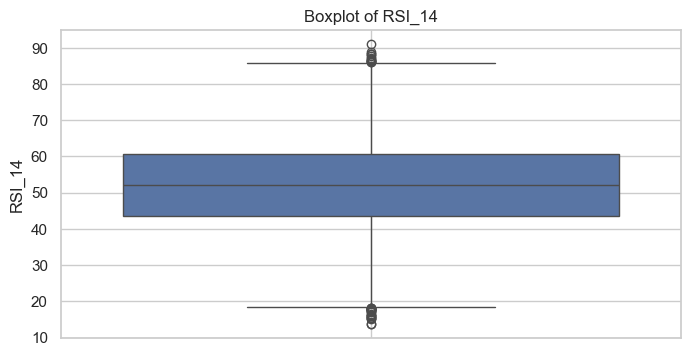

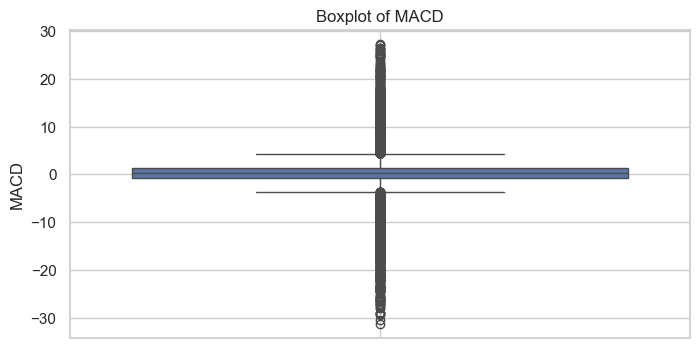

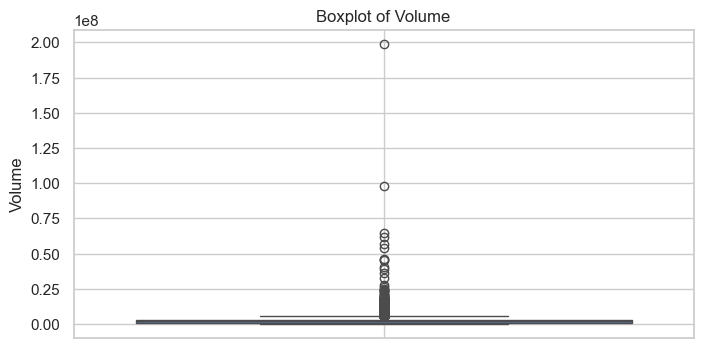

In [298]:
features_to_plot = ['RSI_14', 'MACD', 'Volume']

# Loop through each feature and plot a boxplot
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=market_data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.grid(True)
    plt.show()

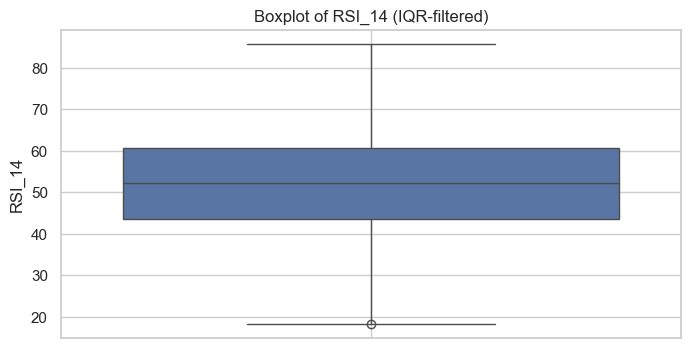

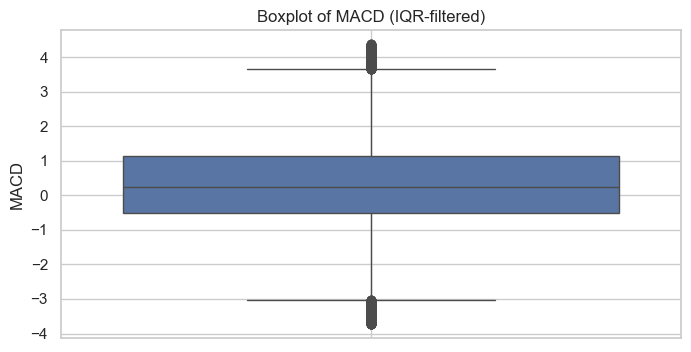

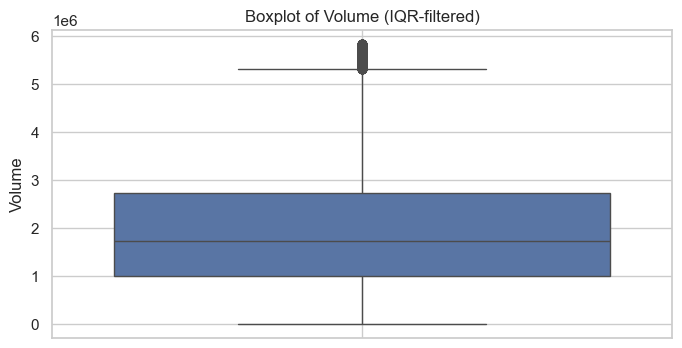

In [299]:
# Loop through each feature, filter using IQR, then plot
for feature in features_to_plot:
    Q1 = market_data[feature].quantile(0.25)
    Q3 = market_data[feature].quantile(0.75)
    IQR = Q3 - Q1

    # IQR filtering: keep only data within bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = market_data[(market_data[feature] >= lower_bound) & (market_data[feature] <= upper_bound)]

    # Plot boxplot of filtered data
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=filtered_df[feature])
    plt.title(f'Boxplot of {feature} (IQR-filtered)')
    plt.grid(True)
    plt.show()


#### 7) Investigate Patterns Over Time or Between Groups (Sector, Ticker, etc.)
- Use time-based plots to see if the target or indicators change by day of the week or over time.
- Grouped boxplots can help reveal differences between companies or sectors.
- **Resource**: [Python Plotting for Exploratory Data Analysis](https://pythonplot.com/)

In [300]:
# 1) Compute next‐day target within each ticker
market_data["Target"] = (
    market_data
      .sort_values(["Ticker","Date"])
      .groupby("Ticker")["Close"]
      .shift(-1)
)

# 2) Ensure Date is a proper datetime and drop any bad rows
if not pd.api.types.is_datetime64_any_dtype(market_data["Date"]):
    market_data["Date"] = pd.to_datetime(market_data["Date"], errors="coerce")

market_data = market_data.dropna(subset=["Date", "Target"])

/var/folders/rl/vl9mfwqx4cv6y3dw2xb5gpbr0000gn/T/ipykernel_80558/3509159857.py:18: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


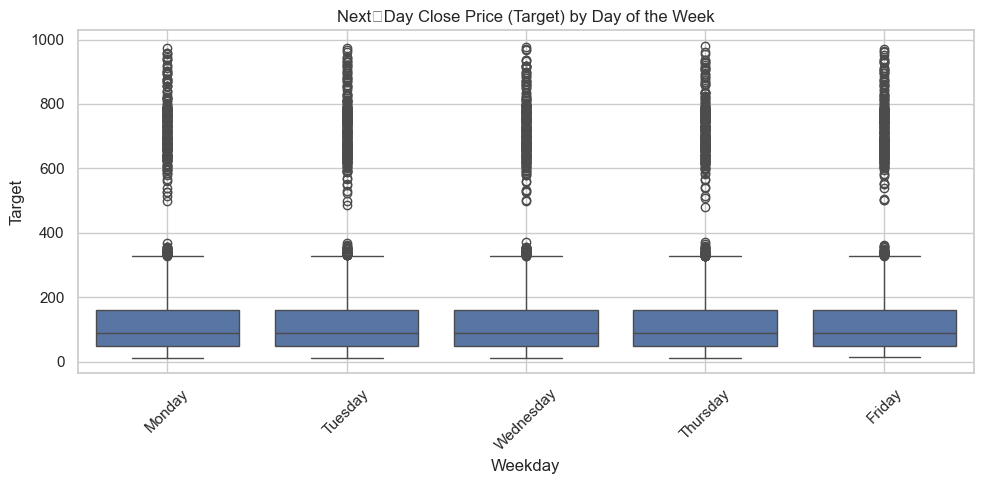

In [301]:
# 3) Extract weekday name
market_data["Weekday"] = market_data["Date"].dt.day_name()

# 4) Prepare dataframe for the boxplot
plot_df = market_data.dropna(subset=["Weekday","Target"])

# 5) Boxplot: Next‐Day Close by Day of the Week
plt.figure(figsize=(10,5))
sns.boxplot(
    data=plot_df,
    x="Weekday",
    y="Target",
    order=["Monday","Tuesday","Wednesday","Thursday","Friday"]
)
plt.title("Next‐Day Close Price (Target) by Day of the Week")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Available tickers: ['CBRE' 'PLD' 'AMT' 'WELL' 'EQIX' 'SPG' 'PSA' 'DLR' 'O' 'CCI' 'VICI' 'EXR'
 'CSGP' 'AVB' 'VTR' 'EQR' 'IRM' 'SBAC' 'WY' 'INVH' 'YOU']


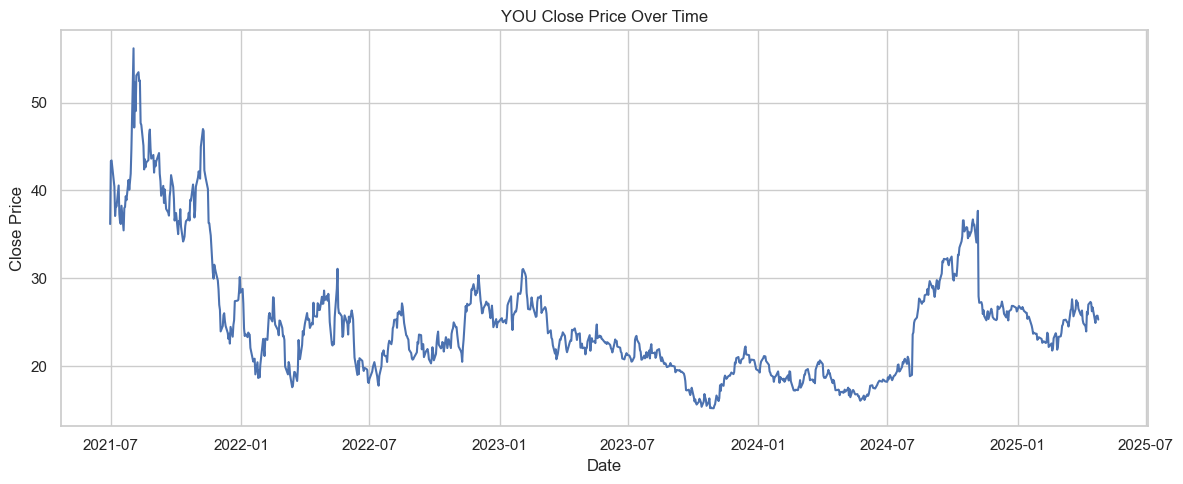

In [302]:
# 6) See which tickers you have
print("Available tickers:", market_data["Ticker"].unique())

# 7) Lineplot for one example ticker (e.g. 'YOU')
ticker = "YOU"
single_df = market_data[market_data["Ticker"] == ticker]

plt.figure(figsize=(12,5))
sns.lineplot(data=single_df, x="Date", y="Close")
plt.title(f"{ticker} Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [303]:
price_cols = ['Open','High','Low','Close','Volume']
tech_cols = ['SMA_20','EMA_20','RSI_14','MACD_Diff']
macro_cols = ['Unemployment','Inflation_CPI','Fed_Funds_Rate','GDP_Growth']

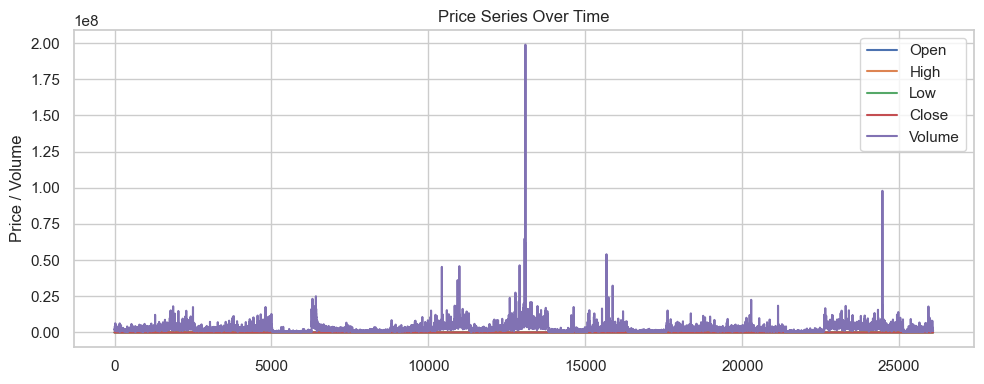

In [304]:
# --- Multi-line plot for prices ---
market_data[price_cols].plot(
    figsize=(10,4),
    title="Price Series Over Time"
)
plt.ylabel("Price / Volume")
plt.tight_layout()
plt.show()


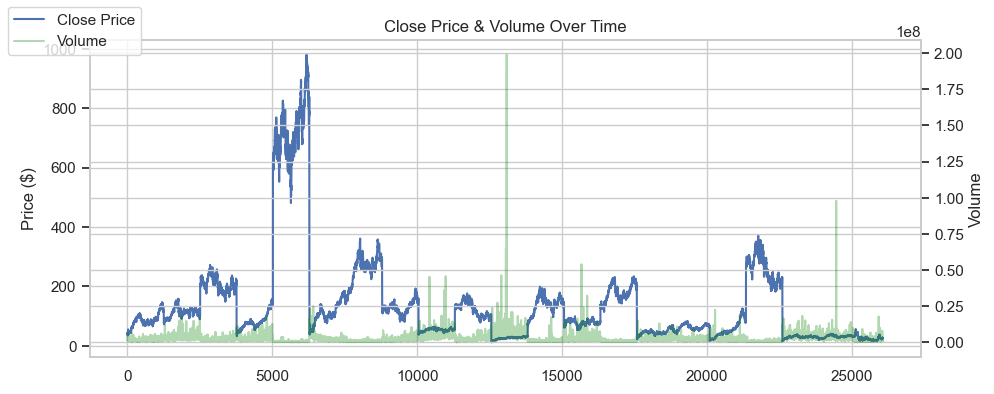

In [305]:
fig, ax1 = plt.subplots(figsize=(10,4))
# plot price on left axis
market_data['Close'].plot(ax=ax1, label='Close Price')
ax1.set_ylabel("Price ($)")
# plot volume on right axis
ax2 = ax1.twinx()
market_data['Volume'].plot(
    ax=ax2, 
    color='green', 
    alpha=0.3, 
    label='Volume'
)
ax2.set_ylabel("Volume")
fig.legend(loc='upper left')
plt.title("Close Price & Volume Over Time")
plt.tight_layout()
plt.show()

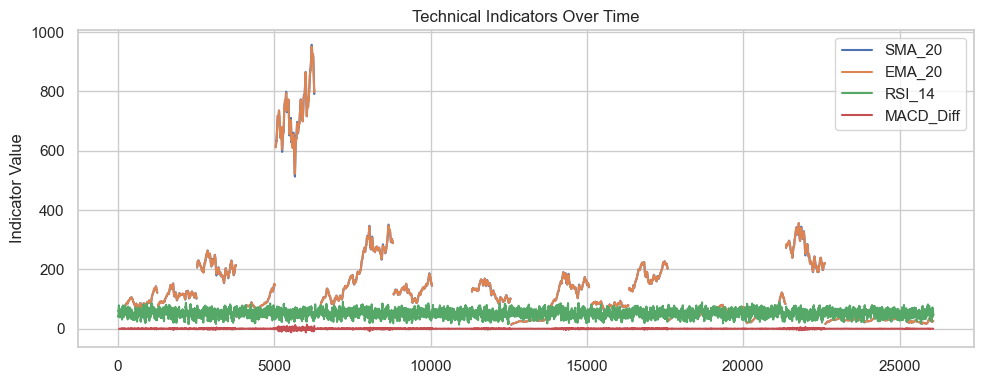

In [306]:

# --- Technical indicators ---
market_data[tech_cols].plot(
    figsize=(10,4),
    title="Technical Indicators Over Time"
)
plt.ylabel("Indicator Value")
plt.tight_layout()
plt.show()


In [307]:
print("Shape:", market_data.shape)
print("Columns:", market_data.columns.tolist())
print(market_data[macro_cols].head())
print(market_data[macro_cols].isna().sum())

Shape: (26060, 44)
Columns: ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'Typical_Price', 'VWAP', 'SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_Upper', 'BB_Lower', 'ATR', 'OBV', 'Rolling_Close_Mean_5', 'Rolling_Return_3', 'Unemployment', 'Inflation_CPI', 'Fed_Funds_Rate', 'GDP', '10Y_Treasury', 'Consumer_Sentiment', 'Retail_Sales', 'GDP_Growth', 'GDP_Growth_Lag1', 'Inflation_Lag1', 'Month', 'Quarter', 'Is_Earnings_Season', 'MACD_x_Inflation', 'Price_Range', 'Volatility_x_InterestRate', 'GDP_Previous', 'Is_GDP_Report_Month', 'GDP_Direction', 'Month_In_Quarter', 'Target', 'Weekday']
   Unemployment  Inflation_CPI  Fed_Funds_Rate  GDP_Growth
0          13.2        255.802            0.05         0.0
1          13.2        255.802            0.05         0.0
2          13.2        255.802            0.05         0.0
3          13.2        255.802            0.05         0.0
4          13.2        255.802            0.05         0.0
Un

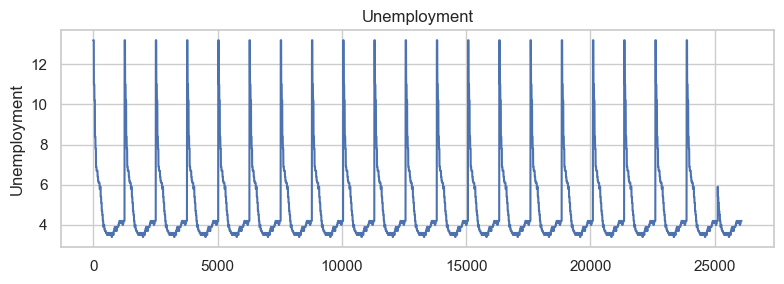

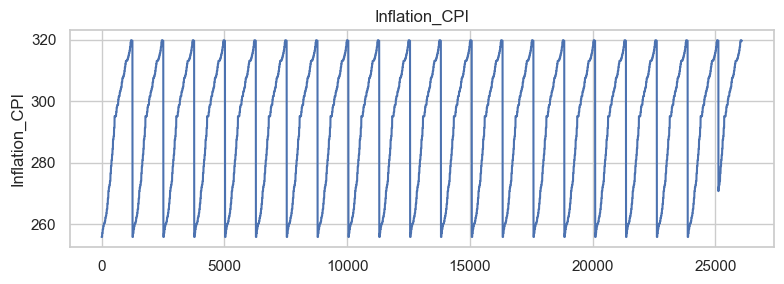

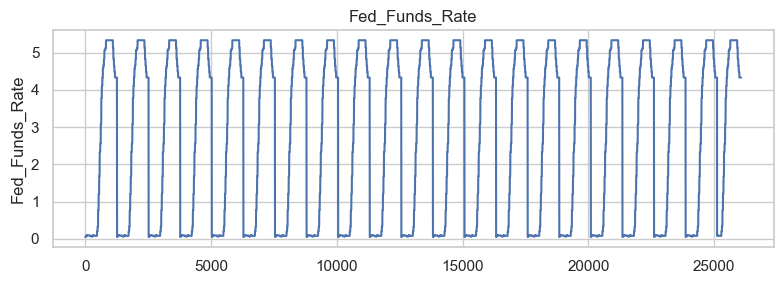

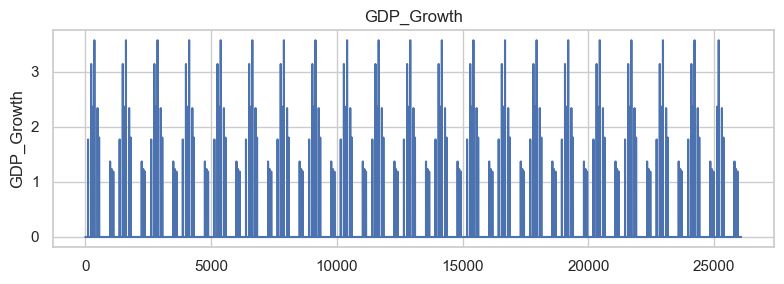

In [308]:
for col in macro_cols:
    plt.figure(figsize=(8,3))
    market_data[col].plot()
    plt.title(col)
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

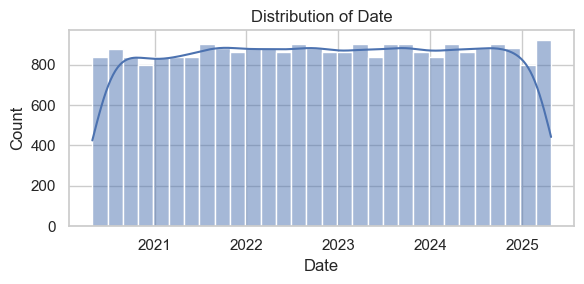

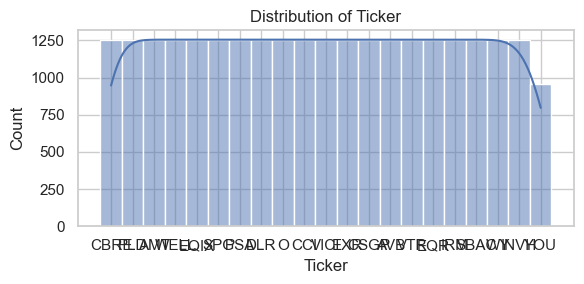

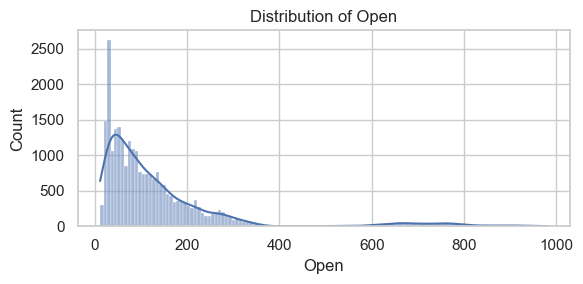

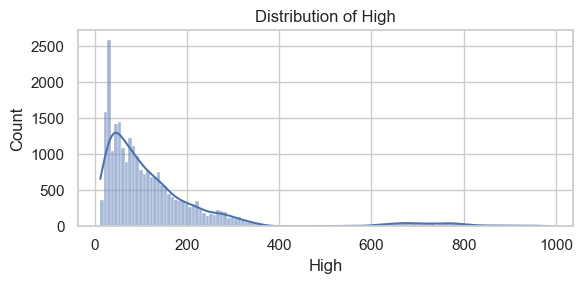

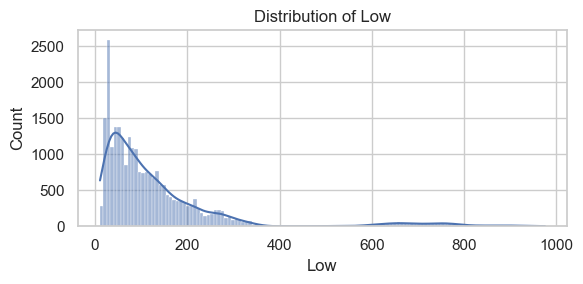

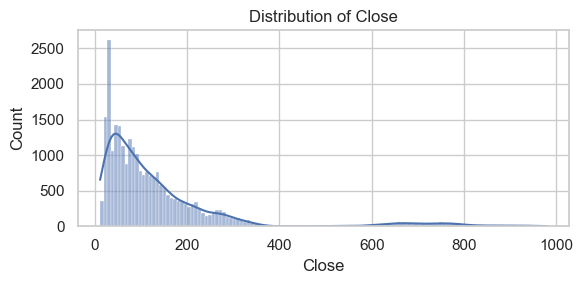

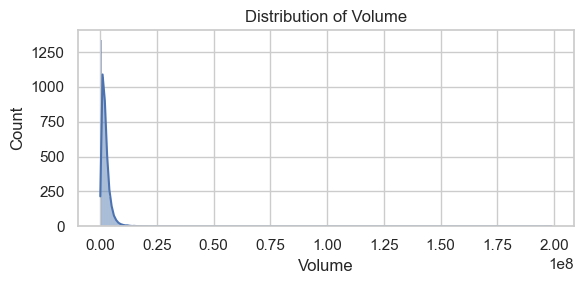

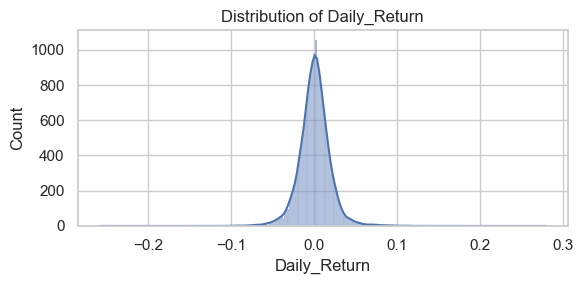

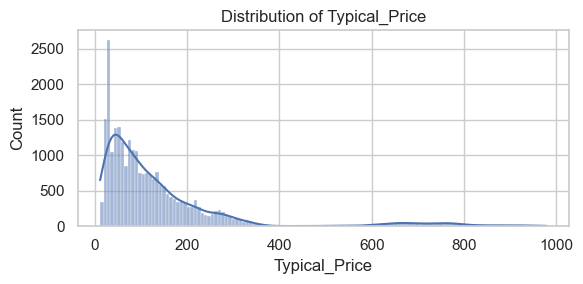

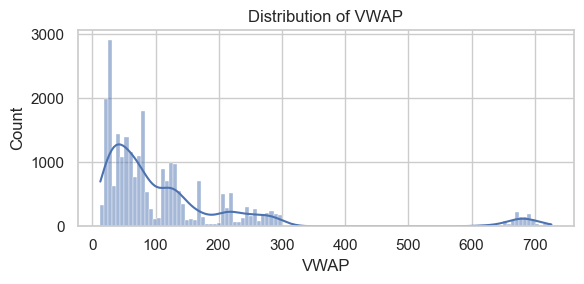

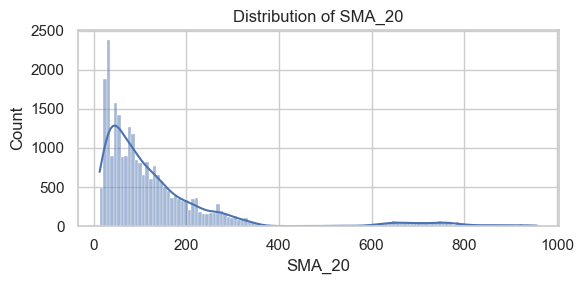

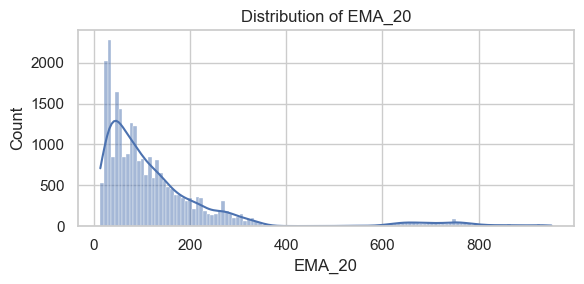

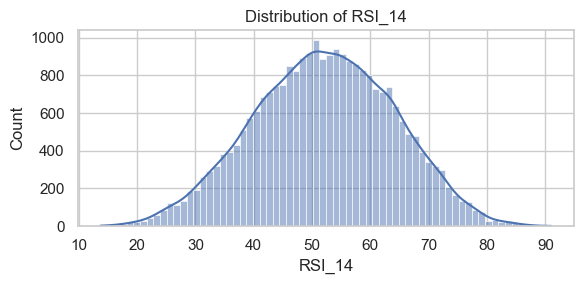

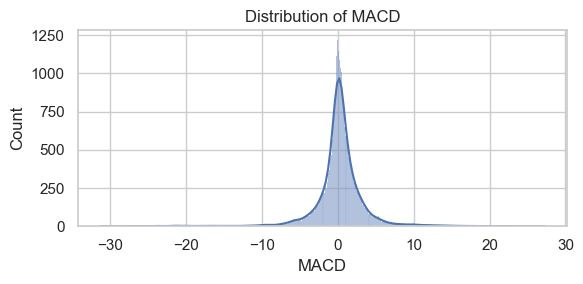

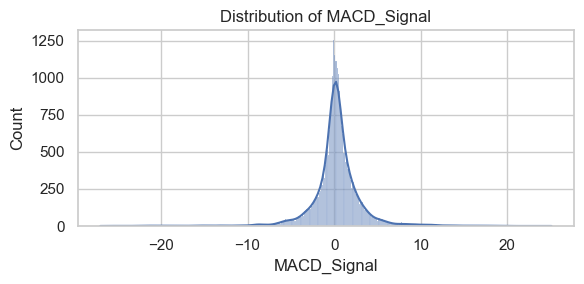

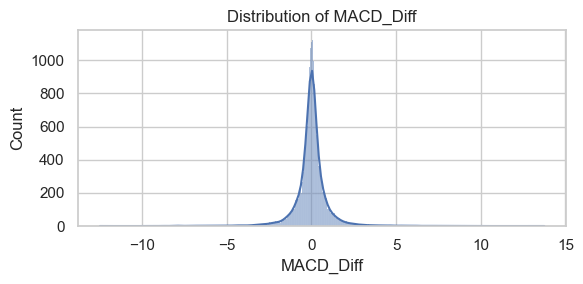

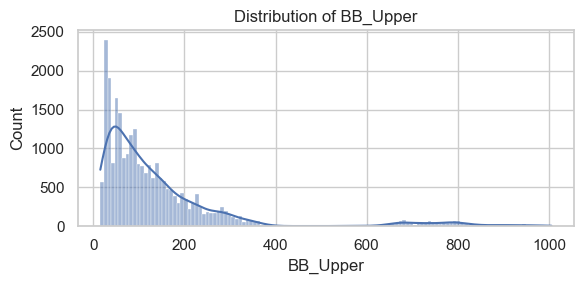

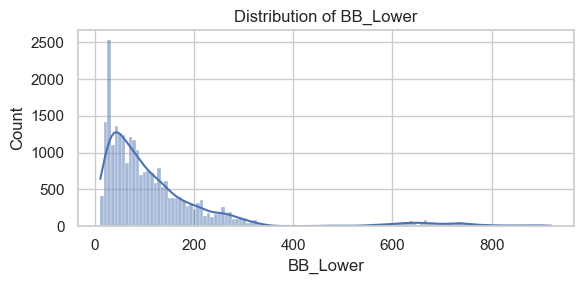

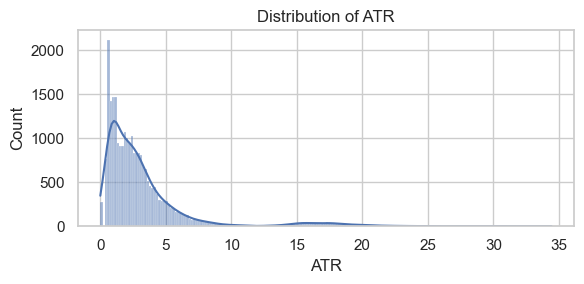

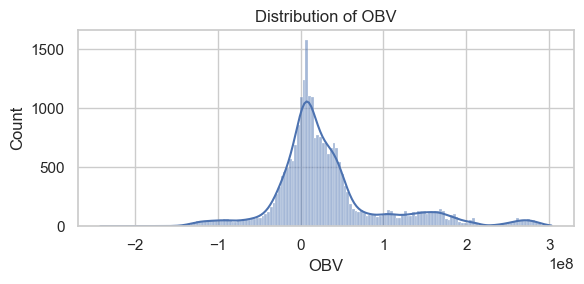

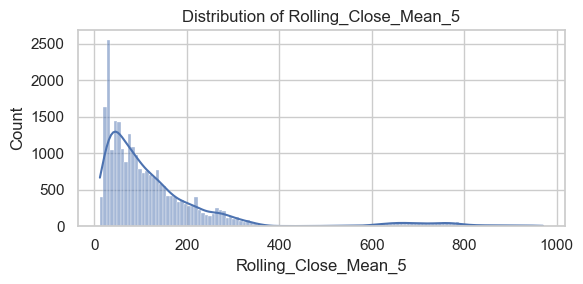

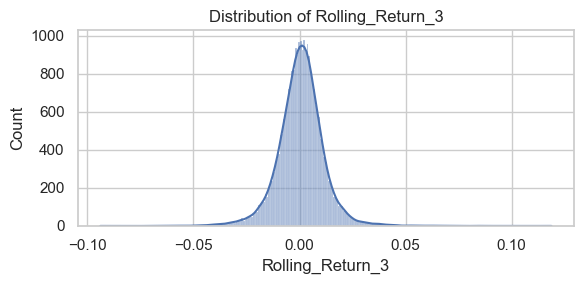

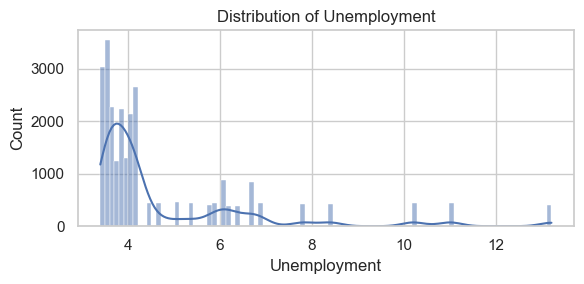

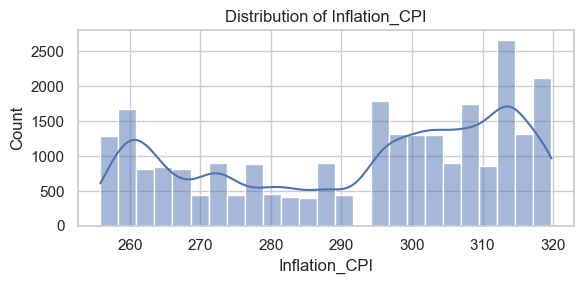

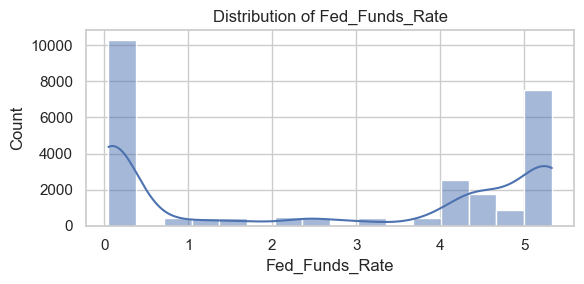

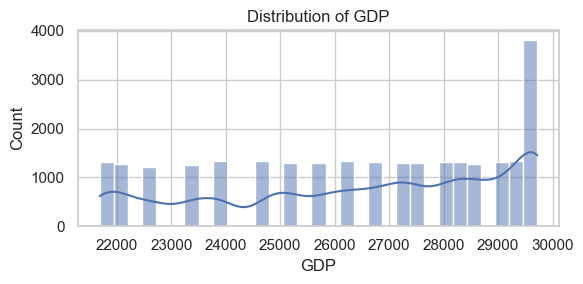

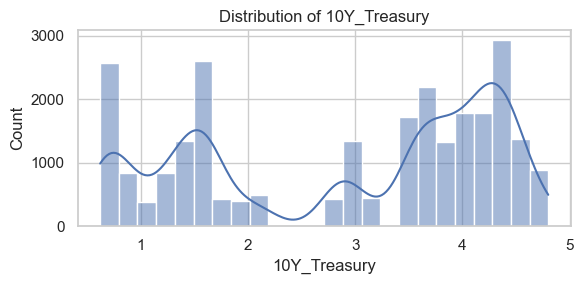

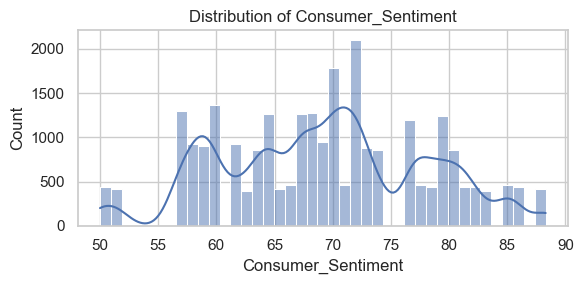

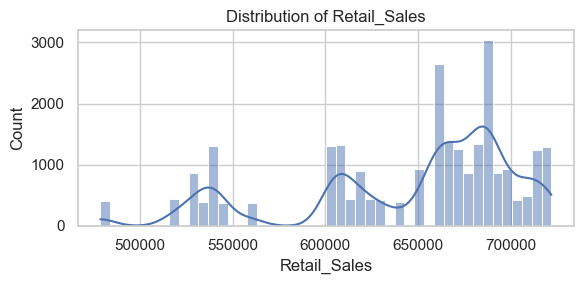

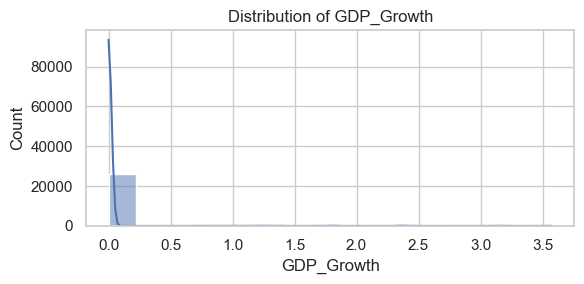

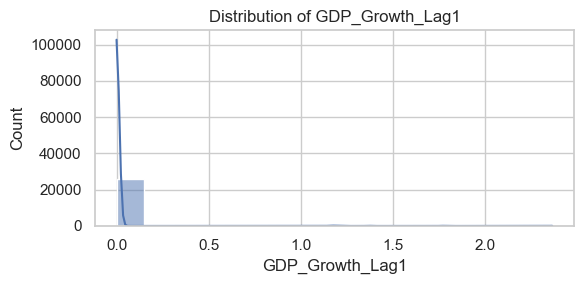

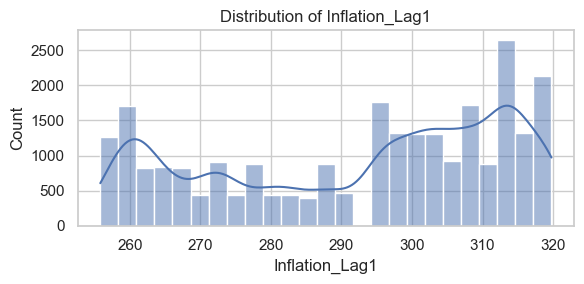

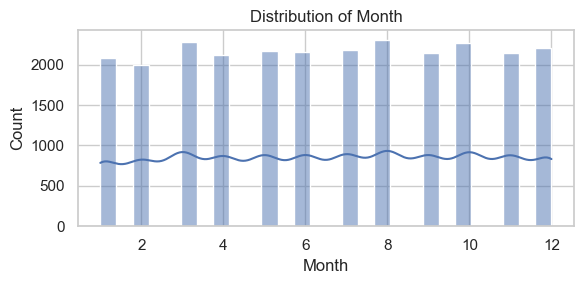

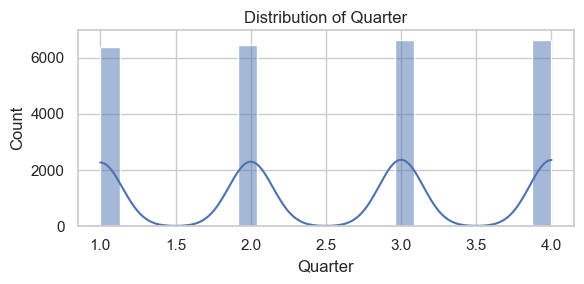

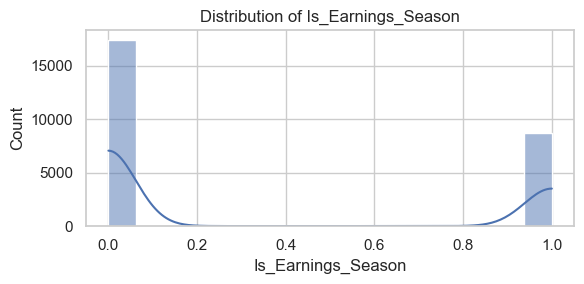

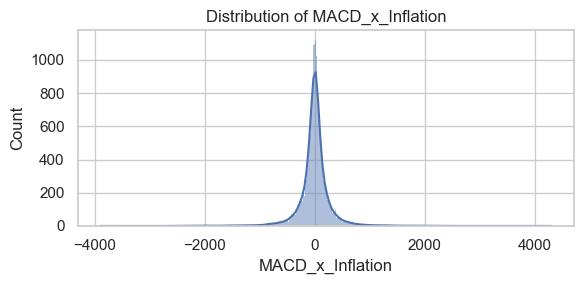

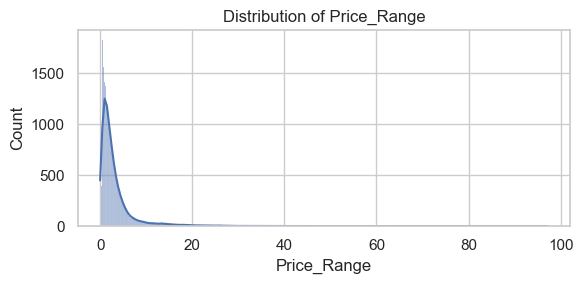

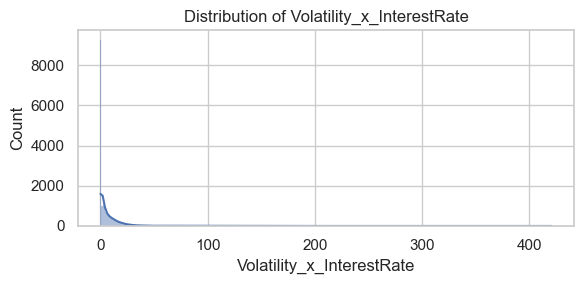

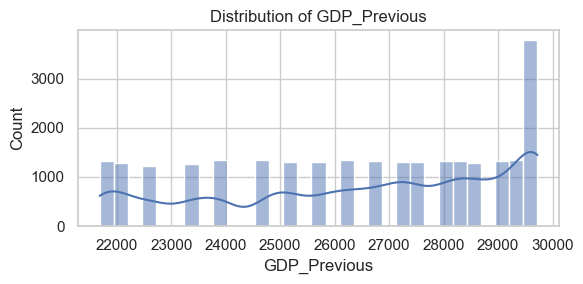

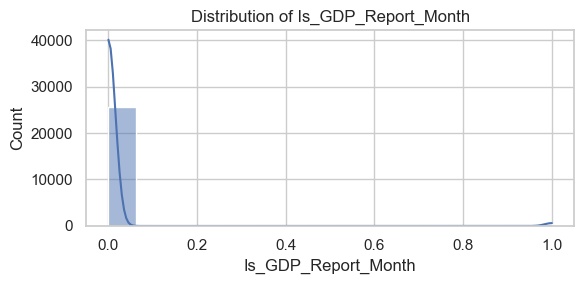

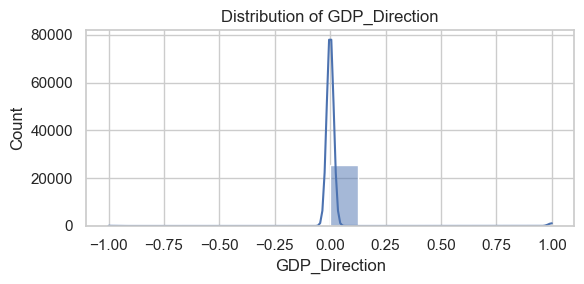

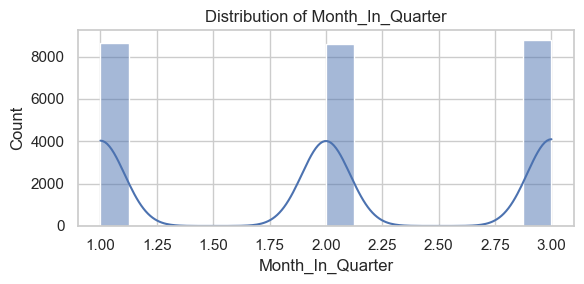

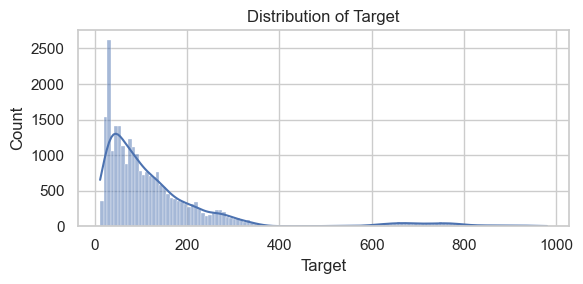

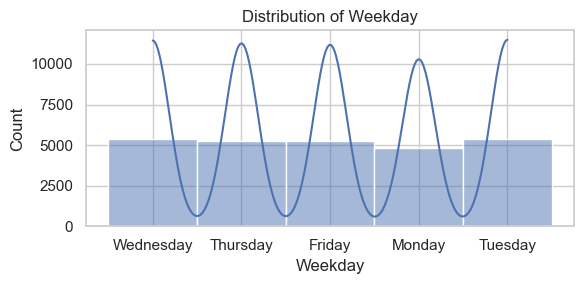

In [309]:
# --- Step E: Marginal distributions ---
for col in market_data.columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(market_data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [310]:
# --- Step G: Quick sanity prints ---
print("Daily_Return head & missing count:")
print(market_data['Daily_Return'].head())
print("Missing Daily_Return:", market_data['Daily_Return'].isna().sum())

print("\nTicker frequency:")
print(market_data['Ticker'].value_counts())

Daily_Return head & missing count:
0         NaN
1   -0.044301
2   -0.075239
3   -0.007809
4    0.005077
Name: Daily_Return, dtype: float64
Missing Daily_Return: 21

Ticker frequency:
Ticker
CBRE    1255
PLD     1255
AMT     1255
WELL    1255
EQIX    1255
SPG     1255
PSA     1255
DLR     1255
O       1255
CCI     1255
VICI    1255
EXR     1255
CSGP    1255
AVB     1255
VTR     1255
EQR     1255
IRM     1255
SBAC    1255
WY      1255
INVH    1255
YOU      960
Name: count, dtype: int64


In [311]:
# --- 1) Build a mini econ-only DataFrame (one row per date) ---
econ = (
    market_data
      .loc[:, ['Date','Unemployment','Inflation_CPI','Fed_Funds_Rate','GDP']]
      .drop_duplicates('Date')   # one row per calendar day
      .sort_values('Date')
      .reset_index(drop=True)
)

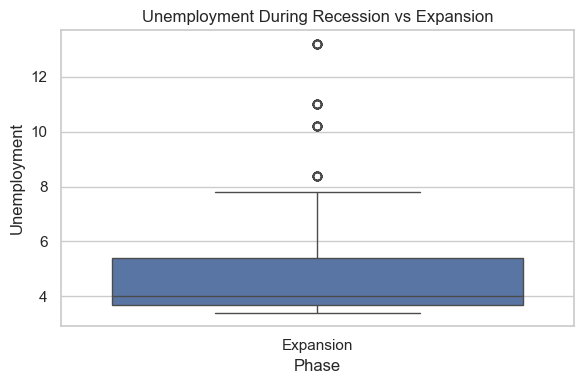

In [312]:
# GDP Growth & phase
econ['GDP_Growth'] = econ['GDP'].pct_change()
econ.dropna(subset=['GDP_Growth'], inplace=True)
econ['Phase'] = econ['GDP_Growth'].apply(lambda x: 'Recession' if x < 0 else 'Expansion')

# ---- Boxplot: Unemployment in Recession vs Expansion ----
plt.figure(figsize=(6,4))
sns.boxplot(data=econ, x='Phase', y='Unemployment')
plt.title("Unemployment During Recession vs Expansion")
plt.tight_layout()
plt.show()

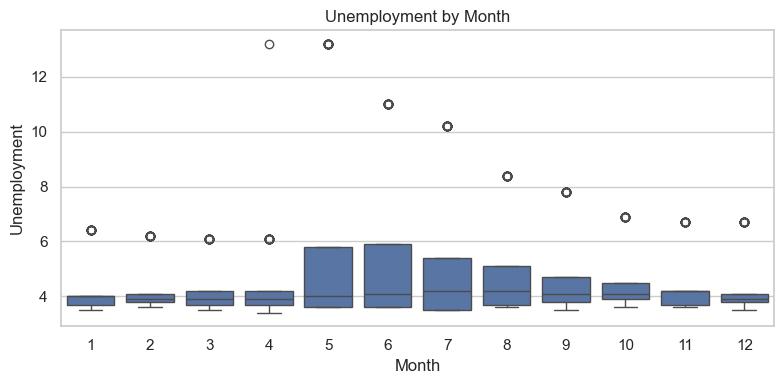

In [313]:
# Month of year
econ['Month'] = econ['Date'].dt.month

# ---- Boxplot: Unemployment by Month ----
plt.figure(figsize=(8,4))
sns.boxplot(data=econ, x='Month', y='Unemployment')
plt.title("Unemployment by Month")
plt.tight_layout()
plt.show()

#### 8) Brainstorm & Engineer New Features Based on Your Insights
- Consider creating features like price range, volatility, lagged prices, or differences from moving averages.
- These can help capture patterns not directly visible in raw features.
- **Resource**: [A Reference Guide to Feature Engineering](https://www.kaggle.com/code/prashant111/a-reference-guide-to-feature-engineering-methods)

In [314]:
# MACD diff & interaction with inflation
market_data['MACD_diff']         = market_data['MACD'] - market_data['MACD_Signal']
market_data['MACD_x_Inflation']  = market_data['MACD_diff'] * market_data['Inflation_CPI']

In [315]:
# Price range & interaction with Fed funds
market_data['Price_Range']               = market_data['High'] - market_data['Low']
market_data['Volatility_x_InterestRate'] = (
    market_data['Price_Range'] * market_data['Fed_Funds_Rate']
)

In [316]:
# Lagged macro features
market_data['Date_only'] = market_data['Date'].dt.date
market_data['Inflation_Lag1'] = market_data['Inflation_CPI'].shift(1)
market_data['GDP_Growth_Lag1'] = market_data['GDP_Growth'].shift(1)

In [317]:
market_data['Month'] = market_data['Date'].dt.month
market_data['Quarter'] = market_data['Date'].dt.quarter
market_data['Is_Earnings_Season'] = market_data['Month'].isin([1, 4, 7, 10]).astype(int)

# --- 3) Compute rolling features per Ticker ---
# 5-day rolling mean of Close
market_data['Rolling_Close_Mean_5'] = (
    market_data
      .sort_values(['Ticker','Date'])
      .groupby('Ticker')['Close']
      .rolling(window=5, min_periods=1)  # min_periods=1 if you want partial windows at start
      .mean()
      .reset_index(level=0, drop=True)
)

# 3-day rolling mean of 1-day pct_return
market_data['Rolling_Return_3'] = (
    market_data
      .sort_values(['Ticker','Date'])
      .groupby('Ticker')['Close']
      .pct_change()
      .rolling(window=3, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)

In [318]:
new_feats = [
    'MACD_diff', 'MACD_x_Inflation',
    'Price_Range', 'Volatility_x_InterestRate',
    'Inflation_Lag1', 'GDP_Growth_Lag1',
    'Month', 'Quarter', 'Is_Earnings_Season',
    'Rolling_Close_Mean_5', 'Rolling_Return_3'
]

# 2) Check that they’re all in your columns
missing = [f for f in new_feats if f not in market_data.columns]
if missing:
    print("❌ Missing these columns:", missing)
else:
    print("✅ All new features are present!")

# 3) Peek at their first few values
market_data[new_feats].head(10)

✅ All new features are present!


MACD_diff  MACD_x_Inflation  Price_Range  Volatility_x_InterestRate  \
0        NaN               NaN     2.449997                     0.1225   
1        NaN               NaN     1.320000                     0.0660   
2        NaN               NaN     2.590000                     0.1295   
3        NaN               NaN     0.970001                     0.0485   
4        NaN               NaN     1.870003                     0.0935   
5        NaN               NaN     2.450001                     0.1225   
6        NaN               NaN     3.630001                     0.1815   
7        NaN               NaN     1.139999                     0.0570   
8        NaN               NaN     0.709999                     0.0355   
9        NaN               NaN     3.809998                     0.1905   

   Inflation_Lag1  GDP_Growth_Lag1  Month  Quarter  Is_Earnings_Season  \
0             NaN              NaN      4        2                   1   
1         255.802              0.0      4        2                   1   
2         255.802              0.0      5        2                   0   
3         255.802              0.0      5        2                   0   
4         255.802              0.0      5        2                   0   
5         255.802              0.0      5        2                   0   
6         255.802              0.0      5        2                   0   
7         255.802              0.0      5        2                   0   
8         255.802              0.0      5        2                   0   
9         255.802              0.0      5        2                   0   

   Rolling_Close_Mean_5  Rolling_Return_3  
0             44.919998               NaN  
1             43.924999          0.005025  
2             42.516666         -0.005471  
3             41.735000         -0.000189  
4             41.306000          0.003250  
5             39.952000          0.004410  
6             39.544000         -0.001873  
7             39.924000         -0.002579  
8             40.210000          0.001401  
9             39.732000         -0.004926

In [319]:
market_data.columns

Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Daily_Return', 'Typical_Price', 'VWAP', 'SMA_20', 'EMA_20', 'RSI_14',
       'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_Upper', 'BB_Lower', 'ATR',
       'OBV', 'Rolling_Close_Mean_5', 'Rolling_Return_3', 'Unemployment',
       'Inflation_CPI', 'Fed_Funds_Rate', 'GDP', '10Y_Treasury',
       'Consumer_Sentiment', 'Retail_Sales', 'GDP_Growth', 'GDP_Growth_Lag1',
       'Inflation_Lag1', 'Month', 'Quarter', 'Is_Earnings_Season',
       'MACD_x_Inflation', 'Price_Range', 'Volatility_x_InterestRate',
       'GDP_Previous', 'Is_GDP_Report_Month', 'GDP_Direction',
       'Month_In_Quarter', 'Target', 'Weekday', 'MACD_diff', 'Date_only'],
      dtype='object')

In [320]:
market_data.head()

Date Ticker       Open       High        Low      Close   Volume  \
0 2020-04-29   CBRE  43.619999  45.099998  42.650002  44.919998  2025500   
1 2020-04-30   CBRE  44.000000  44.000000  42.680000  42.930000  2125400   
2 2020-05-01   CBRE  41.660000  41.849998  39.259998  39.700001  2208000   
3 2020-05-04   CBRE  38.689999  39.520000  38.549999  39.389999  1718600   
4 2020-05-05   CBRE  40.290001  41.400002  39.529999  39.590000  2423600   

   Daily_Return  Typical_Price       VWAP  ...  Price_Range  \
0           NaN      44.223333  44.223333  ...     2.449997   
1     -0.044301      43.203334  43.701059  ...     1.320000   
2     -0.075239      40.269999  42.509693  ...     2.590000   
3     -0.007809      39.153333  41.795581  ...     0.970001   
4      0.005077      40.173333  41.421174  ...     1.870003   

   Volatility_x_InterestRate  GDP_Previous  Is_GDP_Report_Month  \
0                     0.1225           NaN                    1   
1                     0.0660     21684.551                    0   
2                     0.1295     21684.551                    0   
3                     0.0485     21684.551                    0   
4                     0.0935     21684.551                    0   

   GDP_Direction  Month_In_Quarter     Target    Weekday  MACD_diff  \
0            NaN                 1  42.930000  Wednesday        NaN   
1            0.0                 1  39.700001   Thursday        NaN   
2            0.0                 2  39.389999     Friday        NaN   
3            0.0                 2  39.590000     Monday        NaN   
4            0.0                 2  38.150002    Tuesday        NaN   

    Date_only  
0  2020-04-29  
1  2020-04-30  
2  2020-05-01  
3  2020-05-04  
4  2020-05-05  

[5 rows x 46 columns]

### Modeling Instructions

#### LSTM Model
##### Understanding LSTM (Long Short-Term Memory)
**Long Short-Term Memory (LSTM)** networks are a special type of Recurrent Neural Network (RNN) designed to learn from sequential or time-series data. What sets LSTMs apart is their ability to retain information over long periods, making them powerful for understanding patterns that unfold over time.
- They are particularly effective for time series forecasting because they:
- Remember past values across long sequences (even hundreds of time steps)
- Can detect patterns in how values evolve over time
- Learn temporal dependencies that traditional models may miss

##### Why LSTM Is Applicable to Our Stock Model
Stock prices are naturally time-dependent; today's price is influenced by the prices of the last few days, weeks, or even months. But the market is also affected by:
- Momentum indicators (like MACD, RSI)
- Macroeconomic shifts (like inflation or interest rates)
- Recurring cycles (e.g., earnings seasons, market open/close trends)
  
LSTMs can capture all of these by:
- Learning how patterns in historical stock prices and technical indicators impact future prices
- Taking in multiple features (multivariate inputs), such as economic indicators, volume, and volatility
- Understanding nonlinear relationships and subtle dependencies that traditional models like ARIMA or Prophet might miss

##### 1. Import Necessary Libraries

**scikit-learn:** A go-to library for classic Machine Learning in Python. We’ll rely on it for:
Data preprocessing
- Scaling our inputs (e.g. MinMaxScaler) so every feature lives on the same 0→1 range before feeding into the LSTM.
- Train/test splitting (train_test_split) or simple cross-validation if we want quick baselines.

Baseline models & utilities
- We can spin up a quick regression (e.g. linear, random forest) to compare against our LSTM.
- Metrics such as RMSE, R², classification accuracy, etc., via sklearn.metrics.

Pipeline tools
- If we want to chain scaling, feature-selection, and a model into a single reusable object, the Pipeline abstraction makes that easy.

*In short:* scikit-learn handles all of the “standard ML” chores—cleaning, splitting, evaluating—and lets us focus TensorFlow on the deep-learning side.

**TensorFlow (with Keras):** Google’s end-to-end platform for building and training neural networks. In our project we’ll use it to:

Define our LSTM architecture
- Stack one or more LSTM layers to learn temporal patterns in stock prices plus technical/macro indicators.
- Add final Dense layers to regress on next-day price.

Efficient training
- Take advantage of GPU acceleration (if available) to quickly run back-prop through hundreds of thousands of time-steps.
- Monitor training/validation loss, checkpoint models, and adjust hyperparameters on the fly.

*In short:* TensorFlow is our workhorse for any deep-learning component—here, the LSTM—that goes beyond what classical scikit-learn models can capture.

In [108]:
!pip install scikit-learn
!pip install tensorflow


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [321]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense   # ← add Dropout here
from tensorflow.keras.callbacks import EarlyStopping

##### 2. Choose Your Input Features
You have ~46 columns in market_data, but LSTMs work best when you feed them only the signals that matter. My recommendation:
- Always include your “target” — e.g. next-day Close (or Target if you shifted it).
- Price features: Close, maybe Volume (if you think volume drives momentum), and one or two moving averages or momentum indicators like MACD_diff or RSI_14.
- Macro features: if you want multivariate forecasting, include the daily‐forward‐filled series for Inflation_CPI, Fed_Funds_Rate, and GDP_Growth.
- Cyclical flags: Is_Earnings_Season or one-hot encode Month if you think seasonality helps.

In [106]:
features = [
  'Close',
  'Volume',          
  'Rolling_Close_Mean_5', 
  'MACD_diff', 
  'RSI_14', 
  'Inflation_CPI', 
  'Fed_Funds_Rate', 
  'GDP_Growth', 
  'Is_Earnings_Season'
]
target = 'Target'    # Next-day's close

##### 3. Extract & Scale Your Data

In [278]:
from sklearn.preprocessing import MinMaxScaler

# 1) Subset to your features + target, sort by date
df = market_data.sort_values('Date').reset_index(drop=True)
data = df[features + [target]].dropna()

# 2) Scale into [0,1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data.values)  
# shape = (n_samples, len(features)+1)

# 3) Split back into X and y
X_all = scaled[:, :-1]     # every column except last
y_all = scaled[:, -1]      # the last column is the target


##### 4. Create Sequences

In [41]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 60  # e.g. 60 trading days (≈3mo)
X, y = create_sequences(X_all, y_all, seq_length)

##### 5. Train and Test Split

In [42]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


##### 6. Build the LSTM Model

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

# number of features in your X (e.g. the width of each time step)
n_features = X_train.shape[2]  
# length of each sequence
seq_length = X_train.shape[1]   

model = Sequential()
# 1) Input layer
model.add(Input(shape=(seq_length, n_features)))

# 2) Stacked LSTM layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))

# 3) Final regression output
model.add(Dense(1))

# 4) Compile
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)

##### 7. Train the Model

In [44]:
# --- Step 7: Train the Model ---
history = model.fit(
    X_train, 
    y_train,
    epochs=50,           # you can bump this up or down
    batch_size=32,
    validation_split=0.1,
    verbose=2
)

Epoch 1/50
549/549 - 14s - 25ms/step - loss: 0.0238 - val_loss: 0.0282
Epoch 2/50
549/549 - 13s - 24ms/step - loss: 0.0231 - val_loss: 0.0280
Epoch 3/50
549/549 - 11s - 21ms/step - loss: 0.0229 - val_loss: 0.0279
Epoch 4/50
549/549 - 11s - 20ms/step - loss: 0.0229 - val_loss: 0.0281
Epoch 5/50
549/549 - 11s - 20ms/step - loss: 0.0228 - val_loss: 0.0276
Epoch 6/50
549/549 - 10s - 19ms/step - loss: 0.0228 - val_loss: 0.0277
Epoch 7/50
549/549 - 10s - 19ms/step - loss: 0.0227 - val_loss: 0.0274
Epoch 8/50
549/549 - 13s - 24ms/step - loss: 0.0227 - val_loss: 0.0275
Epoch 9/50
549/549 - 12s - 22ms/step - loss: 0.0226 - val_loss: 0.0273
Epoch 10/50
549/549 - 13s - 23ms/step - loss: 0.0226 - val_loss: 0.0275
Epoch 11/50
549/549 - 12s - 22ms/step - loss: 0.0226 - val_loss: 0.0273
Epoch 12/50
549/549 - 11s - 21ms/step - loss: 0.0226 - val_loss: 0.0282
Epoch 13/50
549/549 - 11s - 21ms/step - loss: 0.0226 - val_loss: 0.0279
Epoch 14/50
549/549 - 13s - 24ms/step - loss: 0.0225 - val_loss: 0.0273
E

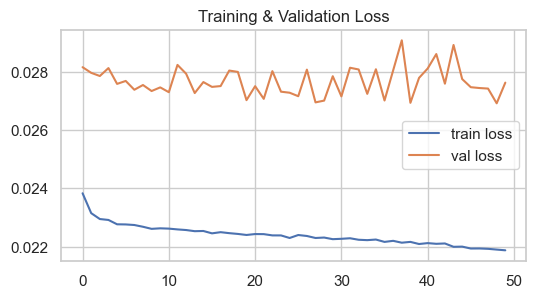

In [45]:
# (Optional) plot the loss curve
plt.figure(figsize=(6,3))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

##### 8. Make Predictions & Inverse‐Transform

In [46]:
# --- Step 8: Make Predictions & Inverse‐Transform ---
#  8a) predict (scaled)
y_pred_scaled = model.predict(X_test)

#  8b) reconstruct a dummy matrix to call scaler.inverse_transform()
n_feats = len(features)  # number of input columns you used
dummy_preds = np.zeros((len(y_pred_scaled), n_feats))
recombined_pred = np.hstack([dummy_preds, y_pred_scaled])  # last col is your target
y_pred = scaler.inverse_transform(recombined_pred)[:, -1]  # pull out the last column

#  8c) same for y_test
dummy_true = np.zeros((len(y_test), n_feats))
recombined_true = np.hstack([dummy_true, y_test.reshape(-1,1)])
y_true = scaler.inverse_transform(recombined_true)[:, -1]

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


##### 9. Evaluate the Model

In [47]:
# --- Step 9: Evaluate the Model ---
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 177.09


##### 10. Plot the Results

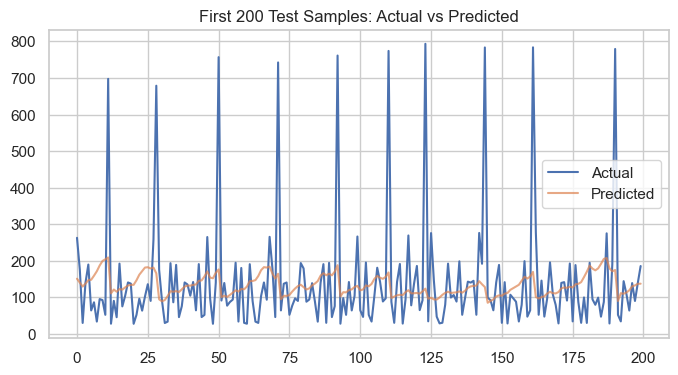

In [48]:
# (Optional) Plot a few predictions vs actuals
plt.figure(figsize=(8,4))
plt.plot(y_true[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted', alpha=0.7)
plt.legend()
plt.title("First 200 Test Samples: Actual vs Predicted")
plt.show()

#### LSTM Modeling - Better Approach

#### LSTM Stock-Prediction Pipeline Explained

#### 1) Configuration

```python
features = [
    'Close', 'Volume',
    'Rolling_Close_Mean_5', 'MACD_diff', 'RSI_14',
    'Inflation_CPI', 'Fed_Funds_Rate', 'GDP_Growth',
    'Is_Earnings_Season'
]
target = 'Target'
seq_length = 60
test_split = 0.2
```

- **`features`**: a list of the columns we’ll feed into the LSTM as inputs at each time step.  
  - Price data (`Close`, `Volume`), technical indicators (`MACD_diff`, `RSI_14`), and macro series (`Inflation_CPI`, etc.).  
- **`target`**: the column we’re trying to predict one day ahead. We built this earlier via  
  ```python
  market_data['Target'] = market_data.groupby('Ticker')['Close'].shift(-1)
  ```  
- **`seq_length`**: how many past days we pass into the LSTM to predict the next day. Here we use 60 (≈3 months of trading).  
- **`test_split`**: fraction of our sequences held out as a test set (20%).

---

#### 2) `run_lstm_for_ticker(df, ticker)`

A **helper function** that encapsulates all the steps—from raw data to final prediction—for a **single ticker**.

```python
def run_lstm_for_ticker(df, ticker):
```

---

##### Step 2a: Subset & Sort

```python
sub = df[df['Ticker']==ticker].sort_values('Date')
```

- **Filter** `df` down to only the rows for our chosen ticker (e.g. “YOU”).  
- **Sort** by date so our time series runs in chronological order.

---

##### Step 2b: Drop Missing Values

```python
sub = sub[features + [target]].dropna()
```

- Keep only the columns listed in `features` plus the `target`.  
- Remove any rows with missing values—this ensures our sequences are fully populated.

---

##### Step 2c: Scale to [0,1]

```python
scaler = MinMaxScaler()
arr = scaler.fit_transform(sub.values)
```

- Neural nets train more stably when inputs live in a small range.  
- We scale **all** columns together so we can later invert the scaling on our predictions.

---

##### Step 2d: Build Sequences

```python
X, y = [], []
for i in range(len(arr) - seq_length):
    X.append(arr[i:i+seq_length, :-1])   # the past seq_length rows of features
    y.append(arr[i+seq_length, -1])      # the next-day target
X = np.array(X)
y = np.array(y)
```

- We slide a window of length `seq_length` over our data.  
- **`X`** is a 3D array of shape `(n_samples, seq_length, n_features)`.  
- **`y`** is a 1D array of the corresponding next-day target values.

---

##### Step 2e: Train/Test Split

```python
split_idx = int((1-test_split) * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
```

- We allocate the first 80% of sequences to **training**, and the last 20% to **testing**.  
- This mimics “future” data the model has never seen.

---

##### Step 2.5: Simple Baselines

Before building the LSTM, we check two naive forecasts on the **test** set:

1. **Naïve “last value”**: predict tomorrow = today.  
2. **Simple Moving Average (SMA)**: 20-day rolling mean of the true prices.

```python
# a) Naïve
close_idx = features.index('Close')
naive_scaled = X_test[:, -1, close_idx]

# b) SMA(20)
true_prices = sub['Close'].values
sma = pd.Series(true_prices).rolling(20).mean().shift(1).values
sma_test = sma[seq_length+split_idx : seq_length+split_idx+len(y_test)]

# Inverse‐scale and compute RMSE
...
print(f"{ticker} baselines → Naive RMSE: {rmse_naive:.2f}, SMA(20) RMSE: {rmse_sma:.2f}")
```

- These give us **benchmarks** to beat. If our LSTM can’t outperform these, we need to rethink.

---

#### 3) Build the LSTM Model

```python
n_feats = X.shape[2]
model = Sequential([
    Input(shape=(seq_length, n_feats)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
```

- **`Input`** layer declares our `(timesteps, features)` shape.  
- Two stacked **LSTM** layers (50 units each) learn temporal patterns.  
- **Dropout** layers guard against overfitting.  
- A final **Dense(1)** outputs our predicted next-day close.  
- We use **MSE** as our loss and **Adam** for optimization.

---

#### 4) Train with Early Stopping

```python
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=2
)
```

- We hold out 10% of the training data for **validation**.  
- **EarlyStopping** stops training when validation loss hasn’t improved for 5 epochs, and restores the best weights.

---

#### 5) Plot the Loss Curve

```python
plt.figure(figsize=(6,3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title(f"{ticker} Loss Curve")
plt.legend()
plt.show()
```

- This visualizes how training and validation loss evolve.
- A small gap with flat curves usually means you’ve converged.

---

#### 6) Predict & Inverse‐Scale

```python
y_pred_scaled = model.predict(X_test)
zeros = np.zeros((len(y_pred_scaled), n_feats))
inv_pred = scaler.inverse_transform(np.hstack([zeros, y_pred_scaled]))[:, -1]
inv_true = scaler.inverse_transform(np.hstack([zeros, y_test.reshape(-1,1)]))[:, -1]
```

- We **predict** on the test set (still in scaled form).  
- We recreate dummy feature columns of zeros so we can call `scaler.inverse_transform()` on the combined array.  
- The **last column** of the inverse‐transformed array is our real-dollar prediction and true price.

---

#### 7) Evaluate & Plot Actual vs Predicted

```python
rmse = np.sqrt(mean_squared_error(inv_true, inv_pred))
print(f"{ticker} → Test RMSE: {rmse:.2f}")

plt.figure(figsize=(10,4))
plt.plot(inv_true, label='Actual', alpha=0.6)
plt.plot(inv_pred, label='Predicted', alpha=0.8)
plt.title(f"{ticker}: Actual vs Predicted")
plt.legend()
plt.show()
```

- **RMSE** tells us the average dollar-error of our one-day-ahead forecast.  
- The plot shows how closely (or not) our orange line (prediction) tracks the blue line (actual).

---

#### 8) Running it

```python
# For one ticker:
model, scaler = run_lstm_for_ticker(market_data, ticker='YOU')

# Or loop over all tickers:
# models = {}
# for tk in market_data['Ticker'].unique():
#     print("===", tk, "===")
#     models[tk] = run_lstm_for_ticker(market_data, tk)[0]
```

- Call `run_lstm_for_ticker` with your `market_data` and a ticker symbol.  
- It prints baselines, trains the LSTM, and shows you RMSE + plots in one go.  
- You can easily extend this to train separate models for each ticker in your universe.

---

#### Final Thoughts  
- You can tweak for better results:
  - **Feature list** (`features`)  
  - **Sequence length** (`seq_length`)  
  - LSTM **units**, **dropout**, and **architecture**  
  - **Baselines** (e.g. include exponential moving averages)  
- Always compare your LSTM’s RMSE against the simple **naïve** and **SMA** baselines to ensure you’re adding real predictive power.

In [356]:
# --- 1) Configuration: features, target, sequence length ---
features = [
    'Close', 'Volume',
    'Rolling_Close_Mean_5', 'MACD_diff', 'RSI_14',
    'Inflation_CPI', 'Fed_Funds_Rate', 'GDP_Growth',
    'Is_Earnings_Season', "GDP_Direction",      #adding unemployment, inflation_lag1, GDP_Previous, ATR as a feature seems to increase RMSE
] #Adding GDP_Direction seems to not worsen the RMSE, at least
# Volatility_x_InterestRate, EMA_20 doesn't seem to have much impact (kind of varied RMSEs over multiple trials)
target = 'Target'           
seq_length = 68             # how many past days per sample #checked for YOU, O, CBRE that 68 seems to decent
test_split = 0.2            # fraction of data to hold out

YOU baselines → Naive RMSE: 1.42, SMA(20) RMSE: 2.80
Epoch 1/100
20/20 - 4s - 187ms/step - loss: 0.0244 - val_loss: 0.0049
Epoch 2/100
20/20 - 1s - 32ms/step - loss: 0.0077 - val_loss: 0.0035
Epoch 3/100
20/20 - 1s - 32ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 4/100
20/20 - 1s - 32ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 5/100
20/20 - 1s - 36ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 6/100
20/20 - 1s - 31ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 7/100
20/20 - 1s - 32ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 8/100
20/20 - 1s - 32ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 9/100
20/20 - 1s - 31ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 10/100
20/20 - 1s - 31ms/step - loss: 0.0032 - val_loss: 0.0024


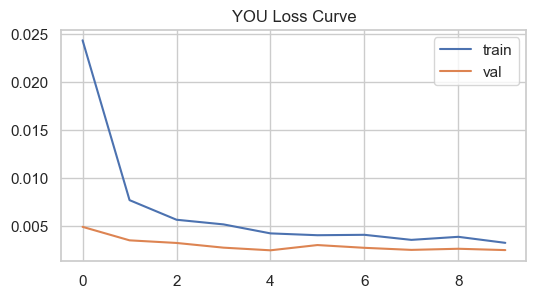

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
YOU → Test RMSE: 4.36


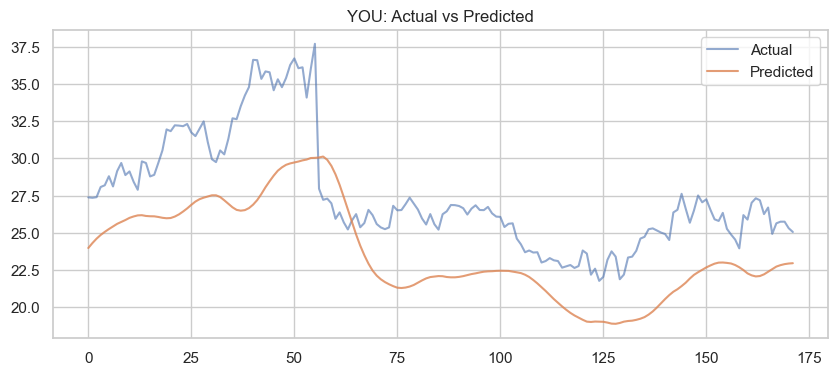

=== Training on CBRE ===
CBRE baselines → Naive RMSE: 3.43, SMA(20) RMSE: 6.43
Epoch 1/100
26/26 - 4s - 147ms/step - loss: 0.0363 - val_loss: 0.0031
Epoch 2/100
26/26 - 1s - 39ms/step - loss: 0.0076 - val_loss: 0.0017
Epoch 3/100
26/26 - 1s - 31ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 4/100
26/26 - 1s - 31ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 5/100
26/26 - 1s - 32ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 6/100
26/26 - 1s - 32ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 7/100
26/26 - 1s - 32ms/step - loss: 0.0028 - val_loss: 0.0023


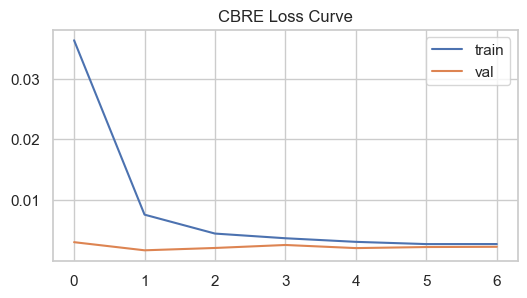

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
CBRE → Test RMSE: 18.58


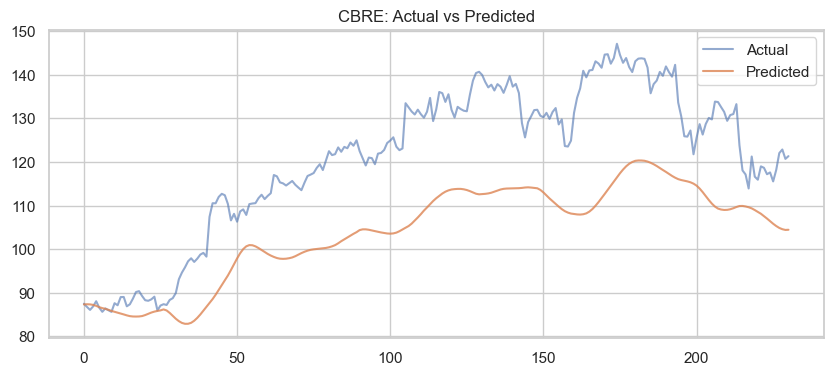

=== Training on PLD ===
PLD baselines → Naive RMSE: 2.73, SMA(20) RMSE: 5.44
Epoch 1/100
26/26 - 4s - 164ms/step - loss: 0.0302 - val_loss: 0.0079
Epoch 2/100
26/26 - 1s - 34ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 3/100
26/26 - 1s - 33ms/step - loss: 0.0066 - val_loss: 0.0040
Epoch 4/100
26/26 - 1s - 32ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 5/100
26/26 - 1s - 33ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 6/100
26/26 - 1s - 33ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 7/100
26/26 - 1s - 33ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 8/100
26/26 - 1s - 34ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 9/100
26/26 - 1s - 33ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 10/100
26/26 - 1s - 33ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 11/100
26/26 - 1s - 33ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 12/100
26/26 - 1s - 33ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 13/100
26/26 - 1s - 49ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 14/100
26/26 - 

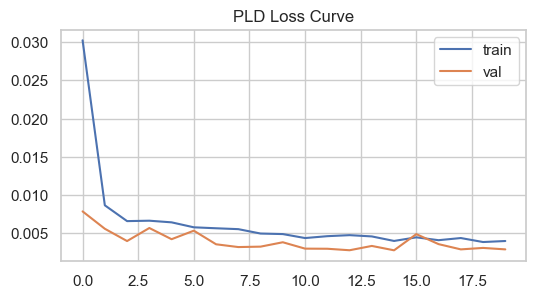

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
PLD → Test RMSE: 3.79


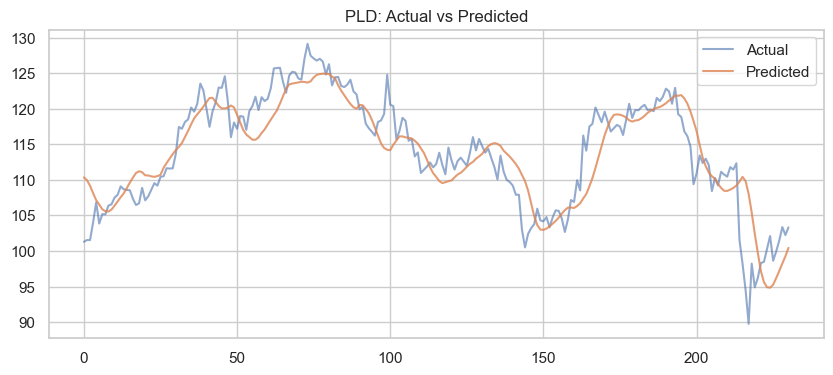

=== Training on AMT ===
AMT baselines → Naive RMSE: 4.85, SMA(20) RMSE: 9.52
Epoch 1/100
26/26 - 4s - 160ms/step - loss: 0.0403 - val_loss: 0.0079
Epoch 2/100
26/26 - 1s - 33ms/step - loss: 0.0110 - val_loss: 0.0064
Epoch 3/100
26/26 - 1s - 34ms/step - loss: 0.0092 - val_loss: 0.0044
Epoch 4/100
26/26 - 1s - 33ms/step - loss: 0.0084 - val_loss: 0.0040
Epoch 5/100
26/26 - 1s - 34ms/step - loss: 0.0074 - val_loss: 0.0034
Epoch 6/100
26/26 - 1s - 33ms/step - loss: 0.0068 - val_loss: 0.0023
Epoch 7/100
26/26 - 1s - 33ms/step - loss: 0.0068 - val_loss: 0.0023
Epoch 8/100
26/26 - 1s - 32ms/step - loss: 0.0068 - val_loss: 0.0027
Epoch 9/100
26/26 - 1s - 33ms/step - loss: 0.0062 - val_loss: 0.0036
Epoch 10/100
26/26 - 1s - 33ms/step - loss: 0.0058 - val_loss: 0.0032
Epoch 11/100
26/26 - 1s - 32ms/step - loss: 0.0058 - val_loss: 0.0029


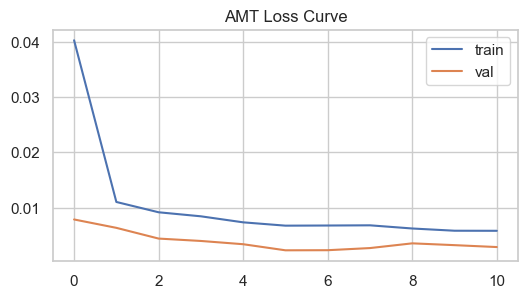

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
AMT → Test RMSE: 7.24


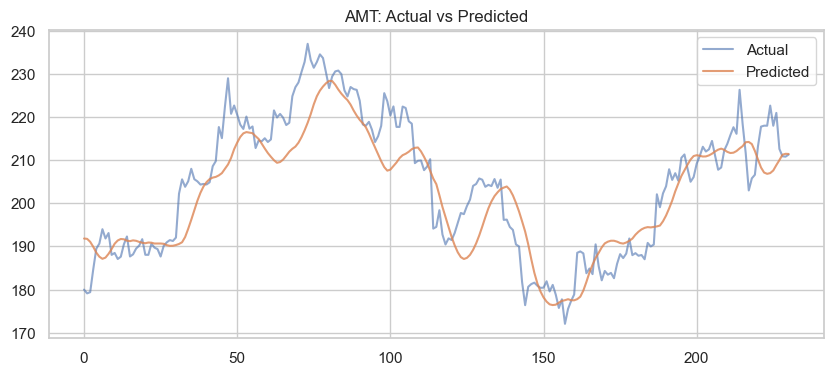

=== Training on WELL ===
WELL baselines → Naive RMSE: 2.60, SMA(20) RMSE: 5.40
Epoch 1/100
26/26 - 6s - 248ms/step - loss: 0.0134 - val_loss: 0.0051
Epoch 2/100
26/26 - 1s - 35ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 3/100
26/26 - 1s - 34ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 4/100
26/26 - 1s - 32ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 5/100
26/26 - 1s - 38ms/step - loss: 0.0017 - val_loss: 9.1425e-04
Epoch 6/100
26/26 - 1s - 34ms/step - loss: 0.0014 - val_loss: 4.9221e-04
Epoch 7/100
26/26 - 1s - 34ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/100
26/26 - 1s - 35ms/step - loss: 0.0014 - val_loss: 4.1659e-04
Epoch 9/100
26/26 - 1s - 34ms/step - loss: 0.0013 - val_loss: 4.2486e-04
Epoch 10/100
26/26 - 1s - 34ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 11/100
26/26 - 1s - 34ms/step - loss: 0.0012 - val_loss: 3.8955e-04
Epoch 12/100
26/26 - 1s - 34ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 13/100
26/26 - 1s - 35ms/step - loss: 0.0011 - val_loss: 3.0894

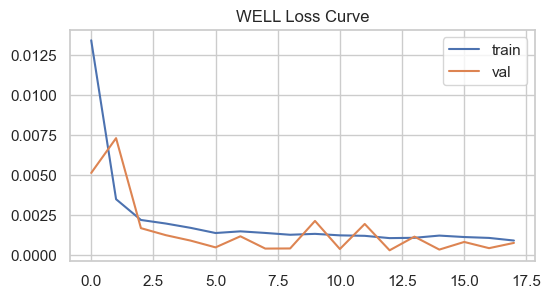

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
WELL → Test RMSE: 11.69


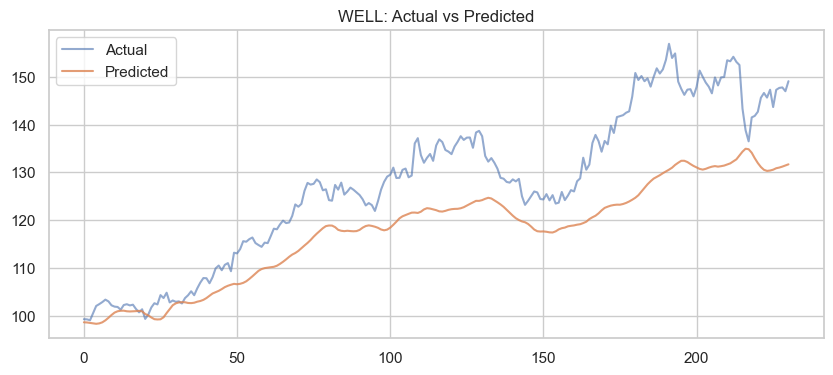

=== Training on EQIX ===
EQIX baselines → Naive RMSE: 18.21, SMA(20) RMSE: 30.07
Epoch 1/100
26/26 - 4s - 166ms/step - loss: 0.0236 - val_loss: 0.0240
Epoch 2/100
26/26 - 1s - 34ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 3/100
26/26 - 1s - 32ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 4/100
26/26 - 1s - 33ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 5/100
26/26 - 1s - 36ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 6/100
26/26 - 1s - 34ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 7/100
26/26 - 1s - 34ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 8/100
26/26 - 1s - 33ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 9/100
26/26 - 1s - 33ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 10/100
26/26 - 1s - 33ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 11/100
26/26 - 1s - 36ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 12/100
26/26 - 1s - 39ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 13/100
26/26 - 1s - 33ms/step - loss: 0.0035 - val_loss: 0.0034


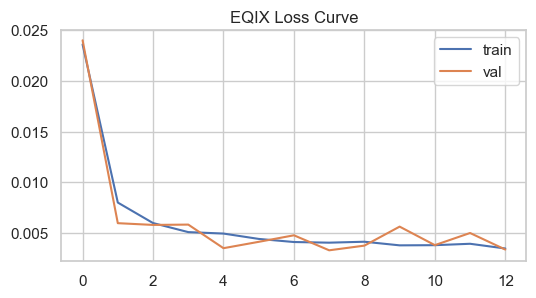

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
EQIX → Test RMSE: 29.44


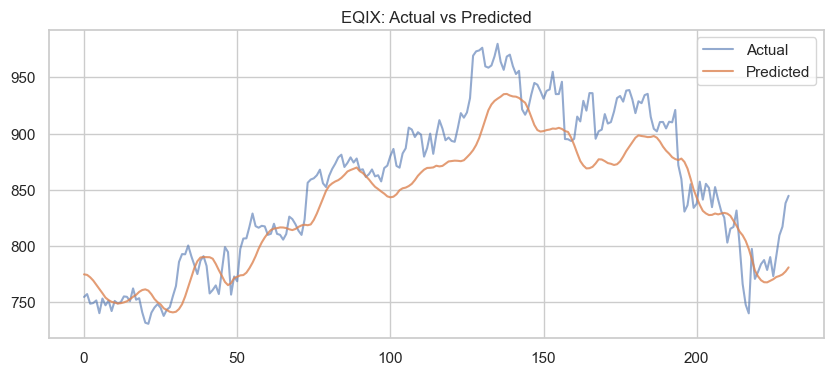

=== Training on SPG ===
SPG baselines → Naive RMSE: 3.69, SMA(20) RMSE: 6.24
Epoch 1/100
26/26 - 5s - 175ms/step - loss: 0.0203 - val_loss: 0.0262
Epoch 2/100
26/26 - 1s - 33ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 3/100
26/26 - 1s - 34ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 4/100
26/26 - 1s - 33ms/step - loss: 0.0034 - val_loss: 0.0086
Epoch 5/100
26/26 - 1s - 33ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/100
26/26 - 1s - 34ms/step - loss: 0.0031 - val_loss: 0.0085
Epoch 7/100
26/26 - 1s - 33ms/step - loss: 0.0031 - val_loss: 0.0060
Epoch 8/100
26/26 - 1s - 34ms/step - loss: 0.0023 - val_loss: 0.0055
Epoch 9/100
26/26 - 1s - 34ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/100
26/26 - 1s - 34ms/step - loss: 0.0024 - val_loss: 0.0069
Epoch 11/100
26/26 - 1s - 33ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 12/100
26/26 - 1s - 34ms/step - loss: 0.0025 - val_loss: 0.0057
Epoch 13/100
26/26 - 1s - 37ms/step - loss: 0.0021 - val_loss: 9.5664e-04
Epoch 14/100
26/2

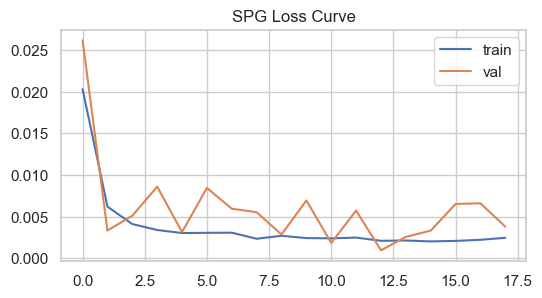

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
SPG → Test RMSE: 9.19


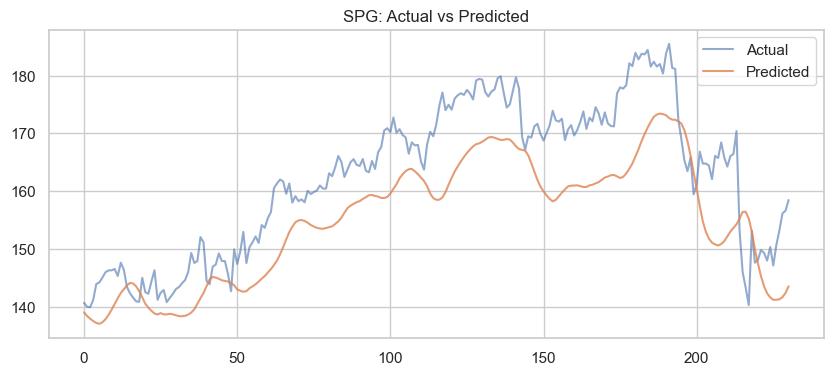

=== Training on PSA ===
PSA baselines → Naive RMSE: 6.19, SMA(20) RMSE: 12.45
Epoch 1/100
26/26 - 4s - 158ms/step - loss: 0.0396 - val_loss: 0.0030
Epoch 2/100
26/26 - 1s - 33ms/step - loss: 0.0088 - val_loss: 0.0015
Epoch 3/100
26/26 - 1s - 34ms/step - loss: 0.0064 - val_loss: 0.0018
Epoch 4/100
26/26 - 1s - 32ms/step - loss: 0.0057 - val_loss: 0.0015
Epoch 5/100
26/26 - 1s - 32ms/step - loss: 0.0056 - val_loss: 0.0014
Epoch 6/100
26/26 - 1s - 32ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 7/100
26/26 - 1s - 35ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 8/100
26/26 - 1s - 41ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 9/100
26/26 - 1s - 33ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 10/100
26/26 - 1s - 35ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 11/100
26/26 - 1s - 34ms/step - loss: 0.0050 - val_loss: 0.0012
Epoch 12/100
26/26 - 1s - 33ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 13/100
26/26 - 1s - 33ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 14/100
26/26 -

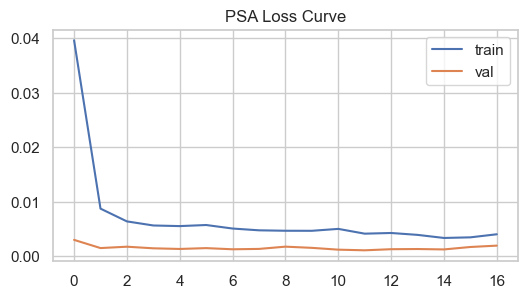

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
PSA → Test RMSE: 15.77


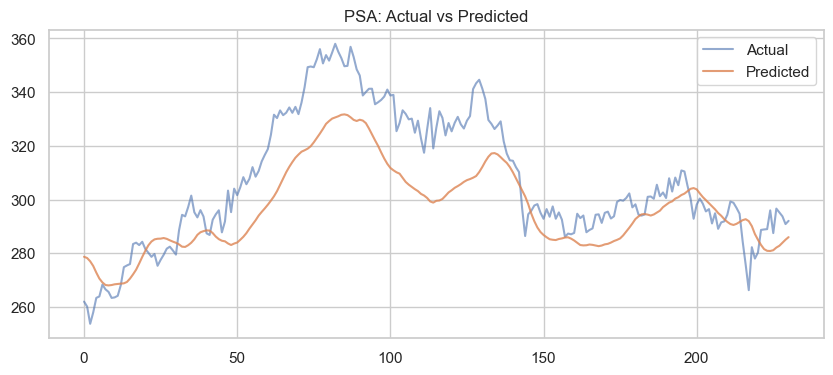

=== Training on DLR ===
DLR baselines → Naive RMSE: 4.27, SMA(20) RMSE: 7.22
Epoch 1/100
26/26 - 4s - 159ms/step - loss: 0.0283 - val_loss: 0.0342
Epoch 2/100
26/26 - 1s - 33ms/step - loss: 0.0063 - val_loss: 0.0249
Epoch 3/100
26/26 - 1s - 33ms/step - loss: 0.0045 - val_loss: 0.0103
Epoch 4/100
26/26 - 1s - 31ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 5/100
26/26 - 1s - 33ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 6/100
26/26 - 1s - 34ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 7/100
26/26 - 1s - 33ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 8/100
26/26 - 1s - 32ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 9/100
26/26 - 1s - 32ms/step - loss: 0.0032 - val_loss: 0.0059
Epoch 10/100
26/26 - 1s - 31ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 11/100
26/26 - 1s - 32ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 12/100
26/26 - 1s - 34ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 13/100
26/26 - 1s - 33ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 14/100
26/26 - 

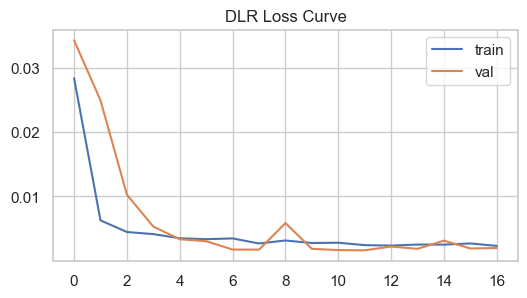

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
DLR → Test RMSE: 6.99


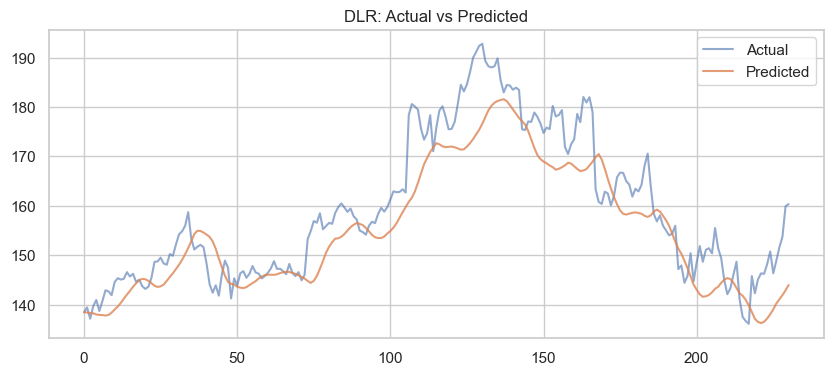

=== Training on O ===
O baselines → Naive RMSE: 0.98, SMA(20) RMSE: 1.93
Epoch 1/100
26/26 - 4s - 160ms/step - loss: 0.0351 - val_loss: 0.0086
Epoch 2/100
26/26 - 1s - 34ms/step - loss: 0.0117 - val_loss: 0.0051
Epoch 3/100
26/26 - 1s - 33ms/step - loss: 0.0090 - val_loss: 0.0043
Epoch 4/100
26/26 - 1s - 32ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 5/100
26/26 - 1s - 31ms/step - loss: 0.0088 - val_loss: 0.0048
Epoch 6/100
26/26 - 1s - 33ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 7/100
26/26 - 1s - 32ms/step - loss: 0.0077 - val_loss: 0.0043
Epoch 8/100
26/26 - 1s - 32ms/step - loss: 0.0072 - val_loss: 0.0085
Epoch 9/100
26/26 - 1s - 31ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 10/100
26/26 - 1s - 32ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 11/100
26/26 - 1s - 33ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 12/100
26/26 - 1s - 36ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 13/100
26/26 - 1s - 35ms/step - loss: 0.0062 - val_loss: 0.0025
Epoch 14/100
26/26 - 1s -

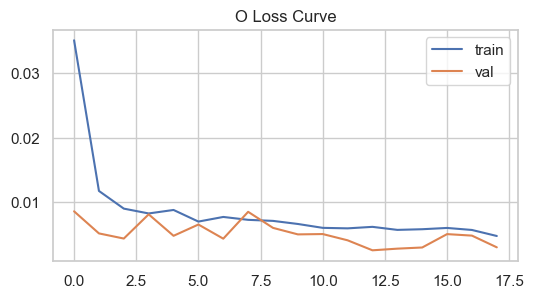

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
O → Test RMSE: 1.49


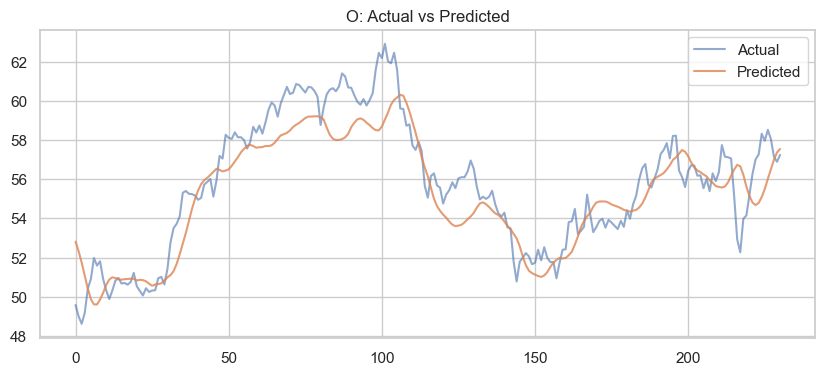

=== Training on CCI ===
CCI baselines → Naive RMSE: 2.34, SMA(20) RMSE: 4.60
Epoch 1/100
26/26 - 4s - 157ms/step - loss: 0.0517 - val_loss: 0.0062
Epoch 2/100
26/26 - 1s - 34ms/step - loss: 0.0105 - val_loss: 0.0012
Epoch 3/100
26/26 - 1s - 34ms/step - loss: 0.0076 - val_loss: 0.0010
Epoch 4/100
26/26 - 1s - 35ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 5/100
26/26 - 1s - 34ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 6/100
26/26 - 1s - 33ms/step - loss: 0.0061 - val_loss: 0.0010
Epoch 7/100
26/26 - 1s - 33ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 8/100
26/26 - 1s - 34ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 9/100
26/26 - 1s - 34ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 10/100
26/26 - 1s - 40ms/step - loss: 0.0058 - val_loss: 9.1519e-04
Epoch 11/100
26/26 - 1s - 34ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 12/100
26/26 - 1s - 34ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 13/100
26/26 - 1s - 34ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 14/100
26/2

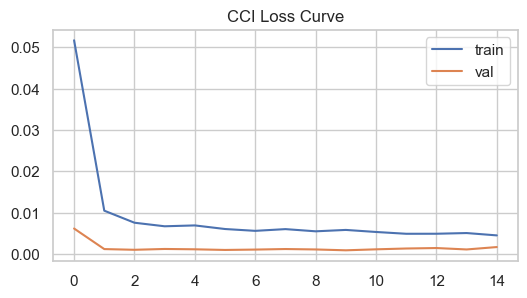

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
CCI → Test RMSE: 4.03


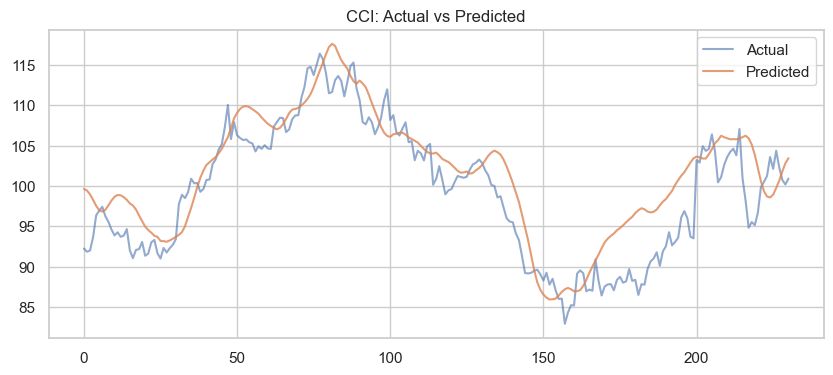

=== Training on VICI ===
VICI baselines → Naive RMSE: 0.53, SMA(20) RMSE: 1.03
Epoch 1/100
26/26 - 4s - 152ms/step - loss: 0.0739 - val_loss: 0.0017
Epoch 2/100
26/26 - 1s - 33ms/step - loss: 0.0107 - val_loss: 0.0030
Epoch 3/100
26/26 - 1s - 33ms/step - loss: 0.0076 - val_loss: 0.0015
Epoch 4/100
26/26 - 1s - 33ms/step - loss: 0.0065 - val_loss: 0.0019
Epoch 5/100
26/26 - 1s - 33ms/step - loss: 0.0067 - val_loss: 0.0015
Epoch 6/100
26/26 - 1s - 32ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 7/100
26/26 - 1s - 32ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 8/100
26/26 - 1s - 33ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 9/100
26/26 - 1s - 33ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 10/100
26/26 - 1s - 33ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 11/100
26/26 - 1s - 31ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 12/100
26/26 - 1s - 32ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 13/100
26/26 - 1s - 32ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 14/100
26/26 

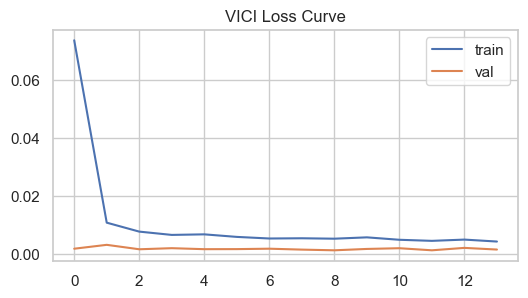

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
VICI → Test RMSE: 1.41


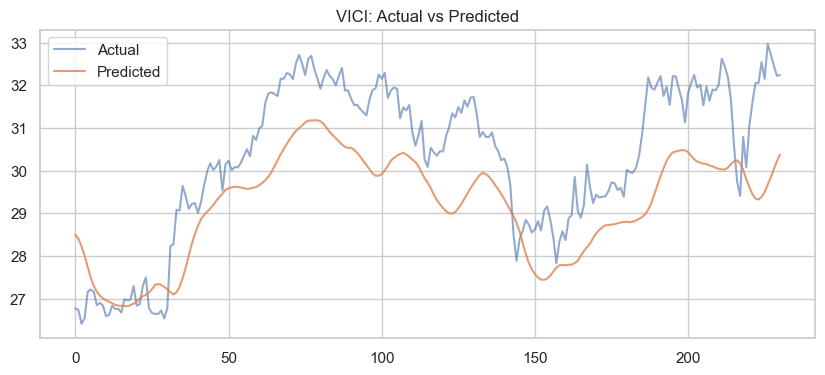

=== Training on EXR ===
EXR baselines → Naive RMSE: 3.32, SMA(20) RMSE: 6.04
Epoch 1/100
26/26 - 4s - 156ms/step - loss: 0.0520 - val_loss: 0.0049
Epoch 2/100
26/26 - 1s - 34ms/step - loss: 0.0113 - val_loss: 0.0020
Epoch 3/100
26/26 - 1s - 45ms/step - loss: 0.0078 - val_loss: 0.0016
Epoch 4/100
26/26 - 1s - 40ms/step - loss: 0.0074 - val_loss: 0.0019
Epoch 5/100
26/26 - 1s - 34ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 6/100
26/26 - 1s - 33ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 7/100
26/26 - 1s - 34ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 8/100
26/26 - 1s - 33ms/step - loss: 0.0052 - val_loss: 0.0021


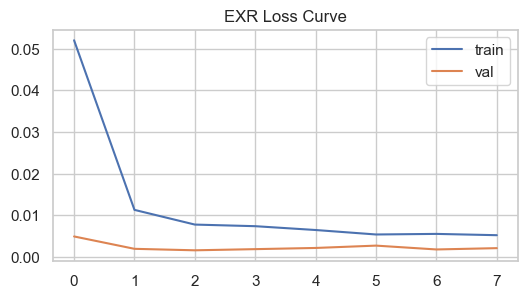

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
EXR → Test RMSE: 7.76


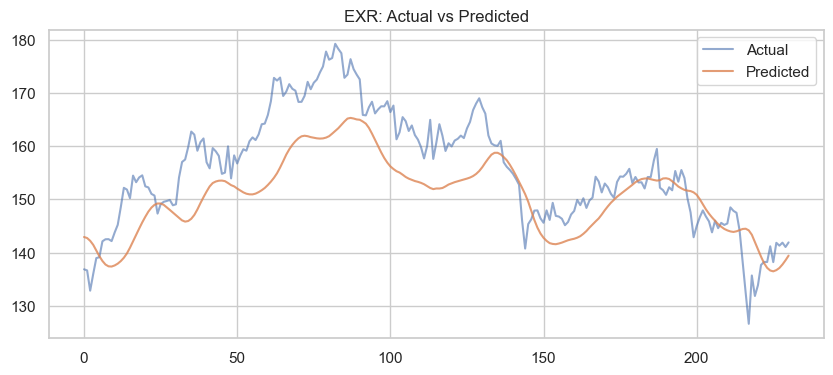

=== Training on CSGP ===
CSGP baselines → Naive RMSE: 1.95, SMA(20) RMSE: 3.49
Epoch 1/100
26/26 - 4s - 157ms/step - loss: 0.0408 - val_loss: 0.0200
Epoch 2/100
26/26 - 1s - 35ms/step - loss: 0.0126 - val_loss: 0.0087
Epoch 3/100
26/26 - 1s - 33ms/step - loss: 0.0111 - val_loss: 0.0080
Epoch 4/100
26/26 - 1s - 34ms/step - loss: 0.0108 - val_loss: 0.0067
Epoch 5/100
26/26 - 1s - 32ms/step - loss: 0.0105 - val_loss: 0.0080
Epoch 6/100
26/26 - 1s - 34ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 7/100
26/26 - 1s - 33ms/step - loss: 0.0087 - val_loss: 0.0112
Epoch 8/100
26/26 - 1s - 33ms/step - loss: 0.0082 - val_loss: 0.0089
Epoch 9/100
26/26 - 1s - 42ms/step - loss: 0.0076 - val_loss: 0.0068


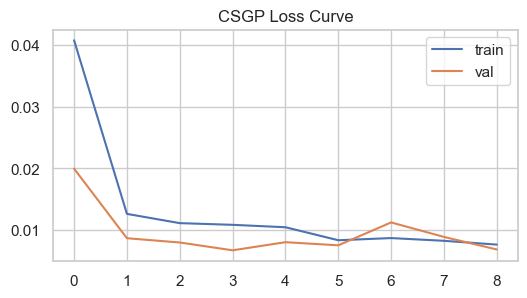

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
CSGP → Test RMSE: 2.78


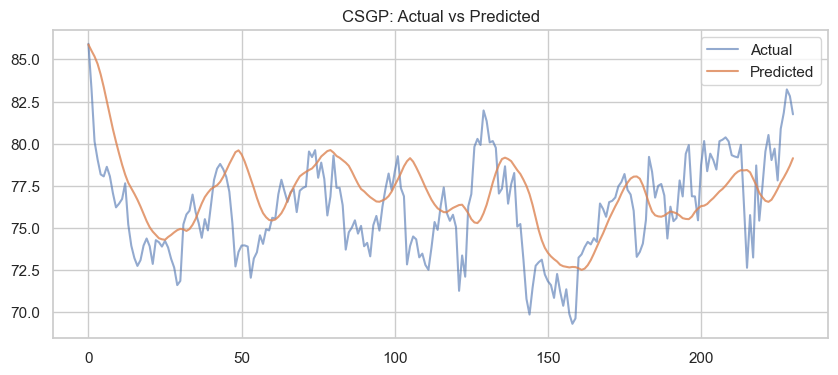

=== Training on AVB ===
AVB baselines → Naive RMSE: 4.04, SMA(20) RMSE: 6.13
Epoch 1/100
26/26 - 4s - 158ms/step - loss: 0.0360 - val_loss: 0.0046
Epoch 2/100
26/26 - 1s - 36ms/step - loss: 0.0087 - val_loss: 0.0048
Epoch 3/100
26/26 - 1s - 35ms/step - loss: 0.0069 - val_loss: 0.0014
Epoch 4/100
26/26 - 1s - 40ms/step - loss: 0.0065 - val_loss: 0.0025
Epoch 5/100
26/26 - 1s - 36ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 6/100
26/26 - 1s - 36ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 7/100
26/26 - 1s - 35ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 8/100
26/26 - 1s - 35ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 9/100
26/26 - 1s - 43ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 10/100
26/26 - 1s - 43ms/step - loss: 0.0050 - val_loss: 0.0014


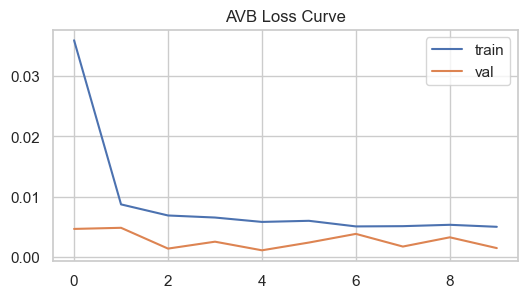

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
AVB → Test RMSE: 8.55


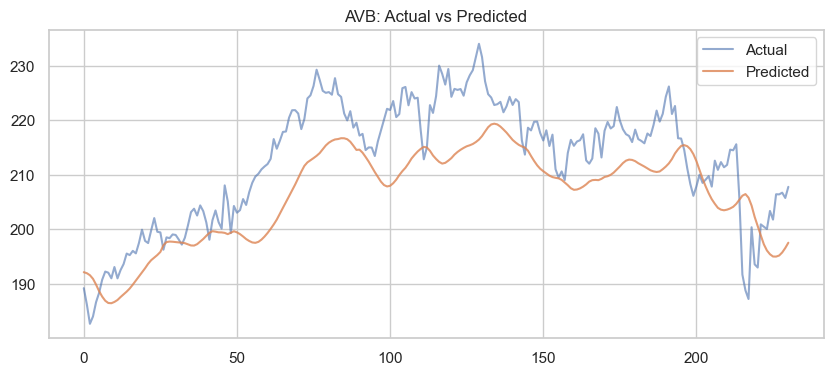

=== Training on VTR ===
VTR baselines → Naive RMSE: 1.22, SMA(20) RMSE: 2.42
Epoch 1/100
26/26 - 4s - 168ms/step - loss: 0.0318 - val_loss: 9.8206e-04
Epoch 2/100
26/26 - 1s - 32ms/step - loss: 0.0062 - val_loss: 0.0018
Epoch 3/100
26/26 - 1s - 33ms/step - loss: 0.0050 - val_loss: 6.2038e-04
Epoch 4/100
26/26 - 1s - 33ms/step - loss: 0.0044 - val_loss: 6.3210e-04
Epoch 5/100
26/26 - 1s - 33ms/step - loss: 0.0038 - val_loss: 6.2158e-04
Epoch 6/100
26/26 - 1s - 34ms/step - loss: 0.0036 - val_loss: 5.0382e-04
Epoch 7/100
26/26 - 1s - 34ms/step - loss: 0.0033 - val_loss: 5.7171e-04
Epoch 8/100
26/26 - 1s - 45ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 9/100
26/26 - 1s - 35ms/step - loss: 0.0036 - val_loss: 5.5015e-04
Epoch 10/100
26/26 - 1s - 35ms/step - loss: 0.0032 - val_loss: 4.4081e-04
Epoch 11/100
26/26 - 1s - 36ms/step - loss: 0.0030 - val_loss: 4.1605e-04
Epoch 12/100
26/26 - 1s - 44ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 13/100
26/26 - 1s - 35ms/step - loss: 0.0033 - va

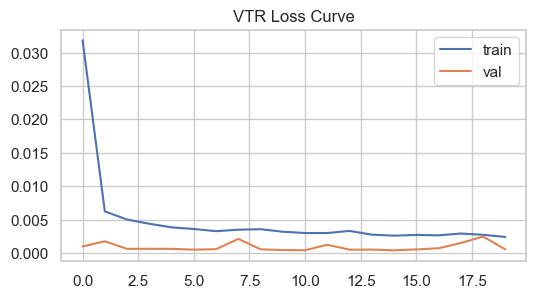

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
VTR → Test RMSE: 6.06


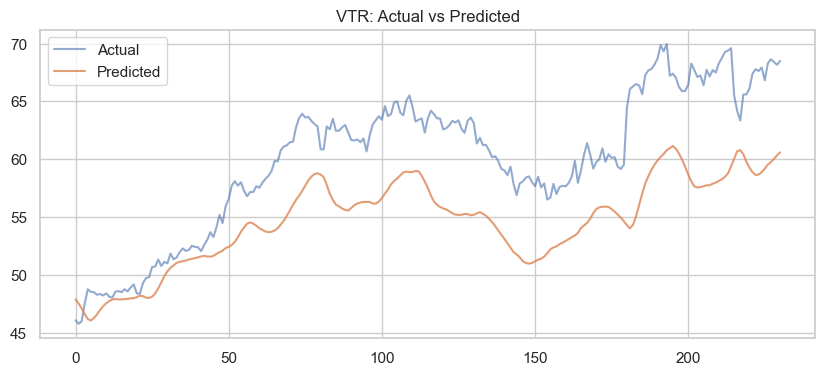

=== Training on EQR ===
EQR baselines → Naive RMSE: 1.40, SMA(20) RMSE: 2.13
Epoch 1/100
26/26 - 5s - 174ms/step - loss: 0.0493 - val_loss: 0.0024
Epoch 2/100
26/26 - 1s - 34ms/step - loss: 0.0115 - val_loss: 0.0018
Epoch 3/100
26/26 - 1s - 38ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 4/100
26/26 - 1s - 43ms/step - loss: 0.0069 - val_loss: 0.0030
Epoch 5/100
26/26 - 1s - 41ms/step - loss: 0.0070 - val_loss: 0.0014
Epoch 6/100
26/26 - 1s - 36ms/step - loss: 0.0059 - val_loss: 0.0015
Epoch 7/100
26/26 - 1s - 34ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 8/100
26/26 - 1s - 36ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 9/100
26/26 - 1s - 40ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 10/100
26/26 - 1s - 39ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 11/100
26/26 - 1s - 35ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 12/100
26/26 - 1s - 34ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 13/100
26/26 - 1s - 43ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 14/100
26/26 - 

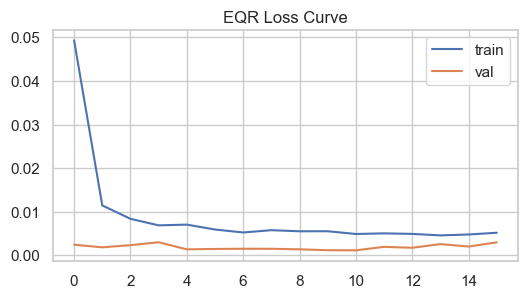

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
EQR → Test RMSE: 3.41


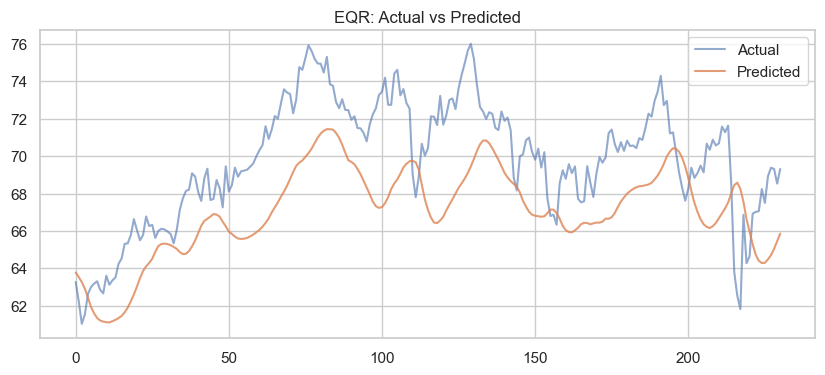

=== Training on IRM ===
IRM baselines → Naive RMSE: 3.02, SMA(20) RMSE: 5.74
Epoch 1/100
26/26 - 4s - 159ms/step - loss: 0.0130 - val_loss: 0.0157
Epoch 2/100
26/26 - 1s - 35ms/step - loss: 0.0030 - val_loss: 0.0176
Epoch 3/100
26/26 - 1s - 36ms/step - loss: 0.0023 - val_loss: 0.0121
Epoch 4/100
26/26 - 1s - 33ms/step - loss: 0.0019 - val_loss: 0.0085
Epoch 5/100
26/26 - 1s - 34ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 6/100
26/26 - 1s - 34ms/step - loss: 0.0014 - val_loss: 0.0094
Epoch 7/100
26/26 - 1s - 33ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 8/100
26/26 - 1s - 34ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 9/100
26/26 - 1s - 32ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 10/100
26/26 - 1s - 34ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 11/100
26/26 - 1s - 32ms/step - loss: 9.6280e-04 - val_loss: 0.0048
Epoch 12/100
26/26 - 1s - 32ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 13/100
26/26 - 1s - 34ms/step - loss: 9.2829e-04 - val_loss: 0.0034
Epoch 14/100


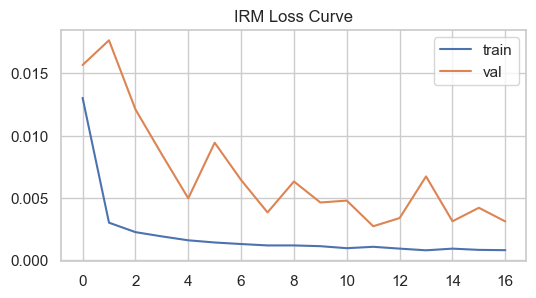

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
IRM → Test RMSE: 19.94


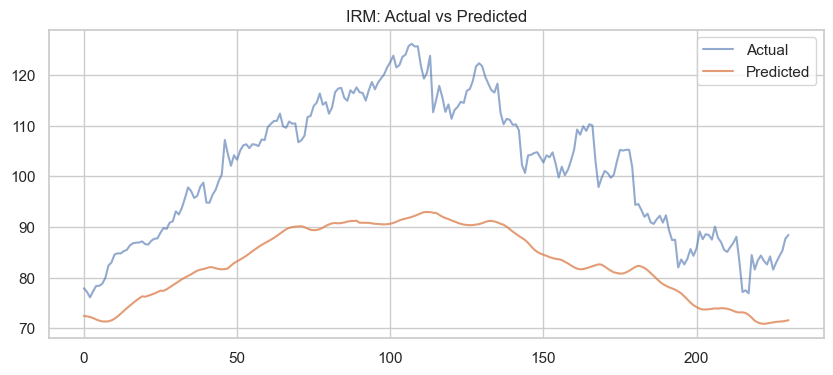

=== Training on SBAC ===
SBAC baselines → Naive RMSE: 4.96, SMA(20) RMSE: 8.85
Epoch 1/100
26/26 - 4s - 156ms/step - loss: 0.0689 - val_loss: 0.0045
Epoch 2/100
26/26 - 1s - 33ms/step - loss: 0.0115 - val_loss: 0.0033
Epoch 3/100
26/26 - 1s - 34ms/step - loss: 0.0085 - val_loss: 0.0072
Epoch 4/100
26/26 - 1s - 33ms/step - loss: 0.0073 - val_loss: 0.0032
Epoch 5/100
26/26 - 1s - 34ms/step - loss: 0.0066 - val_loss: 0.0017
Epoch 6/100
26/26 - 1s - 34ms/step - loss: 0.0060 - val_loss: 0.0015
Epoch 7/100
26/26 - 1s - 34ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 8/100
26/26 - 1s - 33ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 9/100
26/26 - 1s - 33ms/step - loss: 0.0056 - val_loss: 9.9210e-04
Epoch 10/100
26/26 - 1s - 32ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 11/100
26/26 - 1s - 33ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 12/100
26/26 - 1s - 32ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 13/100
26/26 - 1s - 34ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 14/100
26

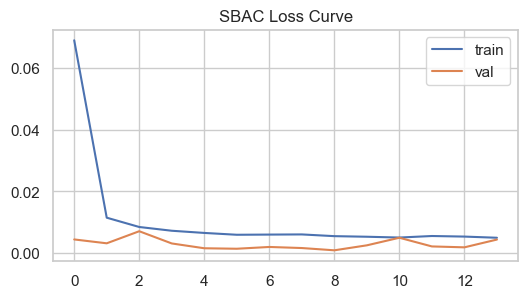

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
SBAC → Test RMSE: 8.64


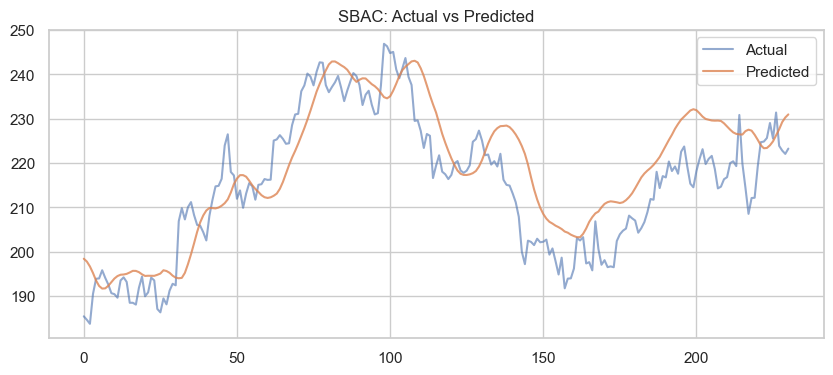

=== Training on WY ===
WY baselines → Naive RMSE: 0.66, SMA(20) RMSE: 1.41
Epoch 1/100
26/26 - 4s - 159ms/step - loss: 0.0555 - val_loss: 0.0037
Epoch 2/100
26/26 - 1s - 33ms/step - loss: 0.0127 - val_loss: 0.0022
Epoch 3/100
26/26 - 1s - 33ms/step - loss: 0.0085 - val_loss: 0.0033
Epoch 4/100
26/26 - 1s - 34ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 5/100
26/26 - 1s - 34ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 6/100
26/26 - 1s - 33ms/step - loss: 0.0070 - val_loss: 0.0035
Epoch 7/100
26/26 - 1s - 34ms/step - loss: 0.0065 - val_loss: 0.0018
Epoch 8/100
26/26 - 1s - 34ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 9/100
26/26 - 1s - 44ms/step - loss: 0.0063 - val_loss: 0.0017
Epoch 10/100
26/26 - 1s - 34ms/step - loss: 0.0064 - val_loss: 0.0017
Epoch 11/100
26/26 - 1s - 34ms/step - loss: 0.0062 - val_loss: 0.0044
Epoch 12/100
26/26 - 1s - 33ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 13/100
26/26 - 1s - 34ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 14/100
26/26 - 1s

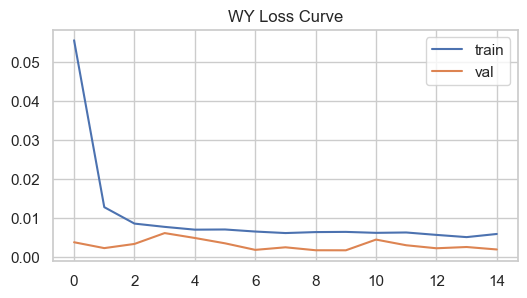

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
WY → Test RMSE: 1.33


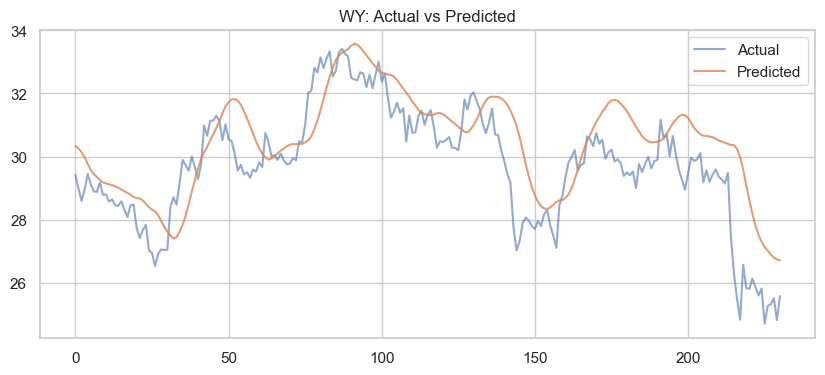

=== Training on INVH ===
INVH baselines → Naive RMSE: 0.66, SMA(20) RMSE: 0.96
Epoch 1/100
26/26 - 4s - 159ms/step - loss: 0.0480 - val_loss: 0.0024
Epoch 2/100
26/26 - 1s - 33ms/step - loss: 0.0108 - val_loss: 0.0055
Epoch 3/100
26/26 - 1s - 33ms/step - loss: 0.0092 - val_loss: 0.0019
Epoch 4/100
26/26 - 1s - 34ms/step - loss: 0.0085 - val_loss: 0.0029
Epoch 5/100
26/26 - 1s - 33ms/step - loss: 0.0072 - val_loss: 0.0017
Epoch 6/100
26/26 - 1s - 32ms/step - loss: 0.0070 - val_loss: 0.0020
Epoch 7/100
26/26 - 1s - 33ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 8/100
26/26 - 1s - 34ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 9/100
26/26 - 1s - 40ms/step - loss: 0.0060 - val_loss: 0.0020
Epoch 10/100
26/26 - 1s - 38ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 11/100
26/26 - 1s - 40ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 12/100
26/26 - 1s - 38ms/step - loss: 0.0054 - val_loss: 0.0014
Epoch 13/100
26/26 - 1s - 31ms/step - loss: 0.0055 - val_loss: 0.0013
Epoch 14/100
26/26 

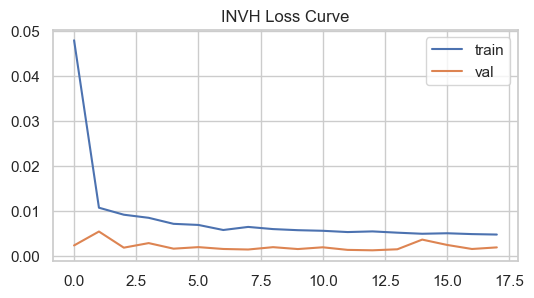

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
INVH → Test RMSE: 0.86


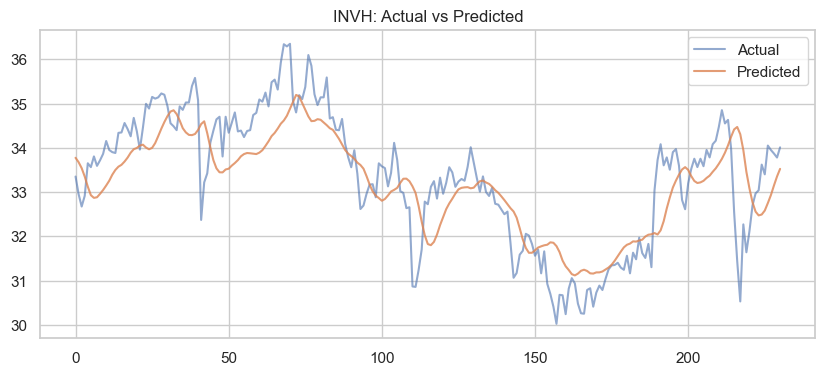

=== Training on YOU ===
YOU baselines → Naive RMSE: 1.42, SMA(20) RMSE: 2.80
Epoch 1/100
20/20 - 6s - 315ms/step - loss: 0.0140 - val_loss: 0.0064
Epoch 2/100
20/20 - 1s - 34ms/step - loss: 0.0062 - val_loss: 0.0040
Epoch 3/100
20/20 - 1s - 33ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 4/100
20/20 - 1s - 34ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 5/100
20/20 - 1s - 32ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 6/100
20/20 - 1s - 32ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 7/100
20/20 - 1s - 32ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 8/100
20/20 - 1s - 34ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 9/100
20/20 - 1s - 33ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 10/100
20/20 - 1s - 33ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 11/100
20/20 - 1s - 33ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 12/100
20/20 - 1s - 36ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 13/100
20/20 - 1s - 48ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 14/100
20/20 - 

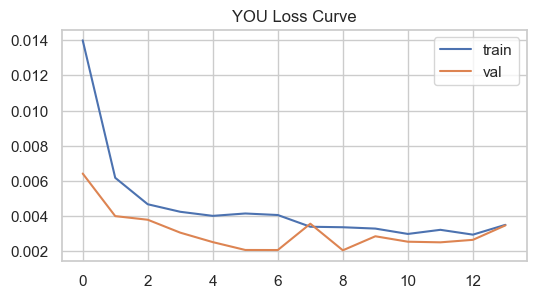

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
YOU → Test RMSE: 3.83


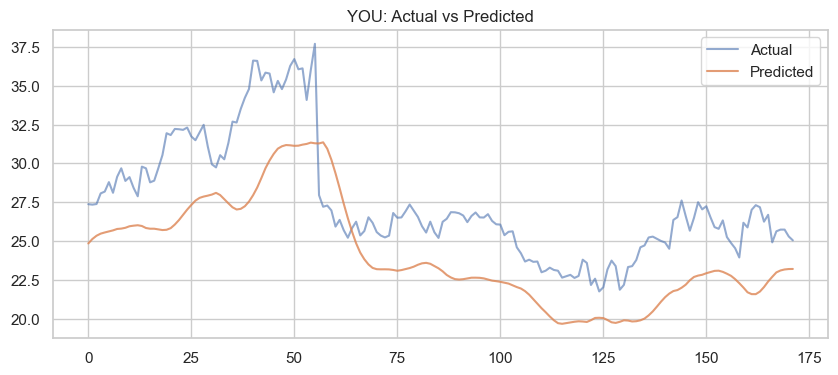

In [357]:
# --- 2) Helper to run pipeline for one ticker ---
def run_lstm_for_ticker(df, ticker):
    # a) subset and sort
    sub = df[df['Ticker']==ticker].sort_values('Date')
    
    # b) drop any rows missing features/target
    sub = sub[features + [target]].dropna()
    
    # c) scale
    scaler = MinMaxScaler()
    arr = scaler.fit_transform(sub.values)   # shape = (n_samples, n_feats+1)
    
    # d) build sequences
    X, y = [], []
    for i in range(len(arr)-seq_length):
        X.append(arr[i:i+seq_length, :-1])   # all features
        y.append(arr[i+seq_length, -1])      # target
    X = np.array(X)
    y = np.array(y)
    
    # e) train/test split
    split_idx = int((1-test_split)*len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # --- 2.5) Compute simple baselines on the *test* set -------------
    # a) Naive last-value forecast
    #    we know that y[i] is the scaled price at step i+seq_length,
    #    so naive_pred_scaled = X_test[:, -1, feature_idx_of_Close]
    #    but if 'Close' was column 0 in features:
    close_idx = features.index('Close')
    naive_scaled = X_test[:, -1, close_idx]
    
    # b) SMA(20) baseline: rolling average of the *true* unscaled prices
    true_prices = sub['Close'].values  # unscaled
    # align to the test target positions:
    sma_window = 20
    sma = pd.Series(true_prices).rolling(sma_window).mean().shift(1).values
    sma_test = sma[seq_length + split_idx : seq_length + split_idx + len(y_test)]
    
    # inverse-scale the naive
    zeros = np.zeros((len(naive_scaled), len(features)))
    pred_naive = scaler.inverse_transform(np.hstack([zeros, naive_scaled.reshape(-1,1)]))[:, -1]
    true_test = scaler.inverse_transform(np.hstack([zeros, y_test.reshape(-1,1)]))[:, -1]
    
    # compute MSEs
    mse_naive = mean_squared_error(true_test, pred_naive)
    mse_sma   = mean_squared_error(true_test, sma_test)
    print(f"{ticker} baselines → Naive RMSE: {np.sqrt(mse_naive):.2f}, SMA({sma_window}) RMSE: {np.sqrt(mse_sma):.2f}")
    # ----------------------------------------------------------------
    
    # --- 3) Build the model ---
    n_feats = X.shape[2]
    model = Sequential([
        Input(shape=(seq_length, n_feats)),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),  #setting dropout 0.2 seems to have the most stable curve and lowest RMSE out of 0.1, 0.2, 0.3
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # --- 4) Train with early stopping ---
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,         #100 seems decent but again because of early stopping it might just be pure chance that gives lower RMSE. past 150 doesn't seem to be significant improvement
        batch_size=32,    #32 batches seems to have the lowest RMSE out of 16, 32, 64 configurations
        callbacks=[es],
        verbose=2
    )
    
    # Plot loss curve
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f"{ticker} Loss Curve")
    plt.legend()
    plt.show()
    
    # --- 5) Predict & inverse‐scale ---
    y_pred_scaled = model.predict(X_test)
    # reconstruct full array to inverse‐transform
    zeros = np.zeros((len(y_pred_scaled), n_feats))
    inv_pred = scaler.inverse_transform(np.hstack([zeros, y_pred_scaled]))[:, -1]
    inv_true = scaler.inverse_transform(np.hstack([zeros, y_test.reshape(-1,1)]))[:, -1]
    
    # --- 6) Evaluate & plot ---
    rmse = np.sqrt(mean_squared_error(inv_true, inv_pred))
    print(f"{ticker} → Test RMSE: {rmse:.2f}")
    
    plt.figure(figsize=(10,4))
    plt.plot(inv_true, label='Actual', alpha=0.6)
    plt.plot(inv_pred, label='Predicted', alpha=0.8)
    plt.title(f"{ticker}: Actual vs Predicted")
    plt.legend()
    plt.show()
    
    return model, scaler

# --- 7) Run it for one ticker ---
model, scaler = run_lstm_for_ticker(market_data, ticker='YOU')

# --- 8) (Optional) Loop over all tickers ---
models = {}
for tk in market_data['Ticker'].unique():
    print("=== Training on", tk, "===")
    m, s = run_lstm_for_ticker(market_data, tk)
    models[tk] = m


#### ARIMA Modeling Approach
An Auto-Regressive Integrated Moving Average (ARIMA) model:
- Auto-Regressive (AR): regresses on its own past values (lags)
- Integrated (I): differences the series d times to achieve stationarity
- Moving Average (MA): models the error term as a linear combination of past error terms

It’s fast, interpretable, and—on stationary series like returns—often quite effective for short-term forecasts

An **ARIMA**(p, d, q) model blends three components:

1. **AR(p)** (Auto-Regressive): today’s value is a linear combination of the past p values.  
2. **I(d)** (Integrated): we difference the series d times to remove trends / achieve stationarity.  
3. **MA(q)** (Moving Average): model today’s error as a linear combination of the past q error terms.  

On **stationary** time series (no persistent trend or changing variance), ARMA/ARIMA can excel at short-term forecasts because it explicitly models autocorrelation and noise structure .

---

##### 2. From Prices to Stationary Returns

Financial time series like raw **prices** are almost always non‐stationary (they wander, trend, or have changing volatility). ARIMA requires stationarity, so we:

1. **Log-transform** (optional) to stabilize volatility:  
   ```python
   log_price = np.log(sub['Close'])
   ```
2. **Difference** once to get log-returns (which are typically stationary):  
   ```python
   log_ret = log_price.diff().dropna()
   ```
   Or simple percentage returns:  
   ```python
   ret = sub['Close'].pct_change().dropna()
   ```
3. **Visual check**: plot the series and its rolling mean/variance to see if they stabilize.

---

##### 3. Stationarity Test (ADF)

We use the **Augmented Dickey-Fuller (ADF)** test to confirm stationarity:

```python
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    stat, pval, *_ = adfuller(series)
    print(f"ADF Statistic: {stat:.4f},  p-value: {pval:.4f}")
```

- **Null hypothesis**: the series has a unit root (i.e. is non-stationary).  
- **If p-value < 0.05**, we reject the null ⇒ series is stationary ⇒ set **d = 0** in ARIMA.  
- Otherwise, difference the series again (`d += 1`) and re-test.

---

##### 4. Choosing (p, d, q)

- **d** is determined by the ADF test (number of differences needed for stationarity).  
- **p** and **q** control how many lagged values and lagged errors you include.  

###### 4.1. Autocorrelation & Partial Autocorrelation

- **ACF plot**: shows correlation of the series with its own lagged values ⇒ helps choose **q** (MA order).  
- **PACF plot**: shows correlation of the series with lagged values *after* removing intermediate correlations ⇒ helps choose **p** (AR order).

```python
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(returns, lags=30);  plt.show()
plot_pacf(returns, lags=30); plt.show()
```

Look for the lag beyond which correlation cuts off (“significant spike”).

###### 4.2. Information Criterion Grid Search

If ACF/PACF is unclear, we can automate a small grid search over p and q:

```python
import itertools
import numpy as np

best_aic, best_cfg = np.inf, None
for p, q in itertools.product(range(0,5), range(0,5)):
    try:
        model = ARIMA(returns, order=(p, d, q)).fit()
        if model.aic < best_aic:
            best_aic, best_cfg = model.aic, (p, d, q)
    except:
        continue

print("Best order:", best_cfg, "AIC:", best_aic)
```

- **AIC** (Akaike Information Criterion) balances goodness-of-fit against model complexity.  
- We pick the `(p,d,q)` with the **lowest AIC**.

---

##### 5. Train/Test Split

We simulate “live” forecasting by:

```python
split = int(0.8 * len(returns))
train, test = returns.iloc[:split], returns.iloc[split:]
```

- Fit the ARIMA solely on **train** data.  
- Reserve **test** for out‐of‐sample evaluation.

---

##### 6. Fit & Forecast

```python
from statsmodels.tsa.arima.model import ARIMA

p_opt, d_opt, q_opt = best_cfg
model = ARIMA(train, order=(p_opt, d_opt, q_opt)).fit()
forecast = model.forecast(steps=len(test))
```

- `model.forecast(n)` produces the next **n** predicted values of the differenced series (i.e. returns).

---

##### 7. Convert Returns → Price Forecast

To map predicted returns back to price levels:

```python
last_train_price = sub['Close'].iloc[split]    # the final price in train set
price_forecast = last_train_price * (1 + forecast).cumprod()
true_prices    = sub['Close'].iloc[split+1:]
```

- We start from the last *known* price, then sequentially apply the predicted returns.

---

##### 8. Evaluation & Visualization

###### 8.1. RMSE on Returns

```python
from sklearn.metrics import mean_squared_error
rmse_ret = np.sqrt(mean_squared_error(test, forecast))
print(f"Return-RMSE: {rmse_ret:.4f}")
```

###### 8.2. Price-Level RMSE

```python
rmse_price = np.sqrt(mean_squared_error(true_prices, price_forecast))
print(f"Price-level RMSE: ${rmse_price:.2f}")
```

###### 8.3. Plot Actual vs Forecast

```python
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(true_prices.index, true_prices, label='Actual Price')
plt.plot(true_prices.index, price_forecast, label='ARIMA Forecast', alpha=0.8)
plt.title(f"{ticker} ARIMA({p_opt},{d_opt},{q_opt}) Forecast")
plt.legend()
plt.show()
```

This lets you visually compare how closely the ARIMA price path tracks reality.


In [250]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1) Choose one symbol
ticker = 'YOU'
sub = market_data[market_data['Ticker']==ticker].sort_values('Date')

# 2) Compute Close-to-Close returns (stationary by design)
sub['Return'] = sub['Close'].pct_change().dropna()
returns = sub['Return'].dropna()

In [266]:
def adf_test(series, name="Series"):
    """
    Run Augmented Dickey–Fuller and print p-value.
    If p < 0.05 → reject unit root → series is (likely) stationary.
    """
    result = adfuller(series, autolag='AIC')
    pval = result[1]
    print(f"ADF test on {name}: p-value = {pval:.4f}")

# assume `sub` is your per-ticker DataFrame sorted by Date
returns = sub['Close'].pct_change().dropna()

adf_test(returns, name="1st-difference returns")


ADF test on 1st-difference returns: p-value = 0.0000


In [270]:
log_price = np.log(sub['Close'])
log_returns = log_price.diff().dropna()
adf_test(log_returns, name="log-returns")

# if still non-stationary, difference again:
log_ret_diff2 = log_returns.diff().dropna()
adf_test(log_ret_diff2, name="2nd-difference log-returns")


ADF test on log-returns: p-value = 0.0000
ADF test on 2nd-difference log-returns: p-value = 0.0000


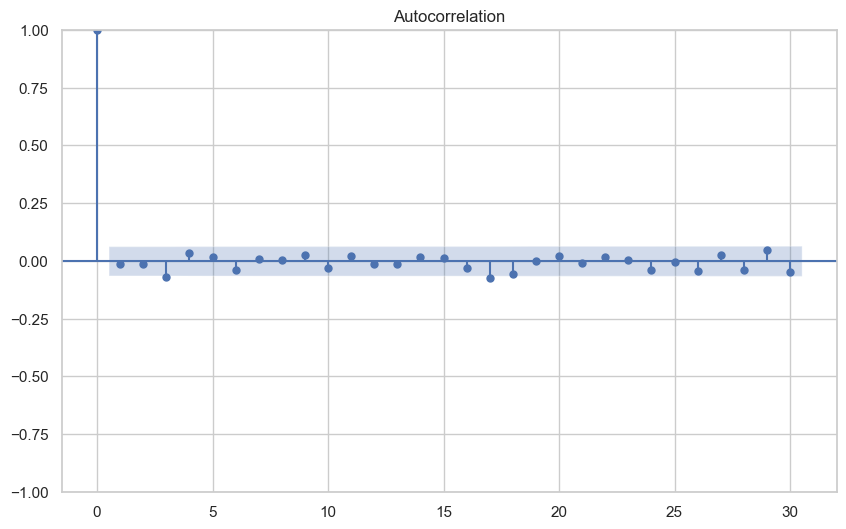

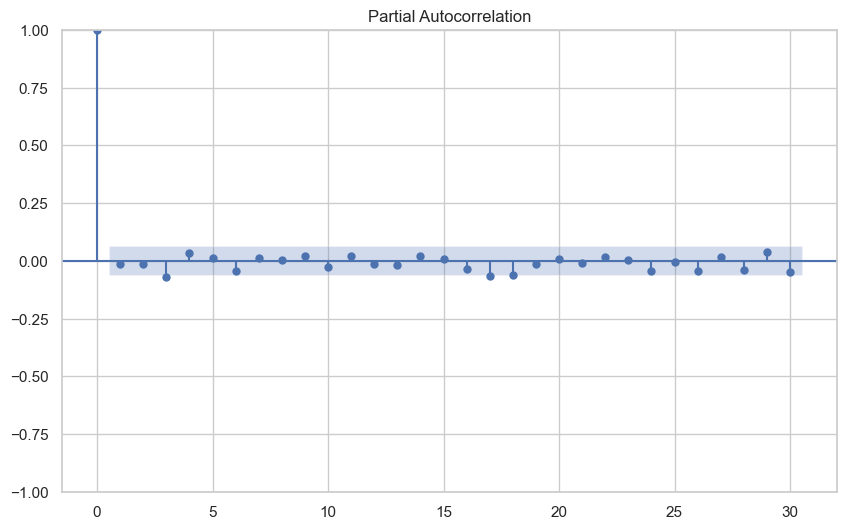

In [272]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(returns, lags=30);  plt.show()
plot_pacf(returns, lags=30); plt.show()

What Are ACF & PACF?
- ACF (Autocorrelation Function) plots the correlation between the series and itself at different lags.
- PACF (Partial Autocorrelation Function) plots the correlation between the series and itself at lag k, after removing all correlations explained by lags 1 through k–1.

Both come with the blue-shaded “95% confidence bands”—any bar that sticks clearly outside that band is considered a significant autocorrelation.
The return series has no linear time-lag structure—at least up to 30 days—so a pure AR/MA model can’t do better than the constant mean.

In [254]:
import itertools

# define ranges
p = q = range(0, 5)
d = 0  # from your ADF test above

best_aic = np.inf
best_cfg = None

for pi, di, qi in itertools.product(p, [d], q):
    try:
        model = ARIMA(returns, order=(pi, di, qi)).fit()
        if model.aic < best_aic:
            best_aic, best_cfg = model.aic, (pi, di, qi)
    except:
        continue

print("Best ARIMA order:", best_cfg, "AIC=", best_aic)


C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA order: (0, 0, 0) AIC= -3454.9451847882274


C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [256]:
# split into train & test (e.g. last 20% as test)
split = int(0.8 * len(returns))
train, test = returns.iloc[:split], returns.iloc[split:]

# fit on train
p_opt, d_opt, q_opt = best_cfg
model = ARIMA(train, order=(p_opt, d_opt, q_opt)).fit()

# forecast next len(test) steps
forecast = model.forecast(steps=len(test))


C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

ARIMA(0,0,0) Return‐RMSE: 0.0367
Price‐level RMSE: $7.78


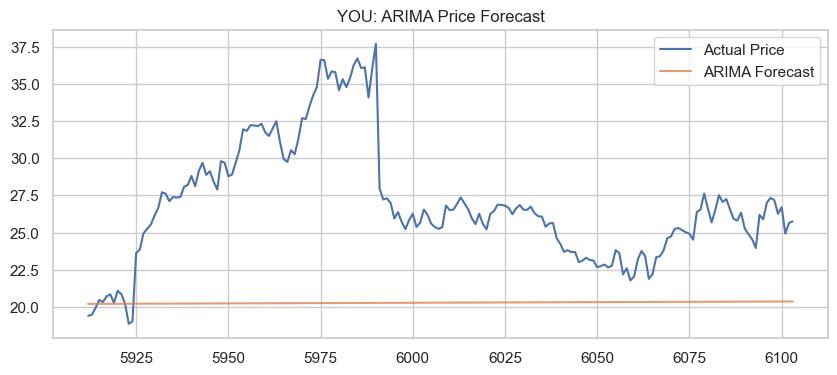

In [258]:
# RMSE on returns
rmse_ret = np.sqrt(mean_squared_error(test, forecast))
print(f"ARIMA({p_opt},{d_opt},{q_opt}) Return‐RMSE: {rmse_ret:.4f}")

# Convert returns → price forecast (starting from last train price)
last_price = sub['Close'].iloc[split]
price_forecast = last_price * (1 + forecast).cumprod()
true_prices   = sub['Close'].iloc[split+1:]

# Price‐level RMSE
rmse_price = np.sqrt(mean_squared_error(true_prices, price_forecast))
print(f"Price‐level RMSE: ${rmse_price:.2f}")

# Plot
plt.figure(figsize=(10,4))
plt.plot(true_prices.index, true_prices, label='Actual Price')
plt.plot(true_prices.index, price_forecast, label='ARIMA Forecast', alpha=0.8)
plt.title(f"{ticker}: ARIMA Price Forecast")
plt.legend()
plt.show()

Because the returns series showed:

1. **No significant autocorrelations** – the ACF bars after lag 0 all stayed within the confidence bands.  
2. **No meaningful partial autocorrelations** – the PACF likewise dropped straight to zero past lag 0.  
3. **Stationarity at first difference** – your returns were already “white noise,” so no extra differencing was needed.

An ARIMA(p, d, q) with **p=0**, **d=0**, **q=0** collapses to the simplest possible forecast:

> **Forecast = the historical mean (constant) + white-noise error**

In other words, if there’s no evidence of linear dependency on past lags (AR terms) or past errors (MA terms), the model’s best guess for tomorrow is just the long-run average of the series. That’s exactly what ARIMA(0,0,0) does—it returns the constant mean of your returns.

*Bottom Line: Since your return series doesn’t show any reliable day-to-day patterns (no linear autocorrelation or seasonality), the ARIMA machinery defaults to the simplest forecast: “tomorrow’s return = the historical average return.”*

#### Facebook PROPHET 

Prophet looks at how your price has moved over months and years, spots the regular bumps (weeks, seasons, holidays), fits a smooth curve through the rest, and then extends that curve to tell you where it thinks prices will go next.

##### 1) Data Preparation

Prophet expects a DataFrame with exactly two columns:

| Column name | Meaning                          |
|-------------|----------------------------------|
| `ds`        | datestamp (must be `datetime64`) |
| `y`         | the numeric value to forecast    |

###### 1.1. Filter your ticker

If you have many stocks in `market_data`, choose one:

```python
ticker = "YOU"
df = market_data[market_data["Ticker"] == ticker].copy()
```

###### 1.2. Rename for Prophet

```python
df_prophet = df[["Date", "Close"]] \
                .rename(columns={"Date": "ds", "Close": "y"})
```

###### 1.3. Clean & Type-cast

```python
df_prophet = df_prophet.dropna()              
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
```

- **`dropna()`** removes any rows missing a date or close price.  
- **`pd.to_datetime()`** ensures the `ds` column is in datetime format.

---

##### 2) Instantiate & Configure the Model

```python
m = Prophet(
    growth="linear",          # assume close price grows roughly linearly
    daily_seasonality=False,  
    weekly_seasonality=True,  # captures Monday/Friday biases
    yearly_seasonality=True,  # captures calendar seasonality
)
# (Optional) Add known holidays, e.g. US market closures:
m.add_country_holidays(country_name='US')
```

- **`growth`** controls whether the trend is linear or logistic. Stocks often behave roughly linearly over short horizons.  
- **`daily_seasonality`** turned off because markets don’t trade 24 × 7.  
- **`weekly_seasonality`** captures patterns like “Mondays tend to open lower,” etc.  
- **`yearly_seasonality`** captures effects like year-end rallies.  
- **Holidays**: Prophet has built-in calendars; including them can help explain non‐trading days or predictable price movements around holidays.

---

##### 3) Fit the Model

```python
m.fit(df_prophet)
```

- Prophet internally:
  1. Detects trend breakpoints (where the slope of your price series changes).  
  2. Learns the parameters for weekly & yearly seasonal curves.  
  3. Estimates holiday effects if you’ve added them.

This step can take a few seconds on a handful of years of daily data.

---

##### 4) Prepare Future Dates & Forecast

###### 4.1. Make a “future” DataFrame

```python
horizon_days = 30
future = m.make_future_dataframe(periods=horizon_days, freq="B")
```

- **`periods=30`** requests 30 new points beyond your training data.  
- **`freq="B"`** ensures only business days (i.e. Monday–Friday).

###### 4.2. Run the Forecast

```python
forecast = m.predict(future)
```

- Prophet returns a DataFrame with these key columns:
  - **`ds`**: the date  
  - **`yhat`**: the forecasted value  
  - **`yhat_lower`**, **`yhat_upper`**: 80% uncertainty interval  
  - plus columns for trend, seasonal components, holiday effects, etc.

---

##### 5) Visualize the Results

###### 5.1. Full Forecast Plot

```python
fig1 = m.plot(forecast, xlabel="Date", ylabel="Close Price")
plt.title(f"{ticker} Close Price Forecast")
plt.show()
```

- **Black dots**: your historical data points.  
- **Blue line**: the predicted trend & seasonality combined.  
- **Light-blue band**: the model’s uncertainty window.

###### 5.2. Decomposed Components

```python
fig2 = m.plot_components(forecast)
plt.show()
```

Prophet will automatically show separate subplots for:  
1. **Trend** (the long-term direction)  
2. **Weekly seasonality** (e.g. patterns by weekday)  
3. **Yearly seasonality** (calendar effects)  
4. **Holiday effects** if enabled

---

##### 6) In-Sample Evaluation (Optional)

You can check how well Prophet fits your training data by comparing `yhat` to the true `y` on dates you already know:

```python
df_eval = forecast.set_index("ds")[["yhat"]] \
                  .join(df_prophet.set_index("ds")) \
                  .dropna()
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(df_eval["y"], df_eval["yhat"]))
print(f"In-sample RMSE: {rmse:.2f}")
```

- This **does not** guarantee out‐of‐sample performance but gives a sanity check that Prophet is learning meaningful patterns.

---

##### 7) Tips & Next Steps

1. **Cross‐Validation**  
   ```python
   from prophet.diagnostics import cross_validation
   df_cv = cross_validation(m, initial="365 days", period="180 days", horizon="30 days")
   ```
   - Tests how well the model would have performed on unseen data in a rolling fashion.

2. **Hyperparameter Tuning**  
   - **`changepoint_prior_scale`**: controls trend flexibility (default ≈0.05).  
   - **`seasonality_prior_scale`**: controls smoothness of seasonal curves.  

3. **Batch Mode**  
   Wrap the entire flow in a loop over `market_data['Ticker'].unique()` to forecast each stock in your universe.

4. **Combining with Other Models**  
   - Compare Prophet’s forecasts to your LSTM predictions & ARIMA benchmarks.  
   - Ensemble approaches often yield more robust signals.

---

In [283]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ------------------ --------------------- 6.3/13.3 MB 32.1 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 33.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/917.9 kB ? eta -:--:--
   --------------------------------------- 917.9/917.9 kB 21.2 MB/s eta 0:00:00


In [285]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# 1) Pick your ticker and prepare the DataFrame
ticker = "YOU"
df = market_data[market_data["Ticker"] == ticker].copy()

# Prophet expects exactly two columns: 
#   ds = date,  y = target variable (Close price)
df_prophet = df[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})
df_prophet = df_prophet.dropna()           # drop any missing closes
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])  # ensure datetime

print(f"{ticker} data for Prophet:\n", df_prophet.head())

YOU data for Prophet:
              ds          y
5146 2021-06-30  36.181355
5147 2021-07-01  43.345257
5148 2021-07-02  43.417614
5149 2021-07-06  40.423607
5150 2021-07-07  37.094925


In [287]:
# 2) Instantiate & fit the model
m = Prophet(
    growth="linear",      # assume no exponential trend
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
)
m.add_country_holidays(country_name='US')    # optional: include US market holidays

m.fit(df_prophet)

20:05:29 - cmdstanpy - INFO - Chain [1] start processing
20:05:29 - cmdstanpy - INFO - Chain [1] done processing


In [289]:
# 3) Create a future‐dates DataFrame & forecast
horizon_days = 30
future = m.make_future_dataframe(periods=horizon_days, freq="B")  # “B”=business days
forecast = m.predict(future)

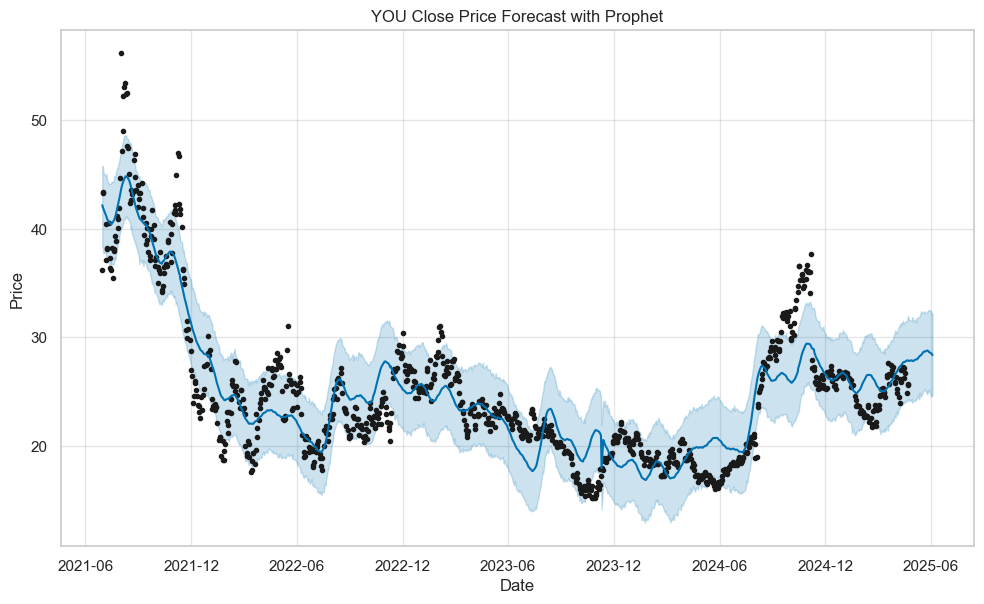

In [291]:
# 4) Plot the forecast
fig1 = m.plot(forecast, xlabel="Date", ylabel="Price")
plt.title(f"{ticker} Close Price Forecast with Prophet")
plt.show()

The plot above shows three things in one view:
1. Black dots – the actual historical closing prices for YOU that you fed into Prophet.
2. Solid blue line – the model’s best estimate of the underlying price trend + seasonality, fit to that historical data.
3. Light-blue band – the model’s uncertainty interval (by default an 80% credible interval), telling you “we’re X confident the true price will lie somewhere in this shaded region.”

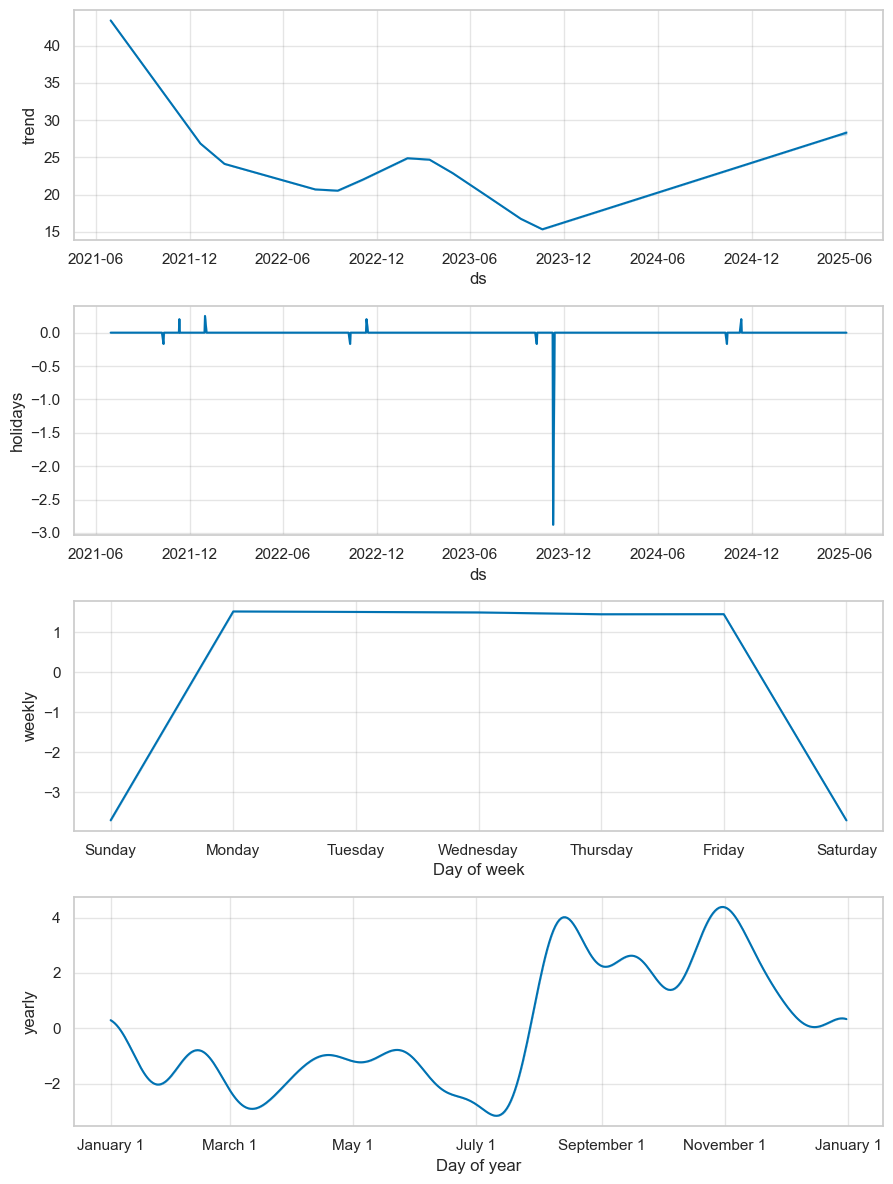

In [293]:
# 5) Components (trend + seasonality + holidays)
fig2 = m.plot_components(forecast)
plt.show()

1) **Trend:** The smooth, “long-term” trajectory Prophet fit to your data, with automatic breakpoints where the slope changes.  
- This is the baseline on which all seasonal and holiday effects get added.

2) **Holidays:** Prophet’s learned “spikes” or “dips” on specific calendar dates you asked it to include (here: U.S. market holidays).  
- Stocks often jump or drop around scheduled closures or earnings dates; Prophet models those as known exogenous effects.

3) **Weekly Seasonality:** The average “day-of-week” effect, computed across your entire training period.  
- It captures consistent patterns like “Monday open is usually slightly lower” or “Friday sometimes rallies.”

4) **Yearly Seasonality:** The recurring pattern within a year—that is, how “time of year” influences price.  
- Many equities exhibit calendar effects (e.g. “sell in May and go away,” year-end rallies).

Prophet’s final forecast =  
```
trend(t)  
+ weekly_seasonality(day_of_week t)  
+ yearly_seasonality(day_of_year t)  
+ holiday_effect(t)
```
Each subplot shows one of those components as a function of time (or day-of-week / day-of-year). By examining them:

- You see **why** the forecast moves up or down at certain times.  
- You can verify whether the model learned sensible seasonality (e.g. did July really tend to be a peak?).  
- You can spot if any holiday effect is overly large or unintuitive and adjust your model configuration accordingly.

In short, these “components plots” make Prophet fully transparent: you don’t just get “here’s a blue line prediction,” you see **exactly** how trend, weekly cycles, yearly cycles, and holidays combine to form that line.

In [295]:
# 6) Evaluate historical performance (optional)
#    You can compare `forecast.yhat` on the training period back to `df_prophet.y`
#    by merging them and computing an RMSE, etc.

df_forecasted = forecast.set_index("ds")[["yhat"]].join(df_prophet.set_index("ds"))
df_forecasted = df_forecasted.dropna()

from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(df_forecasted["y"], df_forecasted["yhat"]))
print(f"{ticker} in-sample RMSE: {rmse:.2f}")

YOU in-sample RMSE: 2.91
